In [1]:
# BATCH:256
# batch_size:256
# data_path:"/data2"
# decay:0.7834769413661389
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:32
# learning_rate:0.007176761798504128
# pre_spike_weight:5.165214142219577
# rate_coding:true
# TIME_STEP:9
# time_step:9
# v_decay:0.7834769413661389
# v_reset:0
# v_threshold:1
# which_data:"CIFAR10"


# BATCH:256
# batch_size:256
# data_path:"/data2"
# decay:0.38993471232202725
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:28
# learning_rate:0.06285718352377828
# pre_spike_weight:6.21970124592063
# rate_coding:true
# TIME_STEP:16
# time_step:16
# v_decay:0.38993471232202725
# v_reset:0
# v_threshold:1
# which_data:"MNIST"

# BATCH:64
# batch_size:64
# data_path:"/data2"
# decay:0.9266077968579136
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:28
# learning_rate:0.07732456724854177
# pre_spike_weight:1.5377416716615555
# rate_coding:true
# TIME_STEP:7
# time_step:7
# v_decay:0.9266077968579136
# v_reset:0
# v_threshold:1
# which_data:"FASHION_MNIST"

In [2]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [3]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt


from snntorch import spikegen

 
import wandb

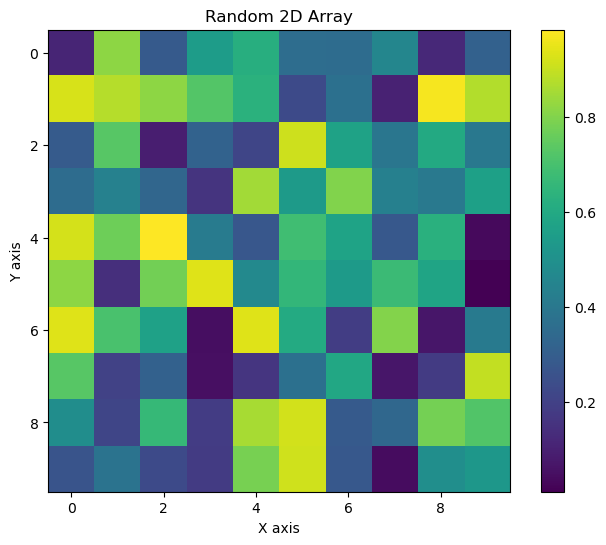

In [4]:
# my module import
from modules import *

In [5]:
    
class RESERVOIR(nn.Module):
    def __init__ (self, TIME_STEP=8, in_spike_size=28, in_channel=1, receptive_size=3, v_init=0, v_decay=0.6, v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1,
                  FC_RESERVOIR=False):
        super(RESERVOIR, self).__init__()
        self.TIME_STEP = TIME_STEP
        self.in_spike_size = in_spike_size
        self.in_channel = in_channel
        self.receptive_size = receptive_size #3
        self.v_init = v_init
        self.v_decay = v_decay
        self.v_threshold = v_threshold
        self.v_reset = v_reset
        self.hard_reset = hard_reset
        self.pre_spike_weight = pre_spike_weight
        self.FC_RESERVOIR = FC_RESERVOIR

        self.out_channel = 1

        # 파라미터 
        if self.FC_RESERVOIR == True:
            self.reservoir = nn.Linear(in_features=self.in_channel*self.in_spike_size*self.in_spike_size, out_features=self.in_channel*self.in_spike_size*self.in_spike_size, bias=True)
        else:
            self.reservoir = nn.Conv2d(in_channels=self.in_channel, out_channels=self.in_channel, 
                                            kernel_size=self.receptive_size, 
                                            stride=1, padding=1, groups=self.in_channel)

        # kaiming 초기화
        nn.init.kaiming_normal_(self.reservoir.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.reservoir.bias, 0)

        # membrane potential 초기화
        self.v = torch.full((self.in_channel, self.in_spike_size, self.in_spike_size), fill_value=self.v_init, requires_grad=False)

        
    def forward(self, pre_spike):    
        # pre_spike [TIME_STEP, batch_size, in_channel, in_spike_size, in_spike_size]

        v = torch.full_like(pre_spike[0], fill_value=self.v_init, requires_grad=False)
        post_spike = torch.zeros_like(pre_spike[0], requires_grad=False)
        # v [batch_size, in_channel, in_spike_size, in_spike_size]
        # recurrent [batch_size, in_channel, in_spike_size, in_spike_size]

        # timestep 안 맞으면 종료
        assert pre_spike.size(0) == self.TIME_STEP, f"Time step mismatch: {pre_spike.size(0)} vs {self.TIME_STEP}"

        output = []
        for t in range (self.TIME_STEP):
            # depthwise conv reservoir: pre_spike[t] [batch_size, in_channel, in_spike_size, in_spike_size]
            # fc conv reservoir: pre_spike[t] [batch_size, in_channel*in_spike_size*in_spike_size]
            input_current = self.pre_spike_weight * pre_spike[t]
                
            recurrent_current = self.reservoir(post_spike)
            current = input_current + recurrent_current
            # current [batch_size, in_channel, in_spike_size, in_spike_size] # kernel size 3이니까 사이즈 유지
            
            # decay and itegrate
            v = v*self.v_decay + current

            # post spike
            post_spike = (v >= self.v_threshold).float()

            output.append(post_spike)
            
            #reset
            if self.hard_reset: # hard reset
                v = (1 - post_spike)*v + post_spike*self.v_reset 
            else: # soft reset
                v = v - post_spike*self.v_threshold

        output = torch.stack(output, dim=0)
        return output

In [6]:
class RESERVOIR_NET(nn.Module):
    def __init__(self, TIME_STEP=8, CLASS_NUM=10, in_spike_size=28, in_channel=1, receptive_size=3, v_init=0, v_decay=0.6, v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1,
                 no_reservoir = False, FC_RESERVOIR=False):
        super(RESERVOIR_NET, self).__init__()
        self.TIME_STEP = TIME_STEP
        self.no_reservoir = no_reservoir
        self.FC_RESERVOIR = FC_RESERVOIR

        if self.no_reservoir == False:
            self.reservoir = RESERVOIR(TIME_STEP = self.TIME_STEP, in_spike_size=in_spike_size, in_channel=in_channel, receptive_size=receptive_size, v_init=v_init, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight,
                                       FC_RESERVOIR=FC_RESERVOIR)
        
        self.classifier = nn.Linear(in_features=in_channel*in_spike_size*in_spike_size, out_features=CLASS_NUM)

    def forward(self, x):
        assert self.TIME_STEP == x.size(1), f"Time step mismatch: {x.size(1)} vs {self.TIME_STEP}"

        # x size [batch_size, TIME_STEP, in_channel, in_spike_size, in_spike_size]
        x = x.permute(1,0,2,3,4)
        # x size [TIME_STEP, batch_size, in_channel, in_spike_size, in_spike_size]

        if (self.FC_RESERVOIR == True):
            x = x.reshape(x.size(0), x.size(1), -1)

        if self.no_reservoir == False:
            with torch.no_grad():
                x = self.reservoir(x) # reservoir weight는 학습 안함

        T, B, *spatial_dims = x.shape

        x = x.reshape(T * B, -1) # time,batch 축은 합쳐서 FC에 삽입

        x = self.classifier(x)

        x = x.view(T , B, -1).contiguous() 
        
        x = x.mean(dim=0)
        return x

In [7]:
def data_loader(which_data, data_path, rate_coding, BATCH, IMAGE_SIZE, TIME, dvs_duration, dvs_clipping):
    if which_data == 'MNIST':
        if rate_coding :
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0,), (1,))])
        else : 
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5))])

        trainset = torchvision.datasets.MNIST(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform)


        testset = torchvision.datasets.MNIST(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform)

        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        synapse_conv_in_channels = 1
        CLASS_NUM = 10


    

    elif (which_data == 'CIFAR10'):

        if rate_coding :
            # transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.RandomHorizontalFlip(),
            #                                     transforms.ToTensor()])

            # transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.ToTensor()])
            
            transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor()])
                                            # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

            transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                                transforms.ToTensor()])
        
        else :
            # transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.RandomHorizontalFlip(),
            #                                     transforms.ToTensor(),
            #                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
            #                                 # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

            # transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.ToTensor(),
            #                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),])
            #                                 # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            
            # assert IMAGE_SIZE == 32, 'OTTT랑 맞짱뜰 때는 32로 ㄱ'
            transform_train = transforms.Compose([
                transforms.RandomCrop(IMAGE_SIZE, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465),
                                    (0.2023, 0.1994, 0.2010)),
            ])
            transform_test = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465),
                                    (0.2023, 0.1994, 0.2010)),
            ])

        trainset = torchvision.datasets.CIFAR10(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform_train)


        testset = torchvision.datasets.CIFAR10(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform_test)
        
        
        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        
        synapse_conv_in_channels = 3
        CLASS_NUM = 10
        '''
        classes = ('plane', 'car', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck') 
        '''


    elif (which_data == 'FASHION_MNIST'):

        if rate_coding :
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor()])
        else : 
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5))])

        trainset = torchvision.datasets.FashionMNIST(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform)


        testset = torchvision.datasets.FashionMNIST(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform)

        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        synapse_conv_in_channels = 1
        CLASS_NUM = 10
    elif (which_data == 'DVS_GESTURE'):
        data_dir = data_path + '/gesture'
        transform = None

        # # spikingjelly.datasets.dvs128_gesture.DVS128Gesture(root: str, train: bool, use_frame=True, frames_num=10, split_by='number', normalization='max')
       
        #https://spikingjelly.readthedocs.io/zh-cn/latest/activation_based_en/neuromorphic_datasets.html
        # 10ms마다 1개의 timestep하고 싶으면 위의 주소 참고. 근데 timestep이 각각 좀 다를 거임.

        if dvs_duration > 0:
            resize_shape = (IMAGE_SIZE, IMAGE_SIZE)
            train_data = CustomDVS128Gesture(
                data_dir, train=True, data_type='frame',  split_by='time',  duration=dvs_duration, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
            test_data = CustomDVS128Gesture(
                data_dir, train=False, data_type='frame',  split_by='time',  duration=dvs_duration, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
        else:
            train_data = CustomDVS128Gesture(
                data_dir, train=True, data_type='frame', split_by='number', frames_number=TIME, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
            test_data = CustomDVS128Gesture(data_dir, train=False,
                                            data_type='frame', split_by='number', frames_number=TIME, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
        
        ## 11번째 클래스 배제 ########################################################################
        exclude_class = 10
        if dvs_duration > 0:
            train_file_name = f'modules/dvs_gesture_class_index/train_indices_dvsgesture_duration_{dvs_duration}'
            test_file_name = f'modules/dvs_gesture_class_index/test_indices_dvsgesture_duration_{dvs_duration}'
            if (os.path.isfile(train_file_name) and os.path.isfile(test_file_name)):
                print('\ndvsgestrue 10 class indices exist. we want to exclude the 11th class\n')
                with open(train_file_name, 'rb') as f:
                    train_indices = pickle.load(f)
                with open(test_file_name, 'rb') as f:
                    test_indices = pickle.load(f)
            else:
                print('\ndvsgestrue 10 class indices doesn\'t exist. we want to exclude the 11th class\n')
                train_indices = [i for i, (_, target) in enumerate(train_data) if target != exclude_class]
                test_indices = [i for i, (_, target) in enumerate(test_data) if target != exclude_class]
                with open(train_file_name, 'wb') as f:
                    pickle.dump(train_indices, f)
                with open(test_file_name, 'wb') as f:
                    pickle.dump(test_indices, f)
        else:
            train_indices = [i for i, (_, target) in enumerate(train_data) if target != exclude_class]
            test_indices = [i for i, (_, target) in enumerate(test_data) if target != exclude_class]
        ################################################################################################

        # SubsetRandomSampler 생성
        train_sampler = SubsetRandomSampler(train_indices)
        test_sampler = SequentialSampler(test_indices)

        # ([B, T, 2, 128, 128]) 
        train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH, num_workers=2, sampler=train_sampler, collate_fn=pad_sequence_collate)
        test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH, num_workers=2, sampler=test_sampler, collate_fn=pad_sequence_collate)
        synapse_conv_in_channels = 2
        CLASS_NUM = 10
        # mapping = { 0 :'Hand Clapping'  1 :'Right Hand Wave'2 :'Left Hand Wave' 3 :'Right Arm CW'   4 :'Right Arm CCW'  5 :'Left Arm CW'    6 :'Left Arm CCW'   7 :'Arm Roll'       8 :'Air Drums'      9 :'Air Guitar'     10:'Other'}

    else:
        assert False, 'wrong dataset name'


    
    return train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM

In [8]:
def train(model, train_loader, criterion, optimizer, device, rate_coding, TIME_STEP, which_data):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    iterator = enumerate(train_loader, 0)
    for i, data in iterator:
    # for i, (inputs, labels) in enumerate(train_loader):
        if len(data) == 2:
            inputs, labels = data
            # 처리 로직 작성
        elif len(data) == 3:
            inputs, labels, x_len = data

        inputs, labels = inputs.to(device), labels.to(device)

        # if rate_coding == True:
        #     inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
        # else:
        #     inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
        

        ###########################################################################################################################        
        if (which_data == 'n_tidigits'):
            inputs = inputs.permute(0, 1, 3, 2, 4)
            labels = labels[:, 0, :]
            labels = torch.argmax(labels, dim=1)
        elif (which_data == 'heidelberg'):
            inputs = inputs.view(5, 1000, 1, 700, 1)
            print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
        # print('inputs',inputs.size(),'\nlabels',labels.size())
        # print(labels)
            
        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
            inputs = inputs.permute(1, 0, 2, 3, 4)
        elif rate_coding == True :
            inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
        else :
            inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
        # inputs: [Time, Batch, Channel, Height, Width]  
        ####################################################################################################################### 

        
        
        
        
        inputs = inputs.permute(1, 0, 2, 3, 4)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        iter_correct = (predicted == labels).sum().item()
        correct += iter_correct
        # if i % 100 == 99:
        # print(f"[{i+1}] loss: {running_loss / 100:.3f}")
        # running_loss = 0.0
        iter_accuracy = 100 * iter_correct / labels.size(0)
        wandb.log({"iter_accuracy": iter_accuracy})
    tr_accuracy = 100 * correct / total         
    wandb.log({"tr_accuracy": tr_accuracy})
    print(f"Train Accuracy: {tr_accuracy:.2f}%")
    
def test(model, test_loader, criterion, device, rate_coding, TIME_STEP, which_data):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    iterator = enumerate(test_loader, 0)
    with torch.no_grad():
        for i, data in iterator:
        # for inputs, labels in test_loader:
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                
            inputs, labels = inputs.to(device), labels.to(device)

            # if rate_coding == True:
            #     inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
            # else:
            #     inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)

        

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
            else :
                inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 

        


            inputs = inputs.permute(1, 0, 2, 3, 4)
        
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = 100 * correct / total
    wandb.log({"val_accuracy": val_accuracy})
    print(f"Test loss: {test_loss / len(test_loader):.3f}, Val Accuracy: {val_accuracy:.2f}%")


In [9]:
def main(data_path='/data2', which_data='MNIST', gpu = '3',learning_rate = 0.0001, BATCH=5, IMAGE_SIZE=28, TIME_STEP=8, EPOCH=10, rate_coding=True, v_decay= 0.6,
v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False, FC_RESERVOIR=False):
    os.environ["CUDA_VISIBLE_DEVICES"]= gpu
    # run = wandb.init(project=f'reservoir')

    hyperparameters = locals()

    wandb.config.update(hyperparameters)
    wandb.run.name = f'{which_data}_sweeprun_epoch{EPOCH}'
    wandb.run.log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))

    train_loader, test_loader, in_channel, CLASS_NUM = data_loader(
        which_data=which_data, data_path=data_path, rate_coding=rate_coding, BATCH=BATCH, IMAGE_SIZE=IMAGE_SIZE, TIME=TIME_STEP, dvs_duration=dvs_duration, dvs_clipping=dvs_clipping)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = RESERVOIR_NET(TIME_STEP=TIME_STEP, CLASS_NUM=CLASS_NUM, in_spike_size=IMAGE_SIZE, in_channel=in_channel, receptive_size=3, v_init=0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight, 
                            no_reservoir = no_reservoir, FC_RESERVOIR=FC_RESERVOIR)
    net = net.to(device)
    wandb.watch(net, log="all", log_freq = 1) #gradient, parameter logging해줌

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)

    print(net)

    for epoch in range(EPOCH):
        print(f"Epoch {epoch+1}")
        train(net, train_loader, criterion, optimizer, device, rate_coding, TIME_STEP, which_data)
        test(net, test_loader, criterion, device, rate_coding, TIME_STEP, which_data)
        wandb.log({"epoch": epoch})
        # torch.save(net.state_dict(), 'net_save/reservoir_net.pth')
        # artifact = wandb.Artifact('model', type='model')
        # artifact.add_file('net_save/reservoir_net.pth')
        # run.log_artifact(artifact)


In [10]:
# # sweep 하기 싫을 때
# wandb.init(project=f'reservoir')
# main(data_path='/data2', which_data='CIFAR10', gpu = '3', learning_rate = 0.0072, BATCH=256, IMAGE_SIZE=32, TIME_STEP=9, EPOCH=50, rate_coding=True, v_decay= 0.78,
# v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=5.0, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False, FC_RESERVOIR=False)

In [11]:
# sweep하고싶을 때
def sweep_cover(data_path='/data2', which_data='CIFAR10', gpu = '6', learning_rate = 0.0001, BATCH=5, IMAGE_SIZE=28, TIME_STEP=8, EPOCH=3, rate_coding=True, v_decay= 0.6,
v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False, FC_RESERVOIR=False):
    
    wandb.init(save_code = True)

    learning_rate  =  wandb.config.learning_rate
    BATCH  =  wandb.config.batch_size
    TIME_STEP  =  wandb.config.time_step
    v_decay  =  wandb.config.decay
    pre_spike_weight  =  wandb.config.pre_spike_weight
    which_data  =  wandb.config.which_data
    data_path  =  wandb.config.data_path
    rate_coding  =  wandb.config.rate_coding
    EPOCH  =  wandb.config.EPOCH
    IMAGE_SIZE  =  wandb.config.IMAGE_SIZE
    dvs_duration  =  wandb.config.dvs_duration
    dvs_clipping  =  wandb.config.dvs_clipping
    no_reservoir  =  wandb.config.no_reservoir
    FC_RESERVOIR  =  wandb.config.FC_RESERVOIR
    main(data_path=data_path, which_data=which_data, gpu = gpu, learning_rate = learning_rate, BATCH=BATCH, IMAGE_SIZE=IMAGE_SIZE, TIME_STEP=TIME_STEP, EPOCH=EPOCH, rate_coding=rate_coding, v_decay= v_decay,
v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight, dvs_duration=dvs_duration, dvs_clipping=dvs_clipping, no_reservoir = no_reservoir, FC_RESERVOIR=FC_RESERVOIR)



which_data_hyper = 'MNIST' # 'MNIST', 'CIFAR10' ', 'FASHION_MNIST', 'DVS_GESTURE'
data_path_hyper = '/data2'

sweep_configuration = {
    'method': 'bayes',
    'name': f'{which_data_hyper} ba_reservoir',
    'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
    'parameters': 
    {
        "learning_rate": {"values": [0.09]},
        "batch_size": {"values": [128, 256]},
        "time_step": {"values": [4,5,6,7,8]},
        "decay": {"values": [0.7]},
        "pre_spike_weight": {"min": 0.5, "max": 10.0},
        "which_data": {"values": [which_data_hyper]},
        "data_path": {"values": [data_path_hyper]},
        "rate_coding": {"values": [True, False]},
        "EPOCH": {"values": [3]},
        "IMAGE_SIZE": {"values": [28]},
        "dvs_duration": {"values": [1000000]},
        "dvs_clipping": {"values": [True]},
        "no_reservoir": {"values": [True, False]},
        "FC_RESERVOIR": {"values": [False]},
     }
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'reservoir')
wandb.agent(sweep_id, function=sweep_cover, count=10000)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: 6b8la78n
Sweep URL: https://wandb.ai/bhkim003-seoul-national-university/reservoir/sweeps/6b8la78n


wandb: Agent Starting Run: r3319ejr with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.244667191233999
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.42%
Test loss: 0.645, Val Accuracy: 89.22%
Epoch 2
Train Accuracy: 87.81%
Test loss: 0.594, Val Accuracy: 89.05%
Epoch 3
Train Accuracy: 88.09%
Test loss: 0.694, Val Accuracy: 86.64%


wandb: Agent Starting Run: gwy4f7z3 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.759475520919883
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.44%
Test loss: 0.310, Val Accuracy: 91.04%
Epoch 2
Train Accuracy: 91.07%
Test loss: 0.291, Val Accuracy: 91.57%
Epoch 3
Train Accuracy: 91.56%
Test loss: 0.279, Val Accuracy: 92.06%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2fib2tcr with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.44730191547537
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.51%
Test loss: 0.315, Val Accuracy: 90.94%
Epoch 2
Train Accuracy: 90.90%
Test loss: 0.301, Val Accuracy: 91.35%
Epoch 3
Train Accuracy: 91.34%
Test loss: 0.297, Val Accuracy: 91.41%


wandb: Agent Starting Run: a2zba561 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.400673079755911
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 81.96%
Test loss: 0.611, Val Accuracy: 89.65%
Epoch 2
Train Accuracy: 90.04%
Test loss: 0.429, Val Accuracy: 90.31%
Epoch 3
Train Accuracy: 89.83%
Test loss: 0.356, Val Accuracy: 91.21%


wandb: Agent Starting Run: iyq5fw4u with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.071907707153583
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.73%
Test loss: 0.308, Val Accuracy: 91.22%
Epoch 2
Train Accuracy: 91.01%
Test loss: 0.293, Val Accuracy: 91.56%
Epoch 3
Train Accuracy: 91.49%
Test loss: 0.288, Val Accuracy: 91.83%


wandb: Agent Starting Run: zu9r8nxl with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.077212125526491
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.79%
Test loss: 0.549, Val Accuracy: 88.16%
Epoch 2
Train Accuracy: 89.05%
Test loss: 0.390, Val Accuracy: 90.48%
Epoch 3
Train Accuracy: 89.72%
Test loss: 0.363, Val Accuracy: 90.40%


wandb: Agent Starting Run: qctw8azv with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.006944986270378
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.17%
Test loss: 0.318, Val Accuracy: 90.93%
Epoch 2
Train Accuracy: 90.84%
Test loss: 0.302, Val Accuracy: 91.21%
Epoch 3
Train Accuracy: 91.32%
Test loss: 0.296, Val Accuracy: 91.54%


wandb: Agent Starting Run: yazkxhke with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.343262545548946
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.14%
Test loss: 0.324, Val Accuracy: 90.93%
Epoch 2
Train Accuracy: 90.87%
Test loss: 0.303, Val Accuracy: 91.17%
Epoch 3
Train Accuracy: 91.33%
Test loss: 0.298, Val Accuracy: 91.34%


wandb: Agent Starting Run: jiagf8re with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.904388580597516
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.75%
Test loss: 0.306, Val Accuracy: 91.60%
Epoch 2
Train Accuracy: 91.01%
Test loss: 0.291, Val Accuracy: 91.79%
Epoch 3
Train Accuracy: 91.50%
Test loss: 0.286, Val Accuracy: 91.76%


wandb: Agent Starting Run: 8bxvhbu3 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.835218627940307
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.65%
Test loss: 0.303, Val Accuracy: 91.15%
Epoch 2
Train Accuracy: 90.78%
Test loss: 0.285, Val Accuracy: 91.97%
Epoch 3
Train Accuracy: 90.99%
Test loss: 0.287, Val Accuracy: 91.49%


wandb: Agent Starting Run: 7i4cz496 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.780393859468198
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.46%
Test loss: 0.314, Val Accuracy: 90.98%
Epoch 2
Train Accuracy: 90.86%
Test loss: 0.297, Val Accuracy: 91.53%
Epoch 3
Train Accuracy: 91.38%
Test loss: 0.298, Val Accuracy: 91.44%


wandb: Agent Starting Run: xvag563g with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.522129448235096
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.74%
Test loss: 0.333, Val Accuracy: 90.71%
Epoch 2
Train Accuracy: 90.60%
Test loss: 0.313, Val Accuracy: 91.20%
Epoch 3
Train Accuracy: 91.12%
Test loss: 0.306, Val Accuracy: 91.34%


wandb: Agent Starting Run: slm8u4po with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.95849544238971
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.21%
Test loss: 0.317, Val Accuracy: 91.01%
Epoch 2
Train Accuracy: 90.90%
Test loss: 0.301, Val Accuracy: 91.58%
Epoch 3
Train Accuracy: 91.23%
Test loss: 0.297, Val Accuracy: 91.64%


wandb: Agent Starting Run: ilw9il8f with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.952232752650616
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.36%
Test loss: 0.317, Val Accuracy: 90.83%
Epoch 2
Train Accuracy: 90.89%
Test loss: 0.300, Val Accuracy: 91.47%
Epoch 3
Train Accuracy: 91.34%
Test loss: 0.292, Val Accuracy: 91.59%


wandb: Agent Starting Run: r1gp3ipg with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.4031760518517906
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.86%
Test loss: 0.296, Val Accuracy: 91.60%
Epoch 2
Train Accuracy: 90.88%
Test loss: 0.288, Val Accuracy: 91.51%
Epoch 3
Train Accuracy: 91.28%
Test loss: 0.275, Val Accuracy: 91.95%


wandb: Agent Starting Run: h6umiis5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.7922404843426288
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.30%
Test loss: 0.420, Val Accuracy: 91.32%
Epoch 2
Train Accuracy: 89.72%
Test loss: 0.421, Val Accuracy: 89.31%
Epoch 3
Train Accuracy: 89.84%
Test loss: 0.453, Val Accuracy: 88.41%


wandb: Agent Starting Run: v84qes1s with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.991997289916078
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.82%
Test loss: 0.299, Val Accuracy: 91.34%
Epoch 2
Train Accuracy: 91.30%
Test loss: 0.289, Val Accuracy: 91.67%
Epoch 3
Train Accuracy: 91.74%
Test loss: 0.283, Val Accuracy: 91.75%


wandb: Agent Starting Run: 9f9rn7nm with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.541691160689768
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.53%
Test loss: 0.606, Val Accuracy: 88.67%
Epoch 2
Train Accuracy: 87.70%
Test loss: 0.743, Val Accuracy: 87.05%
Epoch 3
Train Accuracy: 87.84%
Test loss: 0.599, Val Accuracy: 88.52%


wandb: Agent Starting Run: mjdpqhnx with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.107210508907695
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.80%
Test loss: 0.313, Val Accuracy: 90.63%
Epoch 2
Train Accuracy: 91.06%
Test loss: 0.302, Val Accuracy: 91.10%
Epoch 3
Train Accuracy: 91.49%
Test loss: 0.297, Val Accuracy: 91.27%


wandb: Agent Starting Run: l9rozql6 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.6576185058822173
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.08%
Test loss: 0.384, Val Accuracy: 91.21%
Epoch 2
Train Accuracy: 89.91%
Test loss: 0.350, Val Accuracy: 91.13%
Epoch 3
Train Accuracy: 89.65%
Test loss: 0.389, Val Accuracy: 89.94%


wandb: Agent Starting Run: n2smvi71 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.91795520021338
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.21%
Test loss: 0.543, Val Accuracy: 88.83%
Epoch 2
Train Accuracy: 89.50%
Test loss: 0.541, Val Accuracy: 86.47%
Epoch 3
Train Accuracy: 89.69%
Test loss: 0.411, Val Accuracy: 89.23%


wandb: Agent Starting Run: b94sjdcg with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.317848155608002
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.95%
Test loss: 0.480, Val Accuracy: 89.05%
Epoch 2
Train Accuracy: 89.38%
Test loss: 0.513, Val Accuracy: 87.14%
Epoch 3
Train Accuracy: 89.56%
Test loss: 0.421, Val Accuracy: 89.46%


wandb: Agent Starting Run: xluyqop3 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.342642910046698
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.41%
Test loss: 0.568, Val Accuracy: 89.85%
Epoch 2
Train Accuracy: 89.54%
Test loss: 0.604, Val Accuracy: 85.46%
Epoch 3
Train Accuracy: 89.48%
Test loss: 0.391, Val Accuracy: 90.62%


wandb: Agent Starting Run: bad3nd4o with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.039890102697605
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.33%
Test loss: 0.315, Val Accuracy: 91.01%
Epoch 2
Train Accuracy: 90.92%
Test loss: 0.299, Val Accuracy: 91.49%
Epoch 3
Train Accuracy: 91.47%
Test loss: 0.291, Val Accuracy: 91.51%


wandb: Agent Starting Run: 7p01dog7 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.1791516593853342
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.55%
Test loss: 0.356, Val Accuracy: 90.11%
Epoch 2
Train Accuracy: 89.98%
Test loss: 0.331, Val Accuracy: 90.57%
Epoch 3
Train Accuracy: 90.58%
Test loss: 0.324, Val Accuracy: 91.01%


wandb: Agent Starting Run: e7atpgi0 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.947776157371139
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.55%
Test loss: 0.316, Val Accuracy: 90.99%
Epoch 2
Train Accuracy: 90.85%
Test loss: 0.292, Val Accuracy: 91.56%
Epoch 3
Train Accuracy: 91.31%
Test loss: 0.283, Val Accuracy: 91.89%


wandb: Agent Starting Run: gbw5mepa with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.342231621095743
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.33%
Test loss: 0.783, Val Accuracy: 86.07%
Epoch 2
Train Accuracy: 88.01%
Test loss: 0.527, Val Accuracy: 90.49%
Epoch 3
Train Accuracy: 88.54%
Test loss: 0.735, Val Accuracy: 85.54%


wandb: Agent Starting Run: lyv3iniz with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.9753664175814992
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 85.62%
Test loss: 0.357, Val Accuracy: 90.29%
Epoch 2
Train Accuracy: 89.76%
Test loss: 0.328, Val Accuracy: 90.93%
Epoch 3
Train Accuracy: 90.26%
Test loss: 0.316, Val Accuracy: 90.93%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j25efy5a with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.5220797883733728
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.11%
Test loss: 0.414, Val Accuracy: 88.73%
Epoch 2
Train Accuracy: 88.42%
Test loss: 0.368, Val Accuracy: 89.49%
Epoch 3
Train Accuracy: 89.26%
Test loss: 0.349, Val Accuracy: 90.33%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k5oqt7ji with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.360021502928108
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.72%
Test loss: 0.310, Val Accuracy: 91.33%
Epoch 2
Train Accuracy: 91.15%
Test loss: 0.289, Val Accuracy: 91.67%
Epoch 3
Train Accuracy: 91.61%
Test loss: 0.286, Val Accuracy: 91.88%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b451mwoj with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.413486439537587
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.52%
Test loss: 0.306, Val Accuracy: 91.21%
Epoch 2
Train Accuracy: 91.05%
Test loss: 0.300, Val Accuracy: 90.94%
Epoch 3
Train Accuracy: 91.46%
Test loss: 0.287, Val Accuracy: 91.67%


wandb: Agent Starting Run: hhwyntg0 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.86776119781884
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.71%
Test loss: 0.309, Val Accuracy: 91.16%
Epoch 2
Train Accuracy: 91.06%
Test loss: 0.306, Val Accuracy: 91.05%
Epoch 3
Train Accuracy: 91.37%
Test loss: 0.299, Val Accuracy: 91.68%


wandb: Agent Starting Run: 8jj88ry0 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.877529582442395
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.42%
Test loss: 0.317, Val Accuracy: 91.06%
Epoch 2
Train Accuracy: 90.96%
Test loss: 0.298, Val Accuracy: 91.49%
Epoch 3
Train Accuracy: 91.48%
Test loss: 0.294, Val Accuracy: 91.62%


wandb: Agent Starting Run: i5lgnmk8 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.861148050834206
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.22%
Test loss: 0.496, Val Accuracy: 90.24%
Epoch 2
Train Accuracy: 89.08%
Test loss: 0.457, Val Accuracy: 90.14%
Epoch 3
Train Accuracy: 89.73%
Test loss: 0.427, Val Accuracy: 89.36%


wandb: Agent Starting Run: 0xbu2cjg with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.8504270048082523
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.25%
Test loss: 0.317, Val Accuracy: 91.09%
Epoch 2
Train Accuracy: 90.96%
Test loss: 0.320, Val Accuracy: 90.77%
Epoch 3
Train Accuracy: 91.39%
Test loss: 0.321, Val Accuracy: 90.89%


wandb: Agent Starting Run: amxfmna7 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.647407320696842
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.52%
Test loss: 0.297, Val Accuracy: 91.54%
Epoch 2
Train Accuracy: 91.05%
Test loss: 0.298, Val Accuracy: 91.25%
Epoch 3
Train Accuracy: 91.23%
Test loss: 0.297, Val Accuracy: 91.16%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tekttfxs with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.183859053594252
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 89.00%
Test loss: 0.310, Val Accuracy: 91.37%
Epoch 2
Train Accuracy: 91.41%
Test loss: 0.294, Val Accuracy: 91.80%
Epoch 3
Train Accuracy: 91.71%
Test loss: 0.289, Val Accuracy: 91.74%


wandb: Agent Starting Run: e0u9n1n9 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.606595157125643
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.72%
Test loss: 0.710, Val Accuracy: 86.64%
Epoch 2
Train Accuracy: 87.74%
Test loss: 0.497, Val Accuracy: 90.63%
Epoch 3
Train Accuracy: 88.20%
Test loss: 0.588, Val Accuracy: 88.08%


wandb: Agent Starting Run: 4mp33job with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.056635304434824
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.45%
Test loss: 0.311, Val Accuracy: 91.00%
Epoch 2
Train Accuracy: 91.02%
Test loss: 0.295, Val Accuracy: 91.60%
Epoch 3
Train Accuracy: 91.46%
Test loss: 0.291, Val Accuracy: 91.49%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: exl73909 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.340170378561184
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.79%
Test loss: 0.307, Val Accuracy: 91.20%
Epoch 2
Train Accuracy: 91.24%
Test loss: 0.303, Val Accuracy: 91.37%
Epoch 3
Train Accuracy: 91.61%
Test loss: 0.280, Val Accuracy: 92.03%


wandb: Agent Starting Run: b0twbfev with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.621456534531973
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.53%
Test loss: 0.504, Val Accuracy: 88.66%
Epoch 2
Train Accuracy: 89.46%
Test loss: 0.376, Val Accuracy: 90.35%
Epoch 3
Train Accuracy: 89.81%
Test loss: 0.389, Val Accuracy: 89.66%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1mriyurb with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.31065112246383
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.47%
Test loss: 0.601, Val Accuracy: 89.28%
Epoch 2
Train Accuracy: 87.90%
Test loss: 0.877, Val Accuracy: 84.13%
Epoch 3
Train Accuracy: 88.10%
Test loss: 0.623, Val Accuracy: 87.77%


wandb: Agent Starting Run: 0a7tn8ms with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.784359253646787
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.51%
Test loss: 0.317, Val Accuracy: 90.93%
Epoch 2
Train Accuracy: 90.94%
Test loss: 0.299, Val Accuracy: 91.12%
Epoch 3
Train Accuracy: 91.36%
Test loss: 0.301, Val Accuracy: 91.56%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8u21of5b with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.4191103033429684
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.78%
Test loss: 0.308, Val Accuracy: 90.98%
Epoch 2
Train Accuracy: 91.01%
Test loss: 0.292, Val Accuracy: 91.63%
Epoch 3
Train Accuracy: 91.55%
Test loss: 0.284, Val Accuracy: 91.96%


wandb: Agent Starting Run: 1v16uooj with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.9642833150629
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.03%
Test loss: 0.592, Val Accuracy: 88.50%
Epoch 2
Train Accuracy: 90.00%
Test loss: 0.379, Val Accuracy: 91.11%
Epoch 3
Train Accuracy: 89.98%
Test loss: 0.469, Val Accuracy: 87.29%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4q8obip2 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.371453507739559
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.96%
Test loss: 0.432, Val Accuracy: 89.99%
Epoch 2
Train Accuracy: 89.62%
Test loss: 0.367, Val Accuracy: 90.55%
Epoch 3
Train Accuracy: 89.42%
Test loss: 0.411, Val Accuracy: 89.17%


wandb: Agent Starting Run: f2pqwll1 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.519675753405302
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.62%
Test loss: 0.313, Val Accuracy: 90.96%
Epoch 2
Train Accuracy: 91.07%
Test loss: 0.298, Val Accuracy: 91.49%
Epoch 3
Train Accuracy: 91.52%
Test loss: 0.298, Val Accuracy: 91.42%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: scuzur8m with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.136539093697436
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.84%
Test loss: 0.504, Val Accuracy: 89.18%
Epoch 2
Train Accuracy: 89.34%
Test loss: 0.404, Val Accuracy: 89.91%
Epoch 3
Train Accuracy: 90.08%
Test loss: 0.471, Val Accuracy: 87.23%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l25kli29 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.7531249232966046
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.27%
Test loss: 0.317, Val Accuracy: 90.97%
Epoch 2
Train Accuracy: 90.73%
Test loss: 0.302, Val Accuracy: 91.31%
Epoch 3
Train Accuracy: 91.22%
Test loss: 0.299, Val Accuracy: 91.27%


wandb: Agent Starting Run: w7s0c5m2 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.448675942978806
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.78%
Test loss: 0.457, Val Accuracy: 90.01%
Epoch 2
Train Accuracy: 89.44%
Test loss: 0.560, Val Accuracy: 85.93%
Epoch 3
Train Accuracy: 89.59%
Test loss: 0.396, Val Accuracy: 89.79%


wandb: Agent Starting Run: y6cp23l4 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.7870520974777095
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 89.03%
Test loss: 0.295, Val Accuracy: 91.80%
Epoch 2
Train Accuracy: 91.27%
Test loss: 0.290, Val Accuracy: 91.76%
Epoch 3
Train Accuracy: 91.67%
Test loss: 0.281, Val Accuracy: 92.01%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tobr0xef with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.262709262301666
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.56%
Test loss: 0.624, Val Accuracy: 89.09%
Epoch 2
Train Accuracy: 87.91%
Test loss: 0.602, Val Accuracy: 88.81%
Epoch 3
Train Accuracy: 88.38%
Test loss: 0.723, Val Accuracy: 86.26%


wandb: Agent Starting Run: 062ce6a2 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.558805629247535
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.91%
Test loss: 0.308, Val Accuracy: 90.67%
Epoch 2
Train Accuracy: 91.17%
Test loss: 0.276, Val Accuracy: 92.07%
Epoch 3
Train Accuracy: 91.66%
Test loss: 0.282, Val Accuracy: 91.66%


wandb: Agent Starting Run: qvf4xs0x with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.682229088532094
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.50%
Test loss: 0.313, Val Accuracy: 91.49%
Epoch 2
Train Accuracy: 91.08%
Test loss: 0.292, Val Accuracy: 91.70%
Epoch 3
Train Accuracy: 91.39%
Test loss: 0.287, Val Accuracy: 91.92%


wandb: Agent Starting Run: v4tzjyzs with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.941880321526703
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.80%
Test loss: 0.307, Val Accuracy: 91.16%
Epoch 2
Train Accuracy: 91.15%
Test loss: 0.296, Val Accuracy: 91.46%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.286, Val Accuracy: 91.94%


wandb: Agent Starting Run: 5gquk2cq with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.751807373469227
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.69%
Test loss: 0.307, Val Accuracy: 91.29%
Epoch 2
Train Accuracy: 91.00%
Test loss: 0.286, Val Accuracy: 91.78%
Epoch 3
Train Accuracy: 91.53%
Test loss: 0.282, Val Accuracy: 91.89%


wandb: Agent Starting Run: u2wx70qh with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.824020466434113
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.67%
Test loss: 0.305, Val Accuracy: 91.33%
Epoch 2
Train Accuracy: 91.12%
Test loss: 0.314, Val Accuracy: 90.66%
Epoch 3
Train Accuracy: 91.40%
Test loss: 0.298, Val Accuracy: 91.33%


wandb: Agent Starting Run: lsoquorc with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.985355776713316
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.66%
Test loss: 0.312, Val Accuracy: 91.15%
Epoch 2
Train Accuracy: 91.01%
Test loss: 0.292, Val Accuracy: 91.62%
Epoch 3
Train Accuracy: 91.52%
Test loss: 0.288, Val Accuracy: 91.72%


wandb: Agent Starting Run: 1gh9n3uw with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.6379464603106713
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.61%
Test loss: 0.314, Val Accuracy: 91.05%
Epoch 2
Train Accuracy: 90.96%
Test loss: 0.290, Val Accuracy: 91.67%
Epoch 3
Train Accuracy: 91.47%
Test loss: 0.284, Val Accuracy: 91.98%


wandb: Agent Starting Run: 3oy4nzwl with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.732176626806883
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.85%
Test loss: 0.311, Val Accuracy: 90.92%
Epoch 2
Train Accuracy: 90.67%
Test loss: 0.302, Val Accuracy: 91.00%
Epoch 3
Train Accuracy: 90.93%
Test loss: 0.306, Val Accuracy: 90.68%


wandb: Agent Starting Run: fxbgbmp0 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.845954603932453
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.65%
Test loss: 0.320, Val Accuracy: 90.78%
Epoch 2
Train Accuracy: 90.92%
Test loss: 0.295, Val Accuracy: 91.60%
Epoch 3
Train Accuracy: 91.41%
Test loss: 0.289, Val Accuracy: 91.51%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jx0ubje9 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.243185417545298
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.41%
Test loss: 0.320, Val Accuracy: 90.92%
Epoch 2
Train Accuracy: 90.89%
Test loss: 0.305, Val Accuracy: 91.13%
Epoch 3
Train Accuracy: 91.45%
Test loss: 0.296, Val Accuracy: 91.35%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: blaxdhre with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.940149887211044
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.71%
Test loss: 0.306, Val Accuracy: 91.33%
Epoch 2
Train Accuracy: 91.02%
Test loss: 0.308, Val Accuracy: 90.75%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.283, Val Accuracy: 91.82%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xcwgvv0c with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.673356756276908
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.93%
Test loss: 0.476, Val Accuracy: 88.39%
Epoch 2
Train Accuracy: 89.14%
Test loss: 0.370, Val Accuracy: 90.56%
Epoch 3
Train Accuracy: 89.75%
Test loss: 0.372, Val Accuracy: 89.81%


wandb: Agent Starting Run: 7xgigjcx with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.262308353823384
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 89.06%
Test loss: 0.304, Val Accuracy: 91.22%
Epoch 2
Train Accuracy: 91.32%
Test loss: 0.289, Val Accuracy: 91.45%
Epoch 3
Train Accuracy: 91.67%
Test loss: 0.283, Val Accuracy: 91.66%


wandb: Agent Starting Run: 1kdlqw21 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.930608464416249
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.12%
Test loss: 0.531, Val Accuracy: 90.31%
Epoch 2
Train Accuracy: 89.46%
Test loss: 0.437, Val Accuracy: 90.03%
Epoch 3
Train Accuracy: 89.48%
Test loss: 0.339, Val Accuracy: 91.43%


wandb: Agent Starting Run: d5jn2eln with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.7888486754671495
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.83%
Test loss: 0.306, Val Accuracy: 91.57%
Epoch 2
Train Accuracy: 91.36%
Test loss: 0.295, Val Accuracy: 91.53%
Epoch 3
Train Accuracy: 91.59%
Test loss: 0.285, Val Accuracy: 91.66%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wibvwkr9 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.8751232120855232
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.25%
Test loss: 0.575, Val Accuracy: 88.67%
Epoch 2
Train Accuracy: 87.88%
Test loss: 0.557, Val Accuracy: 89.01%
Epoch 3
Train Accuracy: 88.21%
Test loss: 0.617, Val Accuracy: 88.07%


wandb: Agent Starting Run: v4qtoaim with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.392534766607559
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.52%
Test loss: 0.306, Val Accuracy: 91.52%
Epoch 2
Train Accuracy: 91.04%
Test loss: 0.290, Val Accuracy: 91.60%
Epoch 3
Train Accuracy: 91.45%
Test loss: 0.286, Val Accuracy: 91.83%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fs7hu1ho with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.548042744838583
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.65%
Test loss: 0.307, Val Accuracy: 91.18%
Epoch 2
Train Accuracy: 91.08%
Test loss: 0.288, Val Accuracy: 91.75%
Epoch 3
Train Accuracy: 91.53%
Test loss: 0.283, Val Accuracy: 91.95%


wandb: Agent Starting Run: bzww8kgo with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.654704949207124
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.30%
Test loss: 0.919, Val Accuracy: 83.72%
Epoch 2
Train Accuracy: 88.15%
Test loss: 0.712, Val Accuracy: 87.41%
Epoch 3
Train Accuracy: 87.98%
Test loss: 0.603, Val Accuracy: 87.85%


wandb: Agent Starting Run: treh9hxp with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.204131206127943
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.92%
Test loss: 0.302, Val Accuracy: 91.29%
Epoch 2
Train Accuracy: 91.27%
Test loss: 0.286, Val Accuracy: 91.80%
Epoch 3
Train Accuracy: 91.63%
Test loss: 0.278, Val Accuracy: 92.11%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0wprmuxa with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.70938834885505
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.33%
Test loss: 0.309, Val Accuracy: 91.33%
Epoch 2
Train Accuracy: 90.99%
Test loss: 0.299, Val Accuracy: 91.16%
Epoch 3
Train Accuracy: 91.41%
Test loss: 0.309, Val Accuracy: 90.85%


wandb: Agent Starting Run: y8s7eka9 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.22176400813635
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.77%
Test loss: 0.309, Val Accuracy: 91.20%
Epoch 2
Train Accuracy: 91.16%
Test loss: 0.290, Val Accuracy: 91.70%
Epoch 3
Train Accuracy: 91.55%
Test loss: 0.280, Val Accuracy: 91.82%


wandb: Agent Starting Run: j3i50pak with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.665979844347311
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.40%
Test loss: 0.336, Val Accuracy: 90.63%
Epoch 2
Train Accuracy: 90.54%
Test loss: 0.315, Val Accuracy: 90.92%
Epoch 3
Train Accuracy: 90.97%
Test loss: 0.316, Val Accuracy: 91.08%


wandb: Agent Starting Run: nh23xvg1 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.745810001219063
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.96%
Test loss: 0.294, Val Accuracy: 91.35%
Epoch 2
Train Accuracy: 91.34%
Test loss: 0.297, Val Accuracy: 91.37%
Epoch 3
Train Accuracy: 91.68%
Test loss: 0.283, Val Accuracy: 91.94%


wandb: Agent Starting Run: hzsrud6f with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.603963651421821
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.40%
Test loss: 0.517, Val Accuracy: 87.68%
Epoch 2
Train Accuracy: 89.31%
Test loss: 0.358, Val Accuracy: 90.96%
Epoch 3
Train Accuracy: 89.49%
Test loss: 0.351, Val Accuracy: 91.40%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kfsvtkmb with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.028807746595494
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.72%
Test loss: 0.311, Val Accuracy: 91.08%
Epoch 2
Train Accuracy: 91.06%
Test loss: 0.296, Val Accuracy: 91.22%
Epoch 3
Train Accuracy: 91.56%
Test loss: 0.292, Val Accuracy: 91.60%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yjo4vjah with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.454655377524956
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.96%
Test loss: 0.296, Val Accuracy: 91.35%
Epoch 2
Train Accuracy: 91.24%
Test loss: 0.280, Val Accuracy: 91.97%
Epoch 3
Train Accuracy: 91.36%
Test loss: 0.285, Val Accuracy: 91.80%


wandb: Agent Starting Run: 2jzmbpy2 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.3652201421268422
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 85.95%
Test loss: 0.346, Val Accuracy: 90.36%
Epoch 2
Train Accuracy: 90.23%
Test loss: 0.316, Val Accuracy: 90.92%
Epoch 3
Train Accuracy: 90.72%
Test loss: 0.303, Val Accuracy: 91.25%


wandb: Agent Starting Run: kmha0yvc with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.832125752182166
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.28%
Test loss: 0.316, Val Accuracy: 90.91%
Epoch 2
Train Accuracy: 90.94%
Test loss: 0.305, Val Accuracy: 91.23%
Epoch 3
Train Accuracy: 91.34%
Test loss: 0.296, Val Accuracy: 91.79%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nvulkjzg with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.713840759141451
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.29%
Test loss: 0.312, Val Accuracy: 91.10%
Epoch 2
Train Accuracy: 90.87%
Test loss: 0.299, Val Accuracy: 91.23%
Epoch 3
Train Accuracy: 91.11%
Test loss: 0.279, Val Accuracy: 91.55%


wandb: Agent Starting Run: re0a28sl with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.166550421908062
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.65%
Test loss: 0.646, Val Accuracy: 87.64%
Epoch 2
Train Accuracy: 87.76%
Test loss: 0.864, Val Accuracy: 84.04%
Epoch 3
Train Accuracy: 88.11%
Test loss: 0.505, Val Accuracy: 90.58%


wandb: Agent Starting Run: nmwdheci with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.946882356263574
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.93%
Test loss: 0.314, Val Accuracy: 90.99%
Epoch 2
Train Accuracy: 91.27%
Test loss: 0.291, Val Accuracy: 91.70%
Epoch 3
Train Accuracy: 91.55%
Test loss: 0.277, Val Accuracy: 92.36%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: og3b8tcj with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.195212639932725
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.65%
Test loss: 0.311, Val Accuracy: 91.05%
Epoch 2
Train Accuracy: 90.98%
Test loss: 0.307, Val Accuracy: 90.96%
Epoch 3
Train Accuracy: 91.51%
Test loss: 0.301, Val Accuracy: 91.55%


wandb: Agent Starting Run: 7c6ogote with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.843042624964314
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.59%
Test loss: 0.311, Val Accuracy: 91.10%
Epoch 2
Train Accuracy: 91.02%
Test loss: 0.293, Val Accuracy: 91.71%
Epoch 3
Train Accuracy: 91.48%
Test loss: 0.290, Val Accuracy: 91.68%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gp8wkuy3 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.123750483392811
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.62%
Test loss: 0.304, Val Accuracy: 91.16%
Epoch 2
Train Accuracy: 91.13%
Test loss: 0.288, Val Accuracy: 91.68%
Epoch 3
Train Accuracy: 91.39%
Test loss: 0.299, Val Accuracy: 91.65%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 26g86vtc with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.5425000994161129
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.88%
Test loss: 0.297, Val Accuracy: 91.60%
Epoch 2
Train Accuracy: 91.21%
Test loss: 0.284, Val Accuracy: 91.89%
Epoch 3
Train Accuracy: 91.58%
Test loss: 0.286, Val Accuracy: 91.76%


wandb: Agent Starting Run: u5fpjqhy with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.166091458363054
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.69%
Test loss: 0.575, Val Accuracy: 89.08%
Epoch 2
Train Accuracy: 89.93%
Test loss: 0.558, Val Accuracy: 86.10%
Epoch 3
Train Accuracy: 89.48%
Test loss: 0.372, Val Accuracy: 90.91%


wandb: Agent Starting Run: fsohh1ql with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.481376180163222
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 85.05%
Test loss: 0.362, Val Accuracy: 88.94%
Epoch 2
Train Accuracy: 89.31%
Test loss: 0.337, Val Accuracy: 89.75%
Epoch 3
Train Accuracy: 89.69%
Test loss: 0.331, Val Accuracy: 89.71%


wandb: Agent Starting Run: bpbvphtg with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.896356648024228
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.40%
Test loss: 0.307, Val Accuracy: 91.25%
Epoch 2
Train Accuracy: 91.02%
Test loss: 0.308, Val Accuracy: 90.98%
Epoch 3
Train Accuracy: 91.30%
Test loss: 0.299, Val Accuracy: 91.59%


wandb: Agent Starting Run: i1xs02wy with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.335290570217294
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.64%
Test loss: 0.312, Val Accuracy: 90.93%
Epoch 2
Train Accuracy: 91.03%
Test loss: 0.292, Val Accuracy: 91.77%
Epoch 3
Train Accuracy: 91.34%
Test loss: 0.290, Val Accuracy: 91.67%


wandb: Agent Starting Run: 039w630x with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.74658666602264
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.69%
Test loss: 0.559, Val Accuracy: 88.60%
Epoch 2
Train Accuracy: 87.56%
Test loss: 0.576, Val Accuracy: 88.81%
Epoch 3
Train Accuracy: 88.43%
Test loss: 0.577, Val Accuracy: 87.88%


wandb: Agent Starting Run: n14e9wlw with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.74745298767909
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.36%
Test loss: 0.446, Val Accuracy: 90.23%
Epoch 2
Train Accuracy: 89.49%
Test loss: 0.455, Val Accuracy: 88.06%
Epoch 3
Train Accuracy: 89.96%
Test loss: 0.368, Val Accuracy: 89.93%


wandb: Agent Starting Run: 9ez4aeu9 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.288490347796284
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.89%
Test loss: 0.302, Val Accuracy: 91.50%
Epoch 2
Train Accuracy: 91.21%
Test loss: 0.307, Val Accuracy: 91.05%
Epoch 3
Train Accuracy: 91.68%
Test loss: 0.279, Val Accuracy: 92.19%


wandb: Agent Starting Run: k12zhdey with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.175529108572391
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.65%
Test loss: 0.304, Val Accuracy: 91.51%
Epoch 2
Train Accuracy: 91.13%
Test loss: 0.295, Val Accuracy: 91.69%
Epoch 3
Train Accuracy: 91.50%
Test loss: 0.290, Val Accuracy: 91.88%


wandb: Agent Starting Run: z59vtucy with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.039516427836976
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.29%
Test loss: 0.728, Val Accuracy: 86.90%
Epoch 2
Train Accuracy: 88.12%
Test loss: 0.751, Val Accuracy: 85.29%
Epoch 3
Train Accuracy: 88.28%
Test loss: 0.482, Val Accuracy: 90.63%


wandb: Agent Starting Run: ha7olo2b with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.20097750732318
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.45%
Test loss: 0.309, Val Accuracy: 91.18%
Epoch 2
Train Accuracy: 91.07%
Test loss: 0.292, Val Accuracy: 91.73%
Epoch 3
Train Accuracy: 91.48%
Test loss: 0.289, Val Accuracy: 91.87%


wandb: Agent Starting Run: 1gnmjo7z with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.124319031620065
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.88%
Test loss: 0.304, Val Accuracy: 91.30%
Epoch 2
Train Accuracy: 91.05%
Test loss: 0.295, Val Accuracy: 91.73%
Epoch 3
Train Accuracy: 91.62%
Test loss: 0.282, Val Accuracy: 91.83%


wandb: Agent Starting Run: g8x8c5h1 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.904148342844064
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.76%
Test loss: 0.309, Val Accuracy: 91.14%
Epoch 2
Train Accuracy: 91.11%
Test loss: 0.293, Val Accuracy: 91.57%
Epoch 3
Train Accuracy: 91.55%
Test loss: 0.286, Val Accuracy: 91.76%


wandb: Agent Starting Run: zf9pwbtd with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.183714599403668
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.67%
Test loss: 0.657, Val Accuracy: 86.90%
Epoch 2
Train Accuracy: 88.02%
Test loss: 0.642, Val Accuracy: 87.04%
Epoch 3
Train Accuracy: 88.43%
Test loss: 0.657, Val Accuracy: 87.40%


wandb: Agent Starting Run: w05yfj9x with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.922124020023875
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.81%
Test loss: 0.317, Val Accuracy: 90.87%
Epoch 2
Train Accuracy: 91.08%
Test loss: 0.288, Val Accuracy: 91.75%
Epoch 3
Train Accuracy: 91.56%
Test loss: 0.283, Val Accuracy: 92.12%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l7cmbby0 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.2850128293559555
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.55%
Test loss: 0.326, Val Accuracy: 90.45%
Epoch 2
Train Accuracy: 91.00%
Test loss: 0.304, Val Accuracy: 91.20%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.294, Val Accuracy: 91.56%


wandb: Agent Starting Run: sj74w9df with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.805154786716468
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.95%
Test loss: 0.302, Val Accuracy: 91.58%
Epoch 2
Train Accuracy: 91.29%
Test loss: 0.294, Val Accuracy: 91.68%
Epoch 3
Train Accuracy: 91.61%
Test loss: 0.280, Val Accuracy: 92.10%


wandb: Agent Starting Run: pvy9b2j4 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.754843212767128
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.35%
Test loss: 0.313, Val Accuracy: 90.91%
Epoch 2
Train Accuracy: 90.87%
Test loss: 0.293, Val Accuracy: 91.75%
Epoch 3
Train Accuracy: 91.28%
Test loss: 0.289, Val Accuracy: 91.66%


wandb: Agent Starting Run: yafp6du4 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.082161331011125
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.81%
Test loss: 0.312, Val Accuracy: 90.87%
Epoch 2
Train Accuracy: 91.14%
Test loss: 0.290, Val Accuracy: 91.67%
Epoch 3
Train Accuracy: 91.41%
Test loss: 0.282, Val Accuracy: 91.76%


wandb: Agent Starting Run: zk8fa8i0 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.9118980246546977
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 89.04%
Test loss: 0.294, Val Accuracy: 91.53%
Epoch 2
Train Accuracy: 91.23%
Test loss: 0.295, Val Accuracy: 91.37%
Epoch 3
Train Accuracy: 91.64%
Test loss: 0.284, Val Accuracy: 91.50%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a8epd8wu with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.61859207099759
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.77%
Test loss: 0.304, Val Accuracy: 91.26%
Epoch 2
Train Accuracy: 91.02%
Test loss: 0.295, Val Accuracy: 91.49%
Epoch 3
Train Accuracy: 91.38%
Test loss: 0.280, Val Accuracy: 91.80%


wandb: Agent Starting Run: 5i0h8oru with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.9774354374433132
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 81.47%
Test loss: 0.467, Val Accuracy: 87.48%
Epoch 2
Train Accuracy: 87.72%
Test loss: 0.402, Val Accuracy: 89.08%
Epoch 3
Train Accuracy: 88.67%
Test loss: 0.376, Val Accuracy: 89.55%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 72jhi3af with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.5263623460372063
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 79.17%
Test loss: 0.616, Val Accuracy: 84.98%
Epoch 2
Train Accuracy: 85.25%
Test loss: 0.508, Val Accuracy: 86.63%
Epoch 3
Train Accuracy: 86.38%
Test loss: 0.463, Val Accuracy: 87.30%


wandb: Agent Starting Run: szdhjy1o with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.931804621041114
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.55%
Test loss: 0.314, Val Accuracy: 90.97%
Epoch 2
Train Accuracy: 90.85%
Test loss: 0.307, Val Accuracy: 91.42%
Epoch 3
Train Accuracy: 91.33%
Test loss: 0.297, Val Accuracy: 91.48%


wandb: Agent Starting Run: q2yfbaj9 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.625776541421501
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.77%
Test loss: 0.549, Val Accuracy: 89.60%
Epoch 2
Train Accuracy: 89.53%
Test loss: 0.360, Val Accuracy: 91.69%
Epoch 3
Train Accuracy: 90.29%
Test loss: 0.487, Val Accuracy: 87.40%


wandb: Agent Starting Run: rlsf93zc with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.613389227620054
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.10%
Test loss: 0.927, Val Accuracy: 85.06%
Epoch 2
Train Accuracy: 88.33%
Test loss: 0.531, Val Accuracy: 89.62%
Epoch 3
Train Accuracy: 88.52%
Test loss: 0.526, Val Accuracy: 89.87%


wandb: Agent Starting Run: en2ni4b6 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.540670382387276
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.36%
Test loss: 0.311, Val Accuracy: 91.14%
Epoch 2
Train Accuracy: 90.91%
Test loss: 0.300, Val Accuracy: 91.13%
Epoch 3
Train Accuracy: 91.34%
Test loss: 0.297, Val Accuracy: 91.39%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5qxi2cg8 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.6946829679944615
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.87%
Test loss: 0.326, Val Accuracy: 91.03%
Epoch 2
Train Accuracy: 90.78%
Test loss: 0.293, Val Accuracy: 91.85%
Epoch 3
Train Accuracy: 91.37%
Test loss: 0.287, Val Accuracy: 91.95%


wandb: Agent Starting Run: 21rt0jpv with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.52539670158748
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.72%
Test loss: 0.300, Val Accuracy: 91.50%
Epoch 2
Train Accuracy: 91.05%
Test loss: 0.288, Val Accuracy: 91.60%
Epoch 3
Train Accuracy: 91.50%
Test loss: 0.287, Val Accuracy: 91.65%


wandb: Agent Starting Run: 7vkwqc6d with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.163727862561352
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.22%
Test loss: 0.644, Val Accuracy: 88.66%
Epoch 2
Train Accuracy: 87.82%
Test loss: 0.558, Val Accuracy: 88.98%
Epoch 3
Train Accuracy: 88.00%
Test loss: 0.711, Val Accuracy: 87.17%


wandb: Agent Starting Run: 231389ni with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.204764821159795
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.51%
Test loss: 0.322, Val Accuracy: 90.44%
Epoch 2
Train Accuracy: 90.89%
Test loss: 0.297, Val Accuracy: 91.34%
Epoch 3
Train Accuracy: 91.49%
Test loss: 0.292, Val Accuracy: 91.73%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: on7q2zhh with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.724682148328085
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.19%
Test loss: 0.339, Val Accuracy: 90.46%
Epoch 2
Train Accuracy: 90.50%
Test loss: 0.322, Val Accuracy: 90.92%
Epoch 3
Train Accuracy: 90.92%
Test loss: 0.317, Val Accuracy: 90.88%


wandb: Agent Starting Run: b8g4h9zc with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.515773982982091
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.92%
Test loss: 0.489, Val Accuracy: 90.42%
Epoch 2
Train Accuracy: 89.91%
Test loss: 0.404, Val Accuracy: 90.24%
Epoch 3
Train Accuracy: 89.57%
Test loss: 0.375, Val Accuracy: 90.90%


wandb: Agent Starting Run: b7m3w7as with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.094638414274886
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.41%
Test loss: 0.306, Val Accuracy: 91.22%
Epoch 2
Train Accuracy: 91.09%
Test loss: 0.299, Val Accuracy: 91.25%
Epoch 3
Train Accuracy: 91.47%
Test loss: 0.298, Val Accuracy: 91.19%


wandb: Agent Starting Run: ngxflm4u with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.499547192522996
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.83%
Test loss: 0.332, Val Accuracy: 90.07%
Epoch 2
Train Accuracy: 90.22%
Test loss: 0.341, Val Accuracy: 90.11%
Epoch 3
Train Accuracy: 90.65%
Test loss: 0.312, Val Accuracy: 90.83%


wandb: Agent Starting Run: cbm712o7 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.648930268374676
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.85%
Test loss: 0.307, Val Accuracy: 90.91%
Epoch 2
Train Accuracy: 91.22%
Test loss: 0.299, Val Accuracy: 91.66%
Epoch 3
Train Accuracy: 91.55%
Test loss: 0.280, Val Accuracy: 91.67%


wandb: Agent Starting Run: lc2czf4s with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.268998356060372
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.67%
Test loss: 0.304, Val Accuracy: 91.23%
Epoch 2
Train Accuracy: 90.94%
Test loss: 0.298, Val Accuracy: 91.33%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.299, Val Accuracy: 91.31%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4z3ynd2f with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.069654828797436
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.44%
Test loss: 0.308, Val Accuracy: 91.48%
Epoch 2
Train Accuracy: 91.21%
Test loss: 0.305, Val Accuracy: 91.23%
Epoch 3
Train Accuracy: 91.54%
Test loss: 0.300, Val Accuracy: 91.46%


wandb: Agent Starting Run: naunv3xc with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.359604195101918
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.37%
Test loss: 0.810, Val Accuracy: 85.27%
Epoch 2
Train Accuracy: 88.10%
Test loss: 0.651, Val Accuracy: 87.67%
Epoch 3
Train Accuracy: 88.38%
Test loss: 0.507, Val Accuracy: 90.32%


wandb: Agent Starting Run: uy8cprpe with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.520845819405391
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.08%
Test loss: 0.315, Val Accuracy: 90.70%
Epoch 2
Train Accuracy: 91.00%
Test loss: 0.292, Val Accuracy: 91.25%
Epoch 3
Train Accuracy: 91.34%
Test loss: 0.283, Val Accuracy: 91.81%


wandb: Agent Starting Run: ta35cfm2 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.256508677325657
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.55%
Test loss: 0.314, Val Accuracy: 91.10%
Epoch 2
Train Accuracy: 90.91%
Test loss: 0.302, Val Accuracy: 91.34%
Epoch 3
Train Accuracy: 91.39%
Test loss: 0.291, Val Accuracy: 91.71%


wandb: Agent Starting Run: lrhx0acc with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.6267846373813243
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.76%
Test loss: 0.312, Val Accuracy: 91.02%
Epoch 2
Train Accuracy: 90.93%
Test loss: 0.295, Val Accuracy: 91.68%
Epoch 3
Train Accuracy: 91.39%
Test loss: 0.288, Val Accuracy: 91.81%


wandb: Agent Starting Run: l9ud18tr with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.830978800563813
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.65%
Test loss: 0.307, Val Accuracy: 91.29%
Epoch 2
Train Accuracy: 91.09%
Test loss: 0.292, Val Accuracy: 91.59%
Epoch 3
Train Accuracy: 91.33%
Test loss: 0.284, Val Accuracy: 91.81%


wandb: Agent Starting Run: z2lw483j with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.4531833937530925
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.84%
Test loss: 0.302, Val Accuracy: 91.35%
Epoch 2
Train Accuracy: 91.17%
Test loss: 0.290, Val Accuracy: 91.51%
Epoch 3
Train Accuracy: 91.68%
Test loss: 0.286, Val Accuracy: 91.75%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vhnpv3wv with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.37990129515372
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.71%
Test loss: 0.315, Val Accuracy: 90.89%
Epoch 2
Train Accuracy: 90.84%
Test loss: 0.300, Val Accuracy: 91.42%
Epoch 3
Train Accuracy: 91.35%
Test loss: 0.296, Val Accuracy: 91.44%


wandb: Agent Starting Run: ksz1kmnz with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.5604251376997895
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.67%
Test loss: 0.307, Val Accuracy: 91.32%
Epoch 2
Train Accuracy: 91.20%
Test loss: 0.292, Val Accuracy: 91.97%
Epoch 3
Train Accuracy: 91.55%
Test loss: 0.283, Val Accuracy: 91.86%


wandb: Agent Starting Run: k7z7qzbr with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.512808106142514
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.96%
Test loss: 0.480, Val Accuracy: 88.95%
Epoch 2
Train Accuracy: 89.47%
Test loss: 0.368, Val Accuracy: 90.50%
Epoch 3
Train Accuracy: 89.86%
Test loss: 0.391, Val Accuracy: 89.64%


wandb: Agent Starting Run: f4qf6422 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.20513492966067
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.41%
Test loss: 0.318, Val Accuracy: 90.84%
Epoch 2
Train Accuracy: 90.93%
Test loss: 0.299, Val Accuracy: 91.45%
Epoch 3
Train Accuracy: 91.41%
Test loss: 0.296, Val Accuracy: 91.54%


wandb: Agent Starting Run: 3zsifg41 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.796950007837814
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.38%
Test loss: 0.624, Val Accuracy: 87.68%
Epoch 2
Train Accuracy: 88.01%
Test loss: 0.497, Val Accuracy: 90.14%
Epoch 3
Train Accuracy: 88.18%
Test loss: 0.565, Val Accuracy: 89.77%


wandb: Agent Starting Run: laqsj4hu with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.698404168201642
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.26%
Test loss: 0.592, Val Accuracy: 89.70%
Epoch 2
Train Accuracy: 87.80%
Test loss: 0.597, Val Accuracy: 89.27%
Epoch 3
Train Accuracy: 88.50%
Test loss: 0.738, Val Accuracy: 86.16%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 719yznwk with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.016532615196722
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.03%
Test loss: 0.515, Val Accuracy: 89.16%
Epoch 2
Train Accuracy: 89.85%
Test loss: 0.402, Val Accuracy: 90.16%
Epoch 3
Train Accuracy: 89.85%
Test loss: 0.444, Val Accuracy: 89.23%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fr83dxxn with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.81306773197927
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.83%
Test loss: 0.304, Val Accuracy: 91.38%
Epoch 2
Train Accuracy: 91.17%
Test loss: 0.288, Val Accuracy: 91.73%
Epoch 3
Train Accuracy: 91.52%
Test loss: 0.289, Val Accuracy: 91.78%


wandb: Agent Starting Run: 8adqhz7g with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.055849979904228
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.56%
Test loss: 0.303, Val Accuracy: 91.56%
Epoch 2
Train Accuracy: 91.10%
Test loss: 0.290, Val Accuracy: 91.65%
Epoch 3
Train Accuracy: 91.53%
Test loss: 0.293, Val Accuracy: 91.61%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lul29jiz with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.600670411064703
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.57%
Test loss: 0.309, Val Accuracy: 91.22%
Epoch 2
Train Accuracy: 91.08%
Test loss: 0.299, Val Accuracy: 91.31%
Epoch 3
Train Accuracy: 91.40%
Test loss: 0.298, Val Accuracy: 91.55%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mz2dstd7 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.5748518162795655
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.98%
Test loss: 0.503, Val Accuracy: 87.91%
Epoch 2
Train Accuracy: 89.94%
Test loss: 0.372, Val Accuracy: 90.15%
Epoch 3
Train Accuracy: 89.93%
Test loss: 0.344, Val Accuracy: 91.13%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t0w3co6g with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.822710603696112
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.90%
Test loss: 0.549, Val Accuracy: 88.32%
Epoch 2
Train Accuracy: 87.90%
Test loss: 0.595, Val Accuracy: 87.89%
Epoch 3
Train Accuracy: 88.34%
Test loss: 0.905, Val Accuracy: 81.30%


wandb: Agent Starting Run: kr6o61ul with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.922669043720028
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.83%
Test loss: 0.313, Val Accuracy: 91.22%
Epoch 2
Train Accuracy: 91.11%
Test loss: 0.296, Val Accuracy: 91.55%
Epoch 3
Train Accuracy: 91.58%
Test loss: 0.283, Val Accuracy: 91.87%


wandb: Agent Starting Run: klihu33d with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.613272507226928
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.13%
Test loss: 0.324, Val Accuracy: 90.86%
Epoch 2
Train Accuracy: 90.80%
Test loss: 0.307, Val Accuracy: 91.25%
Epoch 3
Train Accuracy: 91.25%
Test loss: 0.304, Val Accuracy: 91.42%


wandb: Agent Starting Run: gr0vbyh9 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.6751735421458296
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 85.01%
Test loss: 0.407, Val Accuracy: 89.82%
Epoch 2
Train Accuracy: 88.84%
Test loss: 0.464, Val Accuracy: 88.50%
Epoch 3
Train Accuracy: 89.64%
Test loss: 0.346, Val Accuracy: 90.73%


wandb: Agent Starting Run: kdcn1zdj with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.3163780524553144
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.72%
Test loss: 0.769, Val Accuracy: 86.10%
Epoch 2
Train Accuracy: 87.47%
Test loss: 0.591, Val Accuracy: 88.13%
Epoch 3
Train Accuracy: 87.99%
Test loss: 0.590, Val Accuracy: 88.96%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6p3v5636 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.707000957049215
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.76%
Test loss: 0.297, Val Accuracy: 91.69%
Epoch 2
Train Accuracy: 91.16%
Test loss: 0.322, Val Accuracy: 90.71%
Epoch 3
Train Accuracy: 91.44%
Test loss: 0.287, Val Accuracy: 91.79%


wandb: Agent Starting Run: kyi74tja with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.439450002039683
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.48%
Test loss: 0.313, Val Accuracy: 90.84%
Epoch 2
Train Accuracy: 90.93%
Test loss: 0.299, Val Accuracy: 91.29%
Epoch 3
Train Accuracy: 91.44%
Test loss: 0.294, Val Accuracy: 91.53%


wandb: Agent Starting Run: kqru4uob with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.6529573629532262
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.81%
Test loss: 0.505, Val Accuracy: 89.30%
Epoch 2
Train Accuracy: 89.11%
Test loss: 0.383, Val Accuracy: 90.68%
Epoch 3
Train Accuracy: 89.98%
Test loss: 0.344, Val Accuracy: 91.19%


wandb: Agent Starting Run: igmrzqbq with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.654302319667669
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.58%
Test loss: 0.308, Val Accuracy: 91.45%
Epoch 2
Train Accuracy: 91.21%
Test loss: 0.286, Val Accuracy: 91.91%
Epoch 3
Train Accuracy: 91.58%
Test loss: 0.278, Val Accuracy: 92.20%


wandb: Agent Starting Run: cr5bqt4l with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.8859471054630585
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.61%
Test loss: 0.321, Val Accuracy: 90.92%
Epoch 2
Train Accuracy: 91.08%
Test loss: 0.296, Val Accuracy: 91.34%
Epoch 3
Train Accuracy: 91.47%
Test loss: 0.311, Val Accuracy: 90.90%


wandb: Agent Starting Run: wnwnfh2p with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.3876026338432264
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.47%
Test loss: 0.342, Val Accuracy: 90.28%
Epoch 2
Train Accuracy: 90.26%
Test loss: 0.323, Val Accuracy: 90.97%
Epoch 3
Train Accuracy: 90.79%
Test loss: 0.313, Val Accuracy: 91.24%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hpzpnz3e with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.692410891986883
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.65%
Test loss: 0.499, Val Accuracy: 90.28%
Epoch 2
Train Accuracy: 89.48%
Test loss: 0.637, Val Accuracy: 84.54%
Epoch 3
Train Accuracy: 90.37%
Test loss: 0.389, Val Accuracy: 89.98%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wpnf1f9q with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.3373397607467818
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 85.87%
Test loss: 0.373, Val Accuracy: 89.42%
Epoch 2
Train Accuracy: 89.58%
Test loss: 0.350, Val Accuracy: 89.89%
Epoch 3
Train Accuracy: 90.08%
Test loss: 0.344, Val Accuracy: 90.21%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 92qu0j3j with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.146179445568212
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.24%
Test loss: 0.645, Val Accuracy: 89.36%
Epoch 2
Train Accuracy: 88.15%
Test loss: 0.520, Val Accuracy: 90.85%
Epoch 3
Train Accuracy: 88.74%
Test loss: 0.915, Val Accuracy: 81.77%


wandb: Agent Starting Run: oax71lqe with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.541164965679652
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.53%
Test loss: 0.314, Val Accuracy: 90.71%
Epoch 2
Train Accuracy: 90.94%
Test loss: 0.302, Val Accuracy: 91.37%
Epoch 3
Train Accuracy: 91.40%
Test loss: 0.293, Val Accuracy: 91.32%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ngj9oxlb with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.0782982407322415
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.63%
Test loss: 0.587, Val Accuracy: 88.70%
Epoch 2
Train Accuracy: 88.19%
Test loss: 0.468, Val Accuracy: 90.28%
Epoch 3
Train Accuracy: 87.91%
Test loss: 0.519, Val Accuracy: 89.83%


wandb: Agent Starting Run: vfos49kh with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.678860404945768
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.63%
Test loss: 0.313, Val Accuracy: 91.22%
Epoch 2
Train Accuracy: 91.27%
Test loss: 0.294, Val Accuracy: 91.37%
Epoch 3
Train Accuracy: 91.57%
Test loss: 0.278, Val Accuracy: 91.88%


wandb: Agent Starting Run: ygeieusq with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.8096578679593307
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.79%
Test loss: 0.324, Val Accuracy: 90.99%
Epoch 2
Train Accuracy: 90.65%
Test loss: 0.297, Val Accuracy: 91.51%
Epoch 3
Train Accuracy: 91.30%
Test loss: 0.288, Val Accuracy: 91.89%


wandb: Agent Starting Run: ntj573vd with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.661388528909052
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.75%
Test loss: 0.307, Val Accuracy: 91.48%
Epoch 2
Train Accuracy: 91.08%
Test loss: 0.289, Val Accuracy: 91.45%
Epoch 3
Train Accuracy: 91.61%
Test loss: 0.278, Val Accuracy: 91.99%


wandb: Agent Starting Run: ooayi866 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.550557696973655
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.64%
Test loss: 0.313, Val Accuracy: 90.67%
Epoch 2
Train Accuracy: 91.14%
Test loss: 0.296, Val Accuracy: 91.47%
Epoch 3
Train Accuracy: 91.53%
Test loss: 0.294, Val Accuracy: 91.69%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e49q8uud with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.4073287347298304
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.67%
Test loss: 0.300, Val Accuracy: 91.58%
Epoch 2
Train Accuracy: 91.35%
Test loss: 0.293, Val Accuracy: 91.42%
Epoch 3
Train Accuracy: 91.54%
Test loss: 0.279, Val Accuracy: 92.05%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4ho5r3wh with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.754767770587645
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.55%
Test loss: 0.304, Val Accuracy: 91.50%
Epoch 2
Train Accuracy: 90.92%
Test loss: 0.299, Val Accuracy: 91.41%
Epoch 3
Train Accuracy: 91.27%
Test loss: 0.300, Val Accuracy: 91.45%


wandb: Agent Starting Run: rj4dyn29 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.684517128230891
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.45%
Test loss: 0.306, Val Accuracy: 91.21%
Epoch 2
Train Accuracy: 91.12%
Test loss: 0.287, Val Accuracy: 91.78%
Epoch 3
Train Accuracy: 91.58%
Test loss: 0.284, Val Accuracy: 91.81%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rvl1zv7h with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.0087154225809565
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.42%
Test loss: 0.295, Val Accuracy: 91.21%
Epoch 2
Train Accuracy: 91.04%
Test loss: 0.283, Val Accuracy: 91.66%
Epoch 3
Train Accuracy: 91.51%
Test loss: 0.277, Val Accuracy: 91.76%


wandb: Agent Starting Run: f67ozolw with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.172508220786963
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.97%
Test loss: 0.321, Val Accuracy: 90.88%
Epoch 2
Train Accuracy: 90.16%
Test loss: 0.300, Val Accuracy: 91.35%
Epoch 3
Train Accuracy: 90.65%
Test loss: 0.302, Val Accuracy: 90.94%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1ipjyz77 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.367594675485361
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.49%
Test loss: 0.324, Val Accuracy: 90.62%
Epoch 2
Train Accuracy: 90.96%
Test loss: 0.298, Val Accuracy: 91.42%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.297, Val Accuracy: 91.30%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: znl0645p with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.044290295690068
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.57%
Test loss: 0.308, Val Accuracy: 91.06%
Epoch 2
Train Accuracy: 91.26%
Test loss: 0.287, Val Accuracy: 91.75%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.287, Val Accuracy: 91.70%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0pzcvm3x with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.064942281285745
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.44%
Test loss: 0.664, Val Accuracy: 88.32%
Epoch 2
Train Accuracy: 88.31%
Test loss: 0.595, Val Accuracy: 88.44%
Epoch 3
Train Accuracy: 88.00%
Test loss: 0.462, Val Accuracy: 91.24%


wandb: Agent Starting Run: 1yk2uqow with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.3783636232201735
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.75%
Test loss: 0.300, Val Accuracy: 91.54%
Epoch 2
Train Accuracy: 91.22%
Test loss: 0.288, Val Accuracy: 91.87%
Epoch 3
Train Accuracy: 91.62%
Test loss: 0.287, Val Accuracy: 91.96%


wandb: Agent Starting Run: 72p0rmk1 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.631366274472
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.22%
Test loss: 0.535, Val Accuracy: 89.03%
Epoch 2
Train Accuracy: 89.96%
Test loss: 0.448, Val Accuracy: 88.33%
Epoch 3
Train Accuracy: 89.79%
Test loss: 0.400, Val Accuracy: 89.30%


wandb: Agent Starting Run: exow1g1f with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.505305248113299
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.64%
Test loss: 0.309, Val Accuracy: 91.14%
Epoch 2
Train Accuracy: 91.17%
Test loss: 0.306, Val Accuracy: 91.24%
Epoch 3
Train Accuracy: 91.41%
Test loss: 0.310, Val Accuracy: 91.32%


wandb: Agent Starting Run: holfodrn with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.94281789440074
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.55%
Test loss: 0.305, Val Accuracy: 91.26%
Epoch 2
Train Accuracy: 91.09%
Test loss: 0.287, Val Accuracy: 91.72%
Epoch 3
Train Accuracy: 91.50%
Test loss: 0.283, Val Accuracy: 91.88%


wandb: Agent Starting Run: fut2oz53 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.616978282398603
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.79%
Test loss: 0.300, Val Accuracy: 90.86%
Epoch 2
Train Accuracy: 91.29%
Test loss: 0.295, Val Accuracy: 91.47%
Epoch 3
Train Accuracy: 91.62%
Test loss: 0.289, Val Accuracy: 91.74%


wandb: Agent Starting Run: z6ve86hg with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.521984289243897
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.94%
Test loss: 0.300, Val Accuracy: 91.43%
Epoch 2
Train Accuracy: 91.25%
Test loss: 0.294, Val Accuracy: 91.85%
Epoch 3
Train Accuracy: 91.67%
Test loss: 0.285, Val Accuracy: 91.66%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5htuuhb3 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.542956779862672
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.45%
Test loss: 0.432, Val Accuracy: 91.01%
Epoch 2
Train Accuracy: 89.66%
Test loss: 0.448, Val Accuracy: 88.36%
Epoch 3
Train Accuracy: 89.42%
Test loss: 0.411, Val Accuracy: 89.27%


wandb: Agent Starting Run: r7ei4x5b with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.993131791173395
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.92%
Test loss: 0.307, Val Accuracy: 91.46%
Epoch 2
Train Accuracy: 91.23%
Test loss: 0.292, Val Accuracy: 91.74%
Epoch 3
Train Accuracy: 91.58%
Test loss: 0.290, Val Accuracy: 91.63%


wandb: Agent Starting Run: ztfjfafi with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.64522357992026
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.69%
Test loss: 0.311, Val Accuracy: 90.89%
Epoch 2
Train Accuracy: 91.21%
Test loss: 0.293, Val Accuracy: 91.56%
Epoch 3
Train Accuracy: 91.47%
Test loss: 0.297, Val Accuracy: 91.51%


wandb: Agent Starting Run: aovcbdjw with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.726316115748785
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.66%
Test loss: 0.646, Val Accuracy: 86.55%
Epoch 2
Train Accuracy: 87.84%
Test loss: 0.505, Val Accuracy: 89.93%
Epoch 3
Train Accuracy: 88.10%
Test loss: 0.531, Val Accuracy: 89.55%


wandb: Agent Starting Run: 45qju9tc with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.573238195627362
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.69%
Test loss: 0.296, Val Accuracy: 91.55%
Epoch 2
Train Accuracy: 91.17%
Test loss: 0.304, Val Accuracy: 91.06%
Epoch 3
Train Accuracy: 91.67%
Test loss: 0.284, Val Accuracy: 91.81%


wandb: Agent Starting Run: 5naua49l with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.531316549614934
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.94%
Test loss: 0.302, Val Accuracy: 91.34%
Epoch 2
Train Accuracy: 91.11%
Test loss: 0.289, Val Accuracy: 91.94%
Epoch 3
Train Accuracy: 91.48%
Test loss: 0.290, Val Accuracy: 91.79%


wandb: Agent Starting Run: z4qcm820 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.925242222348841
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.42%
Test loss: 0.317, Val Accuracy: 90.94%
Epoch 2
Train Accuracy: 90.91%
Test loss: 0.311, Val Accuracy: 90.78%
Epoch 3
Train Accuracy: 91.31%
Test loss: 0.296, Val Accuracy: 91.36%


wandb: Agent Starting Run: q0uoqcr0 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.6059807354563493
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.94%
Test loss: 0.310, Val Accuracy: 91.19%
Epoch 2
Train Accuracy: 91.03%
Test loss: 0.287, Val Accuracy: 91.67%
Epoch 3
Train Accuracy: 91.53%
Test loss: 0.282, Val Accuracy: 92.04%


wandb: Agent Starting Run: kzuv57tx with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.268595911742855
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.81%
Test loss: 0.306, Val Accuracy: 91.38%
Epoch 2
Train Accuracy: 91.22%
Test loss: 0.289, Val Accuracy: 91.76%
Epoch 3
Train Accuracy: 91.68%
Test loss: 0.281, Val Accuracy: 92.21%


wandb: Agent Starting Run: 1lyd4ujv with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.3055780116032705
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.30%
Test loss: 0.317, Val Accuracy: 91.10%
Epoch 2
Train Accuracy: 90.71%
Test loss: 0.304, Val Accuracy: 91.27%
Epoch 3
Train Accuracy: 91.30%
Test loss: 0.297, Val Accuracy: 91.65%


wandb: Agent Starting Run: vodr5s3b with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.288729993274599
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.65%
Test loss: 0.463, Val Accuracy: 90.67%
Epoch 2
Train Accuracy: 88.11%
Test loss: 0.952, Val Accuracy: 83.64%
Epoch 3
Train Accuracy: 87.92%
Test loss: 0.678, Val Accuracy: 88.32%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j3tkdc1o with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.57616672929841
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.96%
Test loss: 0.313, Val Accuracy: 91.00%
Epoch 2
Train Accuracy: 91.10%
Test loss: 0.292, Val Accuracy: 91.74%
Epoch 3
Train Accuracy: 91.61%
Test loss: 0.282, Val Accuracy: 92.11%


wandb: Agent Starting Run: 8m5572vj with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.401266059204616
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.88%
Test loss: 0.430, Val Accuracy: 88.27%
Epoch 2
Train Accuracy: 88.72%
Test loss: 0.374, Val Accuracy: 89.55%
Epoch 3
Train Accuracy: 89.53%
Test loss: 0.352, Val Accuracy: 89.90%


wandb: Agent Starting Run: b6deqpxs with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.2757216881240658
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 85.32%
Test loss: 0.353, Val Accuracy: 90.04%
Epoch 2
Train Accuracy: 90.22%
Test loss: 0.315, Val Accuracy: 91.14%
Epoch 3
Train Accuracy: 90.72%
Test loss: 0.302, Val Accuracy: 91.09%


wandb: Agent Starting Run: elv57pmr with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.757866667339993
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.09%
Test loss: 0.338, Val Accuracy: 90.12%
Epoch 2
Train Accuracy: 89.92%
Test loss: 0.313, Val Accuracy: 90.62%
Epoch 3
Train Accuracy: 90.04%
Test loss: 0.303, Val Accuracy: 90.87%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jx8kld7l with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.7667770042041175
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.84%
Test loss: 0.420, Val Accuracy: 90.39%
Epoch 2
Train Accuracy: 89.48%
Test loss: 0.417, Val Accuracy: 89.28%
Epoch 3
Train Accuracy: 89.73%
Test loss: 0.357, Val Accuracy: 90.60%


wandb: Agent Starting Run: hdrn6qy3 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.82643805335507
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.65%
Test loss: 0.306, Val Accuracy: 91.02%
Epoch 2
Train Accuracy: 90.91%
Test loss: 0.298, Val Accuracy: 91.43%
Epoch 3
Train Accuracy: 91.45%
Test loss: 0.288, Val Accuracy: 91.73%


wandb: Agent Starting Run: g8ucjuf9 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.2452501991677245
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.70%
Test loss: 0.307, Val Accuracy: 91.09%
Epoch 2
Train Accuracy: 91.25%
Test loss: 0.283, Val Accuracy: 91.93%
Epoch 3
Train Accuracy: 91.90%
Test loss: 0.272, Val Accuracy: 92.08%


wandb: Agent Starting Run: xvuvn2ea with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.172477368289687
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.33%
Test loss: 0.311, Val Accuracy: 90.89%
Epoch 2
Train Accuracy: 90.97%
Test loss: 0.311, Val Accuracy: 91.26%
Epoch 3
Train Accuracy: 91.35%
Test loss: 0.294, Val Accuracy: 91.61%


wandb: Agent Starting Run: ibz7m4k5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.648694627662007
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.52%
Test loss: 0.301, Val Accuracy: 91.16%
Epoch 2
Train Accuracy: 91.12%
Test loss: 0.301, Val Accuracy: 91.30%
Epoch 3
Train Accuracy: 91.39%
Test loss: 0.291, Val Accuracy: 91.57%


wandb: Agent Starting Run: mat5bi6p with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.3232203481093134
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.48%
Test loss: 0.313, Val Accuracy: 91.17%
Epoch 2
Train Accuracy: 90.98%
Test loss: 0.306, Val Accuracy: 91.20%
Epoch 3
Train Accuracy: 91.38%
Test loss: 0.304, Val Accuracy: 91.30%


wandb: Agent Starting Run: v1qkv9qw with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.787998152494524
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.83%
Test loss: 0.316, Val Accuracy: 90.87%
Epoch 2
Train Accuracy: 91.05%
Test loss: 0.289, Val Accuracy: 91.85%
Epoch 3
Train Accuracy: 91.55%
Test loss: 0.287, Val Accuracy: 91.92%


wandb: Agent Starting Run: er0leq47 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.819593033226386
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.83%
Test loss: 0.300, Val Accuracy: 91.47%
Epoch 2
Train Accuracy: 91.27%
Test loss: 0.311, Val Accuracy: 91.02%
Epoch 3
Train Accuracy: 91.62%
Test loss: 0.296, Val Accuracy: 91.42%


wandb: Agent Starting Run: 4yiseb9d with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.730193605474047
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.63%
Test loss: 0.311, Val Accuracy: 91.11%
Epoch 2
Train Accuracy: 91.12%
Test loss: 0.290, Val Accuracy: 91.67%
Epoch 3
Train Accuracy: 91.39%
Test loss: 0.284, Val Accuracy: 91.63%


wandb: Agent Starting Run: fr05y2jv with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.032782521222978
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.72%
Test loss: 0.311, Val Accuracy: 91.11%
Epoch 2
Train Accuracy: 91.04%
Test loss: 0.293, Val Accuracy: 91.41%
Epoch 3
Train Accuracy: 91.51%
Test loss: 0.286, Val Accuracy: 91.87%


wandb: Agent Starting Run: 2q29wu7s with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.5366192798688663
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.82%
Test loss: 0.578, Val Accuracy: 87.99%
Epoch 2
Train Accuracy: 89.22%
Test loss: 0.428, Val Accuracy: 89.61%
Epoch 3
Train Accuracy: 89.25%
Test loss: 0.410, Val Accuracy: 90.18%


wandb: Agent Starting Run: olp2grzu with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.995795577499608
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.68%
Test loss: 0.313, Val Accuracy: 91.00%
Epoch 2
Train Accuracy: 90.99%
Test loss: 0.296, Val Accuracy: 91.33%
Epoch 3
Train Accuracy: 91.38%
Test loss: 0.289, Val Accuracy: 91.78%


wandb: Agent Starting Run: r8gv3lrh with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.85115623878228
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.54%
Test loss: 0.311, Val Accuracy: 90.95%
Epoch 2
Train Accuracy: 90.82%
Test loss: 0.298, Val Accuracy: 91.36%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.290, Val Accuracy: 91.63%


wandb: Agent Starting Run: 87ve519r with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.813583930950155
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.66%
Test loss: 0.302, Val Accuracy: 91.59%
Epoch 2
Train Accuracy: 91.10%
Test loss: 0.299, Val Accuracy: 91.56%
Epoch 3
Train Accuracy: 91.47%
Test loss: 0.308, Val Accuracy: 90.87%


wandb: Agent Starting Run: ufgdnfcd with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.921631076796706
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 89.00%
Test loss: 0.300, Val Accuracy: 91.40%
Epoch 2
Train Accuracy: 91.28%
Test loss: 0.289, Val Accuracy: 91.86%
Epoch 3
Train Accuracy: 91.73%
Test loss: 0.285, Val Accuracy: 91.67%


wandb: Agent Starting Run: jm8t6nfn with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.430499231829703
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.51%
Test loss: 0.306, Val Accuracy: 91.16%
Epoch 2
Train Accuracy: 90.96%
Test loss: 0.311, Val Accuracy: 90.89%
Epoch 3
Train Accuracy: 91.31%
Test loss: 0.306, Val Accuracy: 90.97%


wandb: Agent Starting Run: zkruzce6 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.91577700950554
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.19%
Test loss: 0.535, Val Accuracy: 91.00%
Epoch 2
Train Accuracy: 87.97%
Test loss: 0.797, Val Accuracy: 85.47%
Epoch 3
Train Accuracy: 88.59%
Test loss: 0.526, Val Accuracy: 89.14%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xr55u2ef with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.834177342934676
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.26%
Test loss: 0.315, Val Accuracy: 90.80%
Epoch 2
Train Accuracy: 90.92%
Test loss: 0.297, Val Accuracy: 91.42%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.290, Val Accuracy: 91.60%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9o7ei2fu with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.750222552980492
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.61%
Test loss: 0.304, Val Accuracy: 91.50%
Epoch 2
Train Accuracy: 91.08%
Test loss: 0.289, Val Accuracy: 91.82%
Epoch 3
Train Accuracy: 91.53%
Test loss: 0.290, Val Accuracy: 91.76%


wandb: Agent Starting Run: nib1u08s with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.839084286570441
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.48%
Test loss: 0.316, Val Accuracy: 90.76%
Epoch 2
Train Accuracy: 90.97%
Test loss: 0.298, Val Accuracy: 91.44%
Epoch 3
Train Accuracy: 91.45%
Test loss: 0.299, Val Accuracy: 91.66%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uvknatb8 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.9062656915646228
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.16%
Test loss: 0.341, Val Accuracy: 90.59%
Epoch 2
Train Accuracy: 90.44%
Test loss: 0.316, Val Accuracy: 91.06%
Epoch 3
Train Accuracy: 91.03%
Test loss: 0.304, Val Accuracy: 91.38%


wandb: Agent Starting Run: luhkc77s with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.303839466708186
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.47%
Test loss: 0.926, Val Accuracy: 83.67%
Epoch 2
Train Accuracy: 87.81%
Test loss: 0.690, Val Accuracy: 86.90%
Epoch 3
Train Accuracy: 88.22%
Test loss: 0.527, Val Accuracy: 89.58%


wandb: Agent Starting Run: gtaqyfcz with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.704066162681988
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.93%
Test loss: 0.310, Val Accuracy: 91.14%
Epoch 2
Train Accuracy: 91.09%
Test loss: 0.294, Val Accuracy: 91.62%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.281, Val Accuracy: 92.18%


wandb: Agent Starting Run: msyydyky with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.8681641092908
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.99%
Test loss: 0.295, Val Accuracy: 91.55%
Epoch 2
Train Accuracy: 91.52%
Test loss: 0.293, Val Accuracy: 91.59%
Epoch 3
Train Accuracy: 91.87%
Test loss: 0.278, Val Accuracy: 92.10%


wandb: Agent Starting Run: 7z78bywx with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.45300534749074
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.95%
Test loss: 0.304, Val Accuracy: 91.50%
Epoch 2
Train Accuracy: 91.11%
Test loss: 0.288, Val Accuracy: 91.76%
Epoch 3
Train Accuracy: 91.59%
Test loss: 0.283, Val Accuracy: 91.86%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sxm8wo46 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.6292259662179105
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.64%
Test loss: 0.421, Val Accuracy: 90.55%
Epoch 2
Train Accuracy: 89.52%
Test loss: 0.466, Val Accuracy: 88.02%
Epoch 3
Train Accuracy: 89.75%
Test loss: 0.381, Val Accuracy: 89.79%


wandb: Agent Starting Run: 4lmu8lpg with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.725400653464408
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.69%
Test loss: 0.304, Val Accuracy: 91.30%
Epoch 2
Train Accuracy: 91.08%
Test loss: 0.285, Val Accuracy: 91.65%
Epoch 3
Train Accuracy: 91.41%
Test loss: 0.285, Val Accuracy: 91.85%


wandb: Agent Starting Run: frzlp8rx with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.415971357171776
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.53%
Test loss: 0.307, Val Accuracy: 91.21%
Epoch 2
Train Accuracy: 91.15%
Test loss: 0.296, Val Accuracy: 91.64%
Epoch 3
Train Accuracy: 91.48%
Test loss: 0.287, Val Accuracy: 91.76%


wandb: Agent Starting Run: qr73y93o with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.4008402595558316
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.55%
Test loss: 0.315, Val Accuracy: 90.54%
Epoch 2
Train Accuracy: 90.71%
Test loss: 0.291, Val Accuracy: 91.42%
Epoch 3
Train Accuracy: 91.11%
Test loss: 0.310, Val Accuracy: 90.50%


wandb: Agent Starting Run: 0ygi0gix with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.562200965228817
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.64%
Test loss: 1.154, Val Accuracy: 82.79%
Epoch 2
Train Accuracy: 87.50%
Test loss: 0.492, Val Accuracy: 90.78%
Epoch 3
Train Accuracy: 88.22%
Test loss: 0.559, Val Accuracy: 89.31%


wandb: Agent Starting Run: 1yt41hqv with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.83236209662684
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.39%
Test loss: 0.311, Val Accuracy: 91.00%
Epoch 2
Train Accuracy: 91.02%
Test loss: 0.300, Val Accuracy: 90.97%
Epoch 3
Train Accuracy: 91.41%
Test loss: 0.299, Val Accuracy: 91.18%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w97k8nr5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.002245496692085
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.69%
Test loss: 0.304, Val Accuracy: 91.33%
Epoch 2
Train Accuracy: 91.10%
Test loss: 0.300, Val Accuracy: 91.31%
Epoch 3
Train Accuracy: 91.48%
Test loss: 0.304, Val Accuracy: 91.68%


wandb: Agent Starting Run: szyylqbr with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.230627587833237
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 85.14%
Test loss: 0.579, Val Accuracy: 88.59%
Epoch 2
Train Accuracy: 87.12%
Test loss: 0.778, Val Accuracy: 85.02%
Epoch 3
Train Accuracy: 88.21%
Test loss: 0.616, Val Accuracy: 87.18%


wandb: Agent Starting Run: p0uzfprn with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.695333994434138
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.64%
Test loss: 0.313, Val Accuracy: 91.08%
Epoch 2
Train Accuracy: 91.15%
Test loss: 0.294, Val Accuracy: 91.79%
Epoch 3
Train Accuracy: 91.48%
Test loss: 0.283, Val Accuracy: 91.92%


wandb: Agent Starting Run: 0t0yozfk with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.159128351790554
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.35%
Test loss: 0.623, Val Accuracy: 88.98%
Epoch 2
Train Accuracy: 89.78%
Test loss: 0.546, Val Accuracy: 86.29%
Epoch 3
Train Accuracy: 90.16%
Test loss: 0.347, Val Accuracy: 91.21%


wandb: Agent Starting Run: 4crjfd9o with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.894642629441497
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.82%
Test loss: 0.304, Val Accuracy: 91.46%
Epoch 2
Train Accuracy: 91.13%
Test loss: 0.290, Val Accuracy: 91.79%
Epoch 3
Train Accuracy: 91.61%
Test loss: 0.280, Val Accuracy: 91.78%


wandb: Agent Starting Run: 2gxppq2v with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.148200381496936
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.31%
Test loss: 0.558, Val Accuracy: 88.44%
Epoch 2
Train Accuracy: 89.57%
Test loss: 0.375, Val Accuracy: 90.60%
Epoch 3
Train Accuracy: 89.77%
Test loss: 0.356, Val Accuracy: 91.09%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eryc6u35 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.5618365670701062
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.33%
Test loss: 0.350, Val Accuracy: 90.44%
Epoch 2
Train Accuracy: 90.26%
Test loss: 0.322, Val Accuracy: 91.08%
Epoch 3
Train Accuracy: 90.92%
Test loss: 0.310, Val Accuracy: 91.31%


wandb: Agent Starting Run: vlle7bnj with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.21297874159505
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.25%
Test loss: 0.315, Val Accuracy: 90.56%
Epoch 2
Train Accuracy: 90.67%
Test loss: 0.330, Val Accuracy: 89.89%
Epoch 3
Train Accuracy: 90.87%
Test loss: 0.279, Val Accuracy: 91.81%


wandb: Agent Starting Run: owv5gynw with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.0921856307615951
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.34%
Test loss: 0.352, Val Accuracy: 89.96%
Epoch 2
Train Accuracy: 90.20%
Test loss: 0.327, Val Accuracy: 90.80%
Epoch 3
Train Accuracy: 90.65%
Test loss: 0.328, Val Accuracy: 90.90%


wandb: Agent Starting Run: l5qxuk2u with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.401339866270019
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.47%
Test loss: 0.483, Val Accuracy: 89.91%
Epoch 2
Train Accuracy: 89.32%
Test loss: 0.403, Val Accuracy: 90.01%
Epoch 3
Train Accuracy: 89.85%
Test loss: 0.450, Val Accuracy: 88.01%


wandb: Agent Starting Run: wnffd51n with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.781995482670147
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.77%
Test loss: 0.299, Val Accuracy: 91.41%
Epoch 2
Train Accuracy: 91.16%
Test loss: 0.292, Val Accuracy: 91.80%
Epoch 3
Train Accuracy: 91.56%
Test loss: 0.290, Val Accuracy: 91.37%


wandb: Agent Starting Run: uja4q4lg with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.5301692796821436
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.87%
Test loss: 0.336, Val Accuracy: 89.86%
Epoch 2
Train Accuracy: 90.34%
Test loss: 0.310, Val Accuracy: 90.56%
Epoch 3
Train Accuracy: 90.56%
Test loss: 0.284, Val Accuracy: 91.65%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1ygkdhdo with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.5323101243561507
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.22%
Test loss: 0.456, Val Accuracy: 88.56%
Epoch 2
Train Accuracy: 87.94%
Test loss: 0.389, Val Accuracy: 89.54%
Epoch 3
Train Accuracy: 88.75%
Test loss: 0.365, Val Accuracy: 89.93%


wandb: Agent Starting Run: n6n69peb with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.234547735822536
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.34%
Test loss: 0.589, Val Accuracy: 88.10%
Epoch 2
Train Accuracy: 88.02%
Test loss: 0.494, Val Accuracy: 90.33%
Epoch 3
Train Accuracy: 88.46%
Test loss: 0.537, Val Accuracy: 88.29%


wandb: Agent Starting Run: b2quzrob with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.250781892681988
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.65%
Test loss: 0.311, Val Accuracy: 91.28%
Epoch 2
Train Accuracy: 90.97%
Test loss: 0.301, Val Accuracy: 91.12%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.290, Val Accuracy: 91.37%


wandb: Agent Starting Run: txs2mwai with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.817722484994668
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.72%
Test loss: 0.309, Val Accuracy: 90.98%
Epoch 2
Train Accuracy: 91.21%
Test loss: 0.299, Val Accuracy: 91.31%
Epoch 3
Train Accuracy: 91.51%
Test loss: 0.288, Val Accuracy: 91.61%


wandb: Agent Starting Run: n82oshfn with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.58760572001305
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.84%
Test loss: 0.560, Val Accuracy: 88.13%
Epoch 2
Train Accuracy: 89.38%
Test loss: 0.406, Val Accuracy: 90.09%
Epoch 3
Train Accuracy: 89.41%
Test loss: 0.399, Val Accuracy: 89.91%


wandb: Agent Starting Run: eb7yp0qf with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.106910071338008
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.65%
Test loss: 0.318, Val Accuracy: 90.64%
Epoch 2
Train Accuracy: 91.12%
Test loss: 0.305, Val Accuracy: 91.18%
Epoch 3
Train Accuracy: 91.55%
Test loss: 0.296, Val Accuracy: 91.49%


wandb: Agent Starting Run: pzyyvd2z with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.261827898778905
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.66%
Test loss: 0.310, Val Accuracy: 91.07%
Epoch 2
Train Accuracy: 90.96%
Test loss: 0.293, Val Accuracy: 91.55%
Epoch 3
Train Accuracy: 91.36%
Test loss: 0.293, Val Accuracy: 91.48%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3pwmqn2z with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.284984812352623
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.31%
Test loss: 0.440, Val Accuracy: 90.83%
Epoch 2
Train Accuracy: 89.47%
Test loss: 0.421, Val Accuracy: 89.47%
Epoch 3
Train Accuracy: 89.84%
Test loss: 0.379, Val Accuracy: 90.14%


wandb: Agent Starting Run: xm1a2gni with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.02031880300647
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.65%
Test loss: 1.044, Val Accuracy: 80.21%
Epoch 2
Train Accuracy: 88.01%
Test loss: 0.487, Val Accuracy: 89.98%
Epoch 3
Train Accuracy: 87.72%
Test loss: 0.702, Val Accuracy: 87.21%


wandb: Agent Starting Run: 4yswodp2 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.0994262281467826
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.61%
Test loss: 0.444, Val Accuracy: 90.03%
Epoch 2
Train Accuracy: 89.62%
Test loss: 0.365, Val Accuracy: 90.38%
Epoch 3
Train Accuracy: 89.45%
Test loss: 0.409, Val Accuracy: 88.87%


wandb: Agent Starting Run: nka75s7t with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.246869909603574
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.81%
Test loss: 0.302, Val Accuracy: 91.23%
Epoch 2
Train Accuracy: 91.22%
Test loss: 0.283, Val Accuracy: 91.99%
Epoch 3
Train Accuracy: 91.80%
Test loss: 0.265, Val Accuracy: 92.26%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r5mw21m3 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.8924689475535916
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.68%
Test loss: 0.307, Val Accuracy: 91.32%
Epoch 2
Train Accuracy: 91.13%
Test loss: 0.289, Val Accuracy: 91.57%
Epoch 3
Train Accuracy: 91.61%
Test loss: 0.290, Val Accuracy: 91.72%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ifehynrh with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.387717121623509
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.61%
Test loss: 0.308, Val Accuracy: 91.29%
Epoch 2
Train Accuracy: 90.89%
Test loss: 0.294, Val Accuracy: 91.70%
Epoch 3
Train Accuracy: 91.50%
Test loss: 0.288, Val Accuracy: 91.65%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aduqrwzf with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.818480958363077
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.52%
Test loss: 0.543, Val Accuracy: 90.20%
Epoch 2
Train Accuracy: 89.50%
Test loss: 0.440, Val Accuracy: 89.83%
Epoch 3
Train Accuracy: 89.95%
Test loss: 0.408, Val Accuracy: 90.02%


wandb: Agent Starting Run: 8w3ly9ud with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.6972241777829393
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.78%
Test loss: 0.300, Val Accuracy: 91.56%
Epoch 2
Train Accuracy: 91.12%
Test loss: 0.287, Val Accuracy: 91.60%
Epoch 3
Train Accuracy: 91.67%
Test loss: 0.283, Val Accuracy: 92.04%


wandb: Agent Starting Run: zy948gpz with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.171602376772094
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.47%
Test loss: 0.309, Val Accuracy: 91.20%
Epoch 2
Train Accuracy: 91.03%
Test loss: 0.301, Val Accuracy: 91.29%
Epoch 3
Train Accuracy: 91.36%
Test loss: 0.300, Val Accuracy: 91.42%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yd96suzp with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.95485181435664
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.39%
Test loss: 0.321, Val Accuracy: 90.78%
Epoch 2
Train Accuracy: 90.94%
Test loss: 0.304, Val Accuracy: 91.24%
Epoch 3
Train Accuracy: 91.36%
Test loss: 0.306, Val Accuracy: 91.36%


wandb: Agent Starting Run: nnvf0l9w with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.418881799710176
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.07%
Test loss: 0.524, Val Accuracy: 88.70%
Epoch 2
Train Accuracy: 89.88%
Test loss: 0.404, Val Accuracy: 90.01%
Epoch 3
Train Accuracy: 89.70%
Test loss: 0.395, Val Accuracy: 89.84%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: km27h4gm with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.6684967996132989
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.92%
Test loss: 0.476, Val Accuracy: 91.23%
Epoch 2
Train Accuracy: 89.72%
Test loss: 0.380, Val Accuracy: 91.30%
Epoch 3
Train Accuracy: 89.80%
Test loss: 0.623, Val Accuracy: 85.45%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nn4wmw0c with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.436919430196145
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.78%
Test loss: 0.305, Val Accuracy: 91.41%
Epoch 2
Train Accuracy: 91.12%
Test loss: 0.287, Val Accuracy: 91.76%
Epoch 3
Train Accuracy: 91.57%
Test loss: 0.282, Val Accuracy: 91.62%


wandb: Agent Starting Run: vbw5nymk with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.047028497463135
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.67%
Test loss: 0.306, Val Accuracy: 90.99%
Epoch 2
Train Accuracy: 91.12%
Test loss: 0.302, Val Accuracy: 90.99%
Epoch 3
Train Accuracy: 91.51%
Test loss: 0.290, Val Accuracy: 91.40%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9jiyoe00 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.53650434871583
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.83%
Test loss: 0.306, Val Accuracy: 91.31%
Epoch 2
Train Accuracy: 91.11%
Test loss: 0.292, Val Accuracy: 91.68%
Epoch 3
Train Accuracy: 91.48%
Test loss: 0.284, Val Accuracy: 91.83%


wandb: Agent Starting Run: d8c8nqu8 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.2127893390602416
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.90%
Test loss: 0.329, Val Accuracy: 90.15%
Epoch 2
Train Accuracy: 89.84%
Test loss: 0.321, Val Accuracy: 90.57%
Epoch 3
Train Accuracy: 90.52%
Test loss: 0.304, Val Accuracy: 91.17%


wandb: Agent Starting Run: v5xh293z with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.067662161013384
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.58%
Test loss: 0.313, Val Accuracy: 90.78%
Epoch 2
Train Accuracy: 90.91%
Test loss: 0.303, Val Accuracy: 91.16%
Epoch 3
Train Accuracy: 91.45%
Test loss: 0.295, Val Accuracy: 91.53%


wandb: Agent Starting Run: 9kp0o3j5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.698977277649302
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 89.00%
Test loss: 0.295, Val Accuracy: 91.65%
Epoch 2
Train Accuracy: 91.41%
Test loss: 0.289, Val Accuracy: 91.60%
Epoch 3
Train Accuracy: 91.62%
Test loss: 0.287, Val Accuracy: 91.80%


wandb: Agent Starting Run: 5vl4nrkh with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.043518192175824
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.26%
Test loss: 0.326, Val Accuracy: 91.02%
Epoch 2
Train Accuracy: 90.84%
Test loss: 0.309, Val Accuracy: 91.39%
Epoch 3
Train Accuracy: 91.31%
Test loss: 0.299, Val Accuracy: 91.32%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wn85n87z with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.878356577882542
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.42%
Test loss: 0.307, Val Accuracy: 91.20%
Epoch 2
Train Accuracy: 91.17%
Test loss: 0.292, Val Accuracy: 91.60%
Epoch 3
Train Accuracy: 91.51%
Test loss: 0.286, Val Accuracy: 91.84%


wandb: Agent Starting Run: 44deijpz with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.443778307108982
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.03%
Test loss: 0.334, Val Accuracy: 90.62%
Epoch 2
Train Accuracy: 90.62%
Test loss: 0.313, Val Accuracy: 91.01%
Epoch 3
Train Accuracy: 91.18%
Test loss: 0.308, Val Accuracy: 91.21%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cvfic66s with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.2719031291917415
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.82%
Test loss: 0.397, Val Accuracy: 89.63%
Epoch 2
Train Accuracy: 89.32%
Test loss: 0.345, Val Accuracy: 90.65%
Epoch 3
Train Accuracy: 89.99%
Test loss: 0.326, Val Accuracy: 91.03%


wandb: Agent Starting Run: 2gsgkfvl with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.368137519120015
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.73%
Test loss: 0.312, Val Accuracy: 91.04%
Epoch 2
Train Accuracy: 91.20%
Test loss: 0.290, Val Accuracy: 91.89%
Epoch 3
Train Accuracy: 91.58%
Test loss: 0.287, Val Accuracy: 91.97%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 72nirixr with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.496765854657502
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.39%
Test loss: 0.575, Val Accuracy: 90.11%
Epoch 2
Train Accuracy: 88.35%
Test loss: 0.890, Val Accuracy: 82.73%
Epoch 3
Train Accuracy: 88.37%
Test loss: 0.715, Val Accuracy: 84.97%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fr86bi66 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.2306945953898154
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.95%
Test loss: 0.609, Val Accuracy: 90.16%
Epoch 2
Train Accuracy: 88.35%
Test loss: 0.661, Val Accuracy: 87.08%
Epoch 3
Train Accuracy: 88.28%
Test loss: 0.544, Val Accuracy: 89.58%


wandb: Agent Starting Run: 5f3a7dxz with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.95556843789042
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.70%
Test loss: 0.306, Val Accuracy: 91.44%
Epoch 2
Train Accuracy: 91.15%
Test loss: 0.294, Val Accuracy: 91.68%
Epoch 3
Train Accuracy: 91.39%
Test loss: 0.284, Val Accuracy: 91.74%


wandb: Agent Starting Run: b0eawap7 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.344346852724226
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.82%
Test loss: 0.303, Val Accuracy: 91.22%
Epoch 2
Train Accuracy: 91.17%
Test loss: 0.298, Val Accuracy: 91.27%
Epoch 3
Train Accuracy: 91.53%
Test loss: 0.284, Val Accuracy: 91.75%


wandb: Agent Starting Run: 0n0st84j with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.249850447847608
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 89.01%
Test loss: 0.304, Val Accuracy: 91.38%
Epoch 2
Train Accuracy: 91.17%
Test loss: 0.289, Val Accuracy: 91.82%
Epoch 3
Train Accuracy: 91.47%
Test loss: 0.283, Val Accuracy: 91.67%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ct116gp3 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.074345257659977
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.16%
Test loss: 0.530, Val Accuracy: 89.00%
Epoch 2
Train Accuracy: 89.65%
Test loss: 0.393, Val Accuracy: 90.54%
Epoch 3
Train Accuracy: 90.23%
Test loss: 0.370, Val Accuracy: 90.96%


wandb: Agent Starting Run: 7on8v9gy with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.570775366204725
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.50%
Test loss: 0.526, Val Accuracy: 89.22%
Epoch 2
Train Accuracy: 88.84%
Test loss: 0.415, Val Accuracy: 90.50%
Epoch 3
Train Accuracy: 90.10%
Test loss: 0.421, Val Accuracy: 89.63%


wandb: Agent Starting Run: xixwhgzv with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.7566982762484131
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.98%
Test loss: 0.535, Val Accuracy: 88.92%
Epoch 2
Train Accuracy: 89.55%
Test loss: 0.369, Val Accuracy: 91.50%
Epoch 3
Train Accuracy: 90.27%
Test loss: 0.379, Val Accuracy: 90.71%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 71cyzal0 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.119656051819767
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.59%
Test loss: 0.303, Val Accuracy: 91.56%
Epoch 2
Train Accuracy: 91.07%
Test loss: 0.301, Val Accuracy: 91.42%
Epoch 3
Train Accuracy: 91.53%
Test loss: 0.303, Val Accuracy: 91.41%


wandb: Agent Starting Run: 3la01jfa with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.210570022425407
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.38%
Test loss: 0.316, Val Accuracy: 91.05%
Epoch 2
Train Accuracy: 90.89%
Test loss: 0.297, Val Accuracy: 91.51%
Epoch 3
Train Accuracy: 91.36%
Test loss: 0.296, Val Accuracy: 91.33%


wandb: Agent Starting Run: vdv5r2l2 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.562233244937845
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.84%
Test loss: 0.294, Val Accuracy: 91.76%
Epoch 2
Train Accuracy: 91.33%
Test loss: 0.293, Val Accuracy: 91.76%
Epoch 3
Train Accuracy: 91.69%
Test loss: 0.291, Val Accuracy: 91.61%


wandb: Agent Starting Run: 6irgp4hy with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.190525764203396
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.97%
Test loss: 0.551, Val Accuracy: 90.10%
Epoch 2
Train Accuracy: 87.86%
Test loss: 0.594, Val Accuracy: 88.22%
Epoch 3
Train Accuracy: 88.40%
Test loss: 0.691, Val Accuracy: 87.29%


wandb: Agent Starting Run: 6e97u21k with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.633791204228944
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.63%
Test loss: 0.318, Val Accuracy: 91.28%
Epoch 2
Train Accuracy: 91.06%
Test loss: 0.304, Val Accuracy: 91.31%
Epoch 3
Train Accuracy: 91.38%
Test loss: 0.307, Val Accuracy: 91.51%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k2jbhdqd with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.332627549026161
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.36%
Test loss: 0.603, Val Accuracy: 88.83%
Epoch 2
Train Accuracy: 87.59%
Test loss: 0.617, Val Accuracy: 88.47%
Epoch 3
Train Accuracy: 88.23%
Test loss: 0.563, Val Accuracy: 89.31%


wandb: Agent Starting Run: ztc55an6 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.757360431428327
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.71%
Test loss: 0.307, Val Accuracy: 91.21%
Epoch 2
Train Accuracy: 91.21%
Test loss: 0.290, Val Accuracy: 91.62%
Epoch 3
Train Accuracy: 91.62%
Test loss: 0.281, Val Accuracy: 91.99%


wandb: Agent Starting Run: ey0bsp5q with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.508766670101167
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.32%
Test loss: 0.781, Val Accuracy: 86.48%
Epoch 2
Train Accuracy: 87.88%
Test loss: 0.738, Val Accuracy: 84.90%
Epoch 3
Train Accuracy: 87.96%
Test loss: 0.503, Val Accuracy: 89.87%


wandb: Agent Starting Run: pcq7a1uv with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.823228450975554
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.62%
Test loss: 0.314, Val Accuracy: 90.97%
Epoch 2
Train Accuracy: 90.94%
Test loss: 0.291, Val Accuracy: 91.62%
Epoch 3
Train Accuracy: 91.50%
Test loss: 0.284, Val Accuracy: 91.83%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cvo7y0jy with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.110804665971126
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.28%
Test loss: 0.323, Val Accuracy: 90.38%
Epoch 2
Train Accuracy: 90.51%
Test loss: 0.321, Val Accuracy: 90.86%
Epoch 3
Train Accuracy: 90.95%
Test loss: 0.289, Val Accuracy: 91.76%


wandb: Agent Starting Run: ccejse61 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.842789904130875
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.52%
Test loss: 0.313, Val Accuracy: 91.09%
Epoch 2
Train Accuracy: 90.97%
Test loss: 0.302, Val Accuracy: 91.32%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.297, Val Accuracy: 91.26%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: apfgv144 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.2551847054537553
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.90%
Test loss: 0.342, Val Accuracy: 90.22%
Epoch 2
Train Accuracy: 90.38%
Test loss: 0.317, Val Accuracy: 91.06%
Epoch 3
Train Accuracy: 90.80%
Test loss: 0.319, Val Accuracy: 90.89%


wandb: Agent Starting Run: 8yk66xah with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.697662459855361
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.81%
Test loss: 0.315, Val Accuracy: 90.57%
Epoch 2
Train Accuracy: 91.02%
Test loss: 0.305, Val Accuracy: 91.28%
Epoch 3
Train Accuracy: 91.44%
Test loss: 0.301, Val Accuracy: 91.21%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j2p1db1n with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.9604583216079647
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.20%
Test loss: 0.424, Val Accuracy: 89.71%
Epoch 2
Train Accuracy: 89.20%
Test loss: 0.449, Val Accuracy: 87.97%
Epoch 3
Train Accuracy: 89.76%
Test loss: 0.529, Val Accuracy: 86.86%


wandb: Agent Starting Run: 7tjguff2 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.709982942955292
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.95%
Test loss: 0.304, Val Accuracy: 91.64%
Epoch 2
Train Accuracy: 91.20%
Test loss: 0.293, Val Accuracy: 91.49%
Epoch 3
Train Accuracy: 91.65%
Test loss: 0.282, Val Accuracy: 92.04%


wandb: Agent Starting Run: 1aqtkwok with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.325213005097327
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.48%
Test loss: 0.564, Val Accuracy: 89.23%
Epoch 2
Train Accuracy: 88.07%
Test loss: 0.438, Val Accuracy: 91.27%
Epoch 3
Train Accuracy: 88.02%
Test loss: 0.613, Val Accuracy: 88.19%


wandb: Agent Starting Run: fsjk0h8x with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.018633739406749
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.49%
Test loss: 0.310, Val Accuracy: 90.98%
Epoch 2
Train Accuracy: 91.08%
Test loss: 0.288, Val Accuracy: 91.62%
Epoch 3
Train Accuracy: 91.61%
Test loss: 0.283, Val Accuracy: 92.10%


wandb: Agent Starting Run: 6lg0uik4 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.322619982349979
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.22%
Test loss: 0.311, Val Accuracy: 90.84%
Epoch 2
Train Accuracy: 91.02%
Test loss: 0.304, Val Accuracy: 90.99%
Epoch 3
Train Accuracy: 91.44%
Test loss: 0.289, Val Accuracy: 91.70%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g46gakds with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.691067965273708
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.66%
Test loss: 0.527, Val Accuracy: 88.98%
Epoch 2
Train Accuracy: 87.63%
Test loss: 0.564, Val Accuracy: 89.11%
Epoch 3
Train Accuracy: 88.24%
Test loss: 0.633, Val Accuracy: 87.30%


wandb: Agent Starting Run: 439rkezy with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.9811535821349695
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.67%
Test loss: 0.307, Val Accuracy: 91.42%
Epoch 2
Train Accuracy: 91.10%
Test loss: 0.293, Val Accuracy: 91.48%
Epoch 3
Train Accuracy: 91.49%
Test loss: 0.281, Val Accuracy: 92.00%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8eo5itfj with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.674601584719567
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.76%
Test loss: 0.299, Val Accuracy: 91.35%
Epoch 2
Train Accuracy: 91.08%
Test loss: 0.296, Val Accuracy: 91.47%
Epoch 3
Train Accuracy: 91.51%
Test loss: 0.291, Val Accuracy: 91.72%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h37yq2ud with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.619497428851538
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.88%
Test loss: 0.635, Val Accuracy: 89.23%
Epoch 2
Train Accuracy: 87.92%
Test loss: 0.635, Val Accuracy: 87.05%
Epoch 3
Train Accuracy: 87.50%
Test loss: 0.752, Val Accuracy: 87.33%


wandb: Agent Starting Run: yzixrlq0 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.5135761087828323
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.35%
Test loss: 0.455, Val Accuracy: 87.43%
Epoch 2
Train Accuracy: 87.40%
Test loss: 0.401, Val Accuracy: 88.84%
Epoch 3
Train Accuracy: 88.31%
Test loss: 0.381, Val Accuracy: 89.13%


wandb: Agent Starting Run: mi9ywaev with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.020875124385452
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.41%
Test loss: 0.318, Val Accuracy: 91.11%
Epoch 2
Train Accuracy: 90.92%
Test loss: 0.307, Val Accuracy: 90.80%
Epoch 3
Train Accuracy: 91.30%
Test loss: 0.297, Val Accuracy: 91.55%


wandb: Agent Starting Run: vmkbtpw8 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.895609280824794
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.07%
Test loss: 0.655, Val Accuracy: 88.95%
Epoch 2
Train Accuracy: 89.84%
Test loss: 0.407, Val Accuracy: 90.52%
Epoch 3
Train Accuracy: 89.64%
Test loss: 0.416, Val Accuracy: 89.81%


wandb: Agent Starting Run: bodq1700 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.7181680042813281
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.91%
Test loss: 0.304, Val Accuracy: 91.27%
Epoch 2
Train Accuracy: 91.28%
Test loss: 0.295, Val Accuracy: 91.75%
Epoch 3
Train Accuracy: 91.60%
Test loss: 0.282, Val Accuracy: 91.95%


wandb: Agent Starting Run: uaso39fy with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.6317719462628963
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.57%
Test loss: 0.308, Val Accuracy: 91.31%
Epoch 2
Train Accuracy: 90.99%
Test loss: 0.297, Val Accuracy: 91.61%
Epoch 3
Train Accuracy: 91.47%
Test loss: 0.285, Val Accuracy: 91.81%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g20vlpvt with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.117287076337553
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.81%
Test loss: 0.306, Val Accuracy: 91.53%
Epoch 2
Train Accuracy: 91.06%
Test loss: 0.294, Val Accuracy: 91.75%
Epoch 3
Train Accuracy: 91.53%
Test loss: 0.289, Val Accuracy: 91.79%


wandb: Agent Starting Run: xilji94a with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.617708579768313
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.53%
Test loss: 0.537, Val Accuracy: 90.21%
Epoch 2
Train Accuracy: 87.96%
Test loss: 0.621, Val Accuracy: 87.25%
Epoch 3
Train Accuracy: 88.28%
Test loss: 0.428, Val Accuracy: 91.63%


wandb: Agent Starting Run: d45l0jh1 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.117636231189881
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.87%
Test loss: 0.319, Val Accuracy: 91.12%
Epoch 2
Train Accuracy: 90.99%
Test loss: 0.309, Val Accuracy: 91.27%
Epoch 3
Train Accuracy: 91.45%
Test loss: 0.307, Val Accuracy: 91.20%


wandb: Agent Starting Run: axnb86gk with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.724312537546613
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.72%
Test loss: 0.306, Val Accuracy: 91.14%
Epoch 2
Train Accuracy: 91.17%
Test loss: 0.292, Val Accuracy: 91.76%
Epoch 3
Train Accuracy: 91.44%
Test loss: 0.285, Val Accuracy: 91.82%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5jpsl0fy with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.438126205723863
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.69%
Test loss: 0.577, Val Accuracy: 88.70%
Epoch 2
Train Accuracy: 89.47%
Test loss: 0.387, Val Accuracy: 91.10%
Epoch 3
Train Accuracy: 89.83%
Test loss: 0.398, Val Accuracy: 90.32%


wandb: Agent Starting Run: gobnp8pj with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.622176389012814
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.84%
Test loss: 0.333, Val Accuracy: 90.74%
Epoch 2
Train Accuracy: 90.69%
Test loss: 0.317, Val Accuracy: 91.33%
Epoch 3
Train Accuracy: 91.22%
Test loss: 0.308, Val Accuracy: 91.20%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1buhy7yj with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.165315320277374
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.68%
Test loss: 0.311, Val Accuracy: 91.36%
Epoch 2
Train Accuracy: 91.16%
Test loss: 0.306, Val Accuracy: 91.62%
Epoch 3
Train Accuracy: 91.50%
Test loss: 0.298, Val Accuracy: 91.62%


wandb: Agent Starting Run: fdkyyqer with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.963028041871373
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.62%
Test loss: 0.309, Val Accuracy: 91.31%
Epoch 2
Train Accuracy: 91.12%
Test loss: 0.288, Val Accuracy: 91.60%
Epoch 3
Train Accuracy: 91.44%
Test loss: 0.284, Val Accuracy: 91.72%


wandb: Agent Starting Run: 545f0d8m with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.686989221833777
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.67%
Test loss: 0.339, Val Accuracy: 90.24%
Epoch 2
Train Accuracy: 90.38%
Test loss: 0.329, Val Accuracy: 90.51%
Epoch 3
Train Accuracy: 90.82%
Test loss: 0.322, Val Accuracy: 90.95%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yjl7use3 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.340779347772203
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.79%
Test loss: 0.314, Val Accuracy: 90.96%
Epoch 2
Train Accuracy: 91.11%
Test loss: 0.291, Val Accuracy: 91.61%
Epoch 3
Train Accuracy: 91.62%
Test loss: 0.282, Val Accuracy: 91.95%


wandb: Agent Starting Run: wtym8dxv with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.742607759211976
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.72%
Test loss: 0.296, Val Accuracy: 91.41%
Epoch 2
Train Accuracy: 90.74%
Test loss: 0.295, Val Accuracy: 91.63%
Epoch 3
Train Accuracy: 91.16%
Test loss: 0.280, Val Accuracy: 91.73%


wandb: Agent Starting Run: n92nlrp9 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.957116355631844
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.58%
Test loss: 0.311, Val Accuracy: 91.20%
Epoch 2
Train Accuracy: 90.97%
Test loss: 0.295, Val Accuracy: 91.39%
Epoch 3
Train Accuracy: 91.45%
Test loss: 0.288, Val Accuracy: 91.45%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7x2muiah with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.910707111385793
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.53%
Test loss: 0.320, Val Accuracy: 90.39%
Epoch 2
Train Accuracy: 90.94%
Test loss: 0.297, Val Accuracy: 91.35%
Epoch 3
Train Accuracy: 91.40%
Test loss: 0.298, Val Accuracy: 91.65%


wandb: Agent Starting Run: bridk7pk with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.622635118258287
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.81%
Test loss: 0.309, Val Accuracy: 91.14%
Epoch 2
Train Accuracy: 91.00%
Test loss: 0.283, Val Accuracy: 91.59%
Epoch 3
Train Accuracy: 91.31%
Test loss: 0.285, Val Accuracy: 91.99%


wandb: Agent Starting Run: 2ec6e5wl with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.1196181376307415
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.74%
Test loss: 0.301, Val Accuracy: 91.43%
Epoch 2
Train Accuracy: 91.23%
Test loss: 0.306, Val Accuracy: 91.46%
Epoch 3
Train Accuracy: 91.57%
Test loss: 0.285, Val Accuracy: 91.83%


wandb: Agent Starting Run: v69xfd6u with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.3773362956779
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.81%
Test loss: 0.410, Val Accuracy: 89.83%
Epoch 2
Train Accuracy: 89.58%
Test loss: 0.397, Val Accuracy: 89.09%
Epoch 3
Train Accuracy: 89.95%
Test loss: 0.369, Val Accuracy: 89.82%


wandb: Agent Starting Run: 0vobbjff with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.8930618731726376
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.66%
Test loss: 0.557, Val Accuracy: 89.89%
Epoch 2
Train Accuracy: 89.43%
Test loss: 0.503, Val Accuracy: 88.20%
Epoch 3
Train Accuracy: 89.55%
Test loss: 0.526, Val Accuracy: 87.08%


wandb: Agent Starting Run: 61gpfxx5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.809435125324151
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.70%
Test loss: 0.306, Val Accuracy: 91.21%
Epoch 2
Train Accuracy: 91.00%
Test loss: 0.287, Val Accuracy: 91.74%
Epoch 3
Train Accuracy: 91.60%
Test loss: 0.286, Val Accuracy: 91.92%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tmc1t6pd with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.0443851006792475
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.84%
Test loss: 0.309, Val Accuracy: 91.19%
Epoch 2
Train Accuracy: 91.03%
Test loss: 0.293, Val Accuracy: 91.74%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.282, Val Accuracy: 91.79%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rn2nbg0c with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.231536398489233
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.62%
Test loss: 0.300, Val Accuracy: 91.30%
Epoch 2
Train Accuracy: 91.18%
Test loss: 0.308, Val Accuracy: 90.54%
Epoch 3
Train Accuracy: 91.30%
Test loss: 0.291, Val Accuracy: 91.53%


wandb: Agent Starting Run: rosi6p7v with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.59476620221557
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.62%
Test loss: 0.312, Val Accuracy: 91.19%
Epoch 2
Train Accuracy: 91.07%
Test loss: 0.296, Val Accuracy: 91.51%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.296, Val Accuracy: 91.55%


wandb: Agent Starting Run: bykl7iza with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.094765207729861
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 85.72%
Test loss: 0.347, Val Accuracy: 90.50%
Epoch 2
Train Accuracy: 90.28%
Test loss: 0.321, Val Accuracy: 91.07%
Epoch 3
Train Accuracy: 90.89%
Test loss: 0.308, Val Accuracy: 91.29%


wandb: Agent Starting Run: f5386o5h with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.684365950313547
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.79%
Test loss: 0.313, Val Accuracy: 91.07%
Epoch 2
Train Accuracy: 90.92%
Test loss: 0.293, Val Accuracy: 91.87%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.285, Val Accuracy: 91.79%


wandb: Agent Starting Run: gjq1trp5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.523608333812844
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.63%
Test loss: 0.311, Val Accuracy: 91.13%
Epoch 2
Train Accuracy: 91.04%
Test loss: 0.295, Val Accuracy: 91.44%
Epoch 3
Train Accuracy: 91.52%
Test loss: 0.282, Val Accuracy: 91.98%


wandb: Agent Starting Run: dff9xu1o with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.820209196938823
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.40%
Test loss: 0.314, Val Accuracy: 90.83%
Epoch 2
Train Accuracy: 90.89%
Test loss: 0.303, Val Accuracy: 91.25%
Epoch 3
Train Accuracy: 91.32%
Test loss: 0.296, Val Accuracy: 91.45%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0mmkftuc with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.242980209600275
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.57%
Test loss: 0.528, Val Accuracy: 90.04%
Epoch 2
Train Accuracy: 89.84%
Test loss: 0.433, Val Accuracy: 89.81%
Epoch 3
Train Accuracy: 89.76%
Test loss: 0.445, Val Accuracy: 88.92%


wandb: Agent Starting Run: c2un5rvj with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.82022122908974
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.52%
Test loss: 0.310, Val Accuracy: 91.13%
Epoch 2
Train Accuracy: 90.95%
Test loss: 0.292, Val Accuracy: 91.50%
Epoch 3
Train Accuracy: 91.36%
Test loss: 0.285, Val Accuracy: 91.82%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t2cn9gtg with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.6977554533694
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.71%
Test loss: 0.315, Val Accuracy: 90.79%
Epoch 2
Train Accuracy: 91.26%
Test loss: 0.285, Val Accuracy: 91.85%
Epoch 3
Train Accuracy: 91.67%
Test loss: 0.278, Val Accuracy: 92.21%


wandb: Agent Starting Run: gjb0ai6g with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.203334327005381
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.82%
Test loss: 0.483, Val Accuracy: 88.06%
Epoch 2
Train Accuracy: 88.96%
Test loss: 0.354, Val Accuracy: 90.70%
Epoch 3
Train Accuracy: 89.45%
Test loss: 0.353, Val Accuracy: 90.79%


wandb: Agent Starting Run: ut8higlt with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.814220632109752
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.96%
Test loss: 0.631, Val Accuracy: 86.91%
Epoch 2
Train Accuracy: 89.71%
Test loss: 0.444, Val Accuracy: 89.02%
Epoch 3
Train Accuracy: 89.82%
Test loss: 0.340, Val Accuracy: 91.67%


wandb: Agent Starting Run: t5nizusm with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.570182124893008
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.40%
Test loss: 0.322, Val Accuracy: 90.98%
Epoch 2
Train Accuracy: 91.01%
Test loss: 0.299, Val Accuracy: 91.54%
Epoch 3
Train Accuracy: 91.33%
Test loss: 0.303, Val Accuracy: 91.55%


wandb: Agent Starting Run: fie7znep with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.442106066712842
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.18%
Test loss: 0.460, Val Accuracy: 90.43%
Epoch 2
Train Accuracy: 89.89%
Test loss: 0.345, Val Accuracy: 91.30%
Epoch 3
Train Accuracy: 89.68%
Test loss: 0.330, Val Accuracy: 91.44%


wandb: Agent Starting Run: ixr6nxnk with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.90458830999172
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.59%
Test loss: 0.555, Val Accuracy: 90.46%
Epoch 2
Train Accuracy: 89.67%
Test loss: 0.467, Val Accuracy: 89.42%
Epoch 3
Train Accuracy: 89.95%
Test loss: 0.379, Val Accuracy: 90.43%


wandb: Agent Starting Run: xtwfewtm with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.5192064429750145
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.56%
Test loss: 0.324, Val Accuracy: 91.14%
Epoch 2
Train Accuracy: 90.64%
Test loss: 0.299, Val Accuracy: 91.47%
Epoch 3
Train Accuracy: 91.10%
Test loss: 0.292, Val Accuracy: 91.77%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fgr1ylsa with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.0539258904163424
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.17%
Test loss: 0.407, Val Accuracy: 90.28%
Epoch 2
Train Accuracy: 89.02%
Test loss: 0.386, Val Accuracy: 89.97%
Epoch 3
Train Accuracy: 89.67%
Test loss: 0.491, Val Accuracy: 87.47%


wandb: Agent Starting Run: x17qdcun with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.51849449975373
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.14%
Test loss: 0.492, Val Accuracy: 89.39%
Epoch 2
Train Accuracy: 89.83%
Test loss: 0.432, Val Accuracy: 89.19%
Epoch 3
Train Accuracy: 89.88%
Test loss: 0.351, Val Accuracy: 90.91%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8332szbi with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.187820119018363
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.74%
Test loss: 0.308, Val Accuracy: 91.37%
Epoch 2
Train Accuracy: 91.03%
Test loss: 0.295, Val Accuracy: 91.49%
Epoch 3
Train Accuracy: 91.50%
Test loss: 0.291, Val Accuracy: 91.58%


wandb: Agent Starting Run: 1fs0uykl with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.766772501613085
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.99%
Test loss: 0.353, Val Accuracy: 89.81%
Epoch 2
Train Accuracy: 89.82%
Test loss: 0.328, Val Accuracy: 90.27%
Epoch 3
Train Accuracy: 90.29%
Test loss: 0.306, Val Accuracy: 91.00%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eymq519m with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.480316959329075
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.62%
Test loss: 0.310, Val Accuracy: 90.86%
Epoch 2
Train Accuracy: 91.04%
Test loss: 0.296, Val Accuracy: 91.26%
Epoch 3
Train Accuracy: 91.49%
Test loss: 0.291, Val Accuracy: 91.54%


wandb: Agent Starting Run: 68l0i5oc with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.6831653962155997
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.84%
Test loss: 0.495, Val Accuracy: 89.35%
Epoch 2
Train Accuracy: 89.41%
Test loss: 0.423, Val Accuracy: 89.02%
Epoch 3
Train Accuracy: 90.02%
Test loss: 0.362, Val Accuracy: 90.02%


wandb: Agent Starting Run: 2s1fjw3u with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.261476412478436
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.30%
Test loss: 0.468, Val Accuracy: 91.10%
Epoch 2
Train Accuracy: 87.86%
Test loss: 0.495, Val Accuracy: 90.54%
Epoch 3
Train Accuracy: 88.06%
Test loss: 0.579, Val Accuracy: 89.25%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 98sw5rod with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.946425038457413
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.70%
Test loss: 0.298, Val Accuracy: 91.64%
Epoch 2
Train Accuracy: 91.05%
Test loss: 0.288, Val Accuracy: 91.93%
Epoch 3
Train Accuracy: 91.50%
Test loss: 0.281, Val Accuracy: 91.98%


wandb: Agent Starting Run: azwank3n with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.416101148458608
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.63%
Test loss: 0.310, Val Accuracy: 91.03%
Epoch 2
Train Accuracy: 91.04%
Test loss: 0.300, Val Accuracy: 91.47%
Epoch 3
Train Accuracy: 91.36%
Test loss: 0.304, Val Accuracy: 91.05%


wandb: Agent Starting Run: 5whuvbwf with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.413334058774652
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.30%
Test loss: 0.308, Val Accuracy: 91.04%
Epoch 2
Train Accuracy: 90.27%
Test loss: 0.294, Val Accuracy: 91.21%
Epoch 3
Train Accuracy: 90.63%
Test loss: 0.313, Val Accuracy: 90.97%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p84w24rw with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.97338165812996
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.75%
Test loss: 0.311, Val Accuracy: 90.90%
Epoch 2
Train Accuracy: 91.14%
Test loss: 0.294, Val Accuracy: 91.83%
Epoch 3
Train Accuracy: 91.53%
Test loss: 0.293, Val Accuracy: 91.99%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ov8twt39 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.637371379094267
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 89.04%
Test loss: 0.297, Val Accuracy: 91.45%
Epoch 2
Train Accuracy: 91.27%
Test loss: 0.281, Val Accuracy: 91.61%
Epoch 3
Train Accuracy: 91.65%
Test loss: 0.275, Val Accuracy: 92.11%


wandb: Agent Starting Run: twximnyu with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.472920860609087
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.01%
Test loss: 0.725, Val Accuracy: 86.60%
Epoch 2
Train Accuracy: 87.69%
Test loss: 0.555, Val Accuracy: 90.12%
Epoch 3
Train Accuracy: 87.85%
Test loss: 0.490, Val Accuracy: 90.97%


wandb: Agent Starting Run: 3k1kwi35 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.991440681167543
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.75%
Test loss: 0.305, Val Accuracy: 91.17%
Epoch 2
Train Accuracy: 90.20%
Test loss: 0.317, Val Accuracy: 90.55%
Epoch 3
Train Accuracy: 90.56%
Test loss: 0.301, Val Accuracy: 91.34%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sm1o0spo with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.44976405337308
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.69%
Test loss: 0.904, Val Accuracy: 84.31%
Epoch 2
Train Accuracy: 87.31%
Test loss: 0.647, Val Accuracy: 87.83%
Epoch 3
Train Accuracy: 88.66%
Test loss: 0.518, Val Accuracy: 89.50%


wandb: Agent Starting Run: ds9167rg with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.5224604781015973
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.43%
Test loss: 0.599, Val Accuracy: 89.37%
Epoch 2
Train Accuracy: 88.22%
Test loss: 0.482, Val Accuracy: 90.76%
Epoch 3
Train Accuracy: 88.11%
Test loss: 0.469, Val Accuracy: 91.06%


wandb: Agent Starting Run: cmtwq2c9 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.024252918521428
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.70%
Test loss: 0.305, Val Accuracy: 91.10%
Epoch 2
Train Accuracy: 91.11%
Test loss: 0.291, Val Accuracy: 91.34%
Epoch 3
Train Accuracy: 91.57%
Test loss: 0.285, Val Accuracy: 91.73%


wandb: Agent Starting Run: 46u41zf5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.702817033278016
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.63%
Test loss: 0.311, Val Accuracy: 91.29%
Epoch 2
Train Accuracy: 91.06%
Test loss: 0.298, Val Accuracy: 91.38%
Epoch 3
Train Accuracy: 91.54%
Test loss: 0.289, Val Accuracy: 91.74%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eca0nxt6 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.770091811496692
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.36%
Test loss: 0.630, Val Accuracy: 88.62%
Epoch 2
Train Accuracy: 88.19%
Test loss: 0.724, Val Accuracy: 86.77%
Epoch 3
Train Accuracy: 88.28%
Test loss: 0.548, Val Accuracy: 89.41%


wandb: Agent Starting Run: e0jcxpqz with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.561594523023318
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.76%
Test loss: 0.323, Val Accuracy: 90.68%
Epoch 2
Train Accuracy: 90.20%
Test loss: 0.321, Val Accuracy: 90.56%
Epoch 3
Train Accuracy: 90.52%
Test loss: 0.288, Val Accuracy: 91.57%


wandb: Agent Starting Run: 71bapklp with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.8314355532481867
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 85.59%
Test loss: 0.356, Val Accuracy: 90.06%
Epoch 2
Train Accuracy: 90.14%
Test loss: 0.322, Val Accuracy: 91.02%
Epoch 3
Train Accuracy: 90.56%
Test loss: 0.307, Val Accuracy: 91.10%


wandb: Agent Starting Run: dnix1et1 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.965074268791303
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.98%
Test loss: 0.297, Val Accuracy: 91.56%
Epoch 2
Train Accuracy: 91.22%
Test loss: 0.289, Val Accuracy: 91.78%
Epoch 3
Train Accuracy: 91.58%
Test loss: 0.297, Val Accuracy: 91.42%


wandb: Agent Starting Run: dwkmb1ib with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.038889278947862
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.56%
Test loss: 0.322, Val Accuracy: 90.74%
Epoch 2
Train Accuracy: 90.89%
Test loss: 0.300, Val Accuracy: 91.43%
Epoch 3
Train Accuracy: 91.38%
Test loss: 0.308, Val Accuracy: 91.51%


wandb: Agent Starting Run: xi0u4ra4 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.892899059868349
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.61%
Test loss: 0.315, Val Accuracy: 91.02%
Epoch 2
Train Accuracy: 91.08%
Test loss: 0.311, Val Accuracy: 90.99%
Epoch 3
Train Accuracy: 91.52%
Test loss: 0.311, Val Accuracy: 91.19%


wandb: Agent Starting Run: jp2qsw67 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.559668403127485
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.92%
Test loss: 0.497, Val Accuracy: 90.56%
Epoch 2
Train Accuracy: 87.78%
Test loss: 0.724, Val Accuracy: 85.99%
Epoch 3
Train Accuracy: 88.72%
Test loss: 0.562, Val Accuracy: 88.42%


wandb: Agent Starting Run: s030asou with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.2318597952411108
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.48%
Test loss: 0.310, Val Accuracy: 91.16%
Epoch 2
Train Accuracy: 91.04%
Test loss: 0.291, Val Accuracy: 92.15%
Epoch 3
Train Accuracy: 91.56%
Test loss: 0.281, Val Accuracy: 91.93%


wandb: Agent Starting Run: 7xktpmuu with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.898820429595915
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.90%
Test loss: 0.316, Val Accuracy: 91.09%
Epoch 2
Train Accuracy: 91.03%
Test loss: 0.294, Val Accuracy: 91.73%
Epoch 3
Train Accuracy: 91.58%
Test loss: 0.292, Val Accuracy: 91.48%


wandb: Agent Starting Run: 83bm69xv with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.755948351317532
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.49%
Test loss: 0.307, Val Accuracy: 90.94%
Epoch 2
Train Accuracy: 91.07%
Test loss: 0.303, Val Accuracy: 91.12%
Epoch 3
Train Accuracy: 91.34%
Test loss: 0.300, Val Accuracy: 91.28%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fvecaaju with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.994786866236934
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.64%
Test loss: 0.307, Val Accuracy: 91.20%
Epoch 2
Train Accuracy: 91.20%
Test loss: 0.288, Val Accuracy: 91.82%
Epoch 3
Train Accuracy: 91.62%
Test loss: 0.282, Val Accuracy: 92.21%


wandb: Agent Starting Run: u298cr49 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.33077408695791
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.66%
Test loss: 0.307, Val Accuracy: 91.39%
Epoch 2
Train Accuracy: 91.13%
Test loss: 0.297, Val Accuracy: 91.33%
Epoch 3
Train Accuracy: 91.63%
Test loss: 0.284, Val Accuracy: 91.80%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ln2j9aan with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.4811843863209715
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.88%
Test loss: 0.298, Val Accuracy: 91.52%
Epoch 2
Train Accuracy: 91.35%
Test loss: 0.292, Val Accuracy: 91.53%
Epoch 3
Train Accuracy: 91.72%
Test loss: 0.304, Val Accuracy: 91.43%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 80jarofv with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.397985624101748
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.06%
Test loss: 0.445, Val Accuracy: 90.28%
Epoch 2
Train Accuracy: 89.10%
Test loss: 0.416, Val Accuracy: 89.71%
Epoch 3
Train Accuracy: 89.52%
Test loss: 0.499, Val Accuracy: 86.79%


wandb: Agent Starting Run: ef84hy1w with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.57437449800067
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.36%
Test loss: 0.471, Val Accuracy: 90.25%
Epoch 2
Train Accuracy: 89.58%
Test loss: 0.436, Val Accuracy: 88.95%
Epoch 3
Train Accuracy: 90.10%
Test loss: 0.356, Val Accuracy: 90.76%


wandb: Agent Starting Run: ycb24fa3 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.6873098532570172
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.76%
Test loss: 0.304, Val Accuracy: 91.48%
Epoch 2
Train Accuracy: 91.07%
Test loss: 0.288, Val Accuracy: 91.96%
Epoch 3
Train Accuracy: 91.50%
Test loss: 0.277, Val Accuracy: 92.29%


wandb: Agent Starting Run: x5qm3u2f with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.4700258791486975
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.56%
Test loss: 0.324, Val Accuracy: 90.63%
Epoch 2
Train Accuracy: 91.03%
Test loss: 0.297, Val Accuracy: 91.51%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.293, Val Accuracy: 91.30%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1zhvoqyn with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.219789183931352
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.51%
Test loss: 0.319, Val Accuracy: 90.91%
Epoch 2
Train Accuracy: 90.85%
Test loss: 0.296, Val Accuracy: 91.54%
Epoch 3
Train Accuracy: 91.26%
Test loss: 0.293, Val Accuracy: 91.66%


wandb: Agent Starting Run: py60vd9f with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.53815912209526
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.49%
Test loss: 0.312, Val Accuracy: 91.07%
Epoch 2
Train Accuracy: 91.14%
Test loss: 0.304, Val Accuracy: 91.06%
Epoch 3
Train Accuracy: 91.50%
Test loss: 0.300, Val Accuracy: 91.41%


wandb: Agent Starting Run: yp6rvhk2 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.53988452014857
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.87%
Test loss: 0.309, Val Accuracy: 91.24%
Epoch 2
Train Accuracy: 91.06%
Test loss: 0.297, Val Accuracy: 91.53%
Epoch 3
Train Accuracy: 91.44%
Test loss: 0.282, Val Accuracy: 91.81%


wandb: Agent Starting Run: 7a06f0dt with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.976409619290422
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.59%
Test loss: 0.312, Val Accuracy: 91.18%
Epoch 2
Train Accuracy: 91.06%
Test loss: 0.296, Val Accuracy: 91.69%
Epoch 3
Train Accuracy: 91.51%
Test loss: 0.289, Val Accuracy: 91.79%


wandb: Agent Starting Run: bsqufj0e with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.449457224098397
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.76%
Test loss: 0.309, Val Accuracy: 91.17%
Epoch 2
Train Accuracy: 91.01%
Test loss: 0.287, Val Accuracy: 91.66%
Epoch 3
Train Accuracy: 91.40%
Test loss: 0.291, Val Accuracy: 91.53%


wandb: Agent Starting Run: ysp8zky5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.037652970676236
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.34%
Test loss: 0.317, Val Accuracy: 90.79%
Epoch 2
Train Accuracy: 90.99%
Test loss: 0.301, Val Accuracy: 91.29%
Epoch 3
Train Accuracy: 91.47%
Test loss: 0.290, Val Accuracy: 91.58%


wandb: Agent Starting Run: bzdczjhv with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.922475968031983
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.75%
Test loss: 0.303, Val Accuracy: 91.21%
Epoch 2
Train Accuracy: 91.13%
Test loss: 0.301, Val Accuracy: 90.85%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.291, Val Accuracy: 91.79%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0nbll6xt with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.69543683265473
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.61%
Test loss: 0.303, Val Accuracy: 91.53%
Epoch 2
Train Accuracy: 91.09%
Test loss: 0.293, Val Accuracy: 91.49%
Epoch 3
Train Accuracy: 91.61%
Test loss: 0.288, Val Accuracy: 91.60%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mkauntp9 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.993357184315096
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.78%
Test loss: 0.302, Val Accuracy: 91.50%
Epoch 2
Train Accuracy: 91.11%
Test loss: 0.287, Val Accuracy: 91.96%
Epoch 3
Train Accuracy: 91.63%
Test loss: 0.287, Val Accuracy: 91.54%


wandb: Agent Starting Run: qe8tq69y with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.4896442027841905
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.74%
Test loss: 0.302, Val Accuracy: 91.46%
Epoch 2
Train Accuracy: 91.03%
Test loss: 0.288, Val Accuracy: 91.59%
Epoch 3
Train Accuracy: 91.53%
Test loss: 0.284, Val Accuracy: 91.86%


wandb: Agent Starting Run: 35xvhqz8 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.195945171048317
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.78%
Test loss: 0.595, Val Accuracy: 88.08%
Epoch 2
Train Accuracy: 87.88%
Test loss: 0.654, Val Accuracy: 86.98%
Epoch 3
Train Accuracy: 87.63%
Test loss: 0.545, Val Accuracy: 89.15%


wandb: Agent Starting Run: fcpabzja with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.04673364749963
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.38%
Test loss: 0.352, Val Accuracy: 89.01%
Epoch 2
Train Accuracy: 89.27%
Test loss: 0.349, Val Accuracy: 89.54%
Epoch 3
Train Accuracy: 89.96%
Test loss: 0.310, Val Accuracy: 90.80%


wandb: Agent Starting Run: lw67glvy with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.26719663404483
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 89.00%
Test loss: 0.296, Val Accuracy: 91.40%
Epoch 2
Train Accuracy: 91.33%
Test loss: 0.282, Val Accuracy: 92.05%
Epoch 3
Train Accuracy: 91.63%
Test loss: 0.283, Val Accuracy: 91.84%


wandb: Agent Starting Run: 1dzad5p6 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.439918577335636
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.34%
Test loss: 0.318, Val Accuracy: 91.02%
Epoch 2
Train Accuracy: 90.90%
Test loss: 0.316, Val Accuracy: 91.06%
Epoch 3
Train Accuracy: 91.21%
Test loss: 0.307, Val Accuracy: 91.17%


wandb: Agent Starting Run: j52kgsjl with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.542777335920843
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.14%
Test loss: 0.324, Val Accuracy: 90.60%
Epoch 2
Train Accuracy: 90.17%
Test loss: 0.301, Val Accuracy: 91.26%
Epoch 3
Train Accuracy: 90.36%
Test loss: 0.315, Val Accuracy: 90.53%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mse4ucj0 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.071680823382137
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.89%
Test loss: 0.499, Val Accuracy: 90.38%
Epoch 2
Train Accuracy: 89.64%
Test loss: 0.462, Val Accuracy: 88.67%
Epoch 3
Train Accuracy: 90.13%
Test loss: 0.360, Val Accuracy: 90.93%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wyfbwptu with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.8758387939934479
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.39%
Test loss: 0.411, Val Accuracy: 89.02%
Epoch 2
Train Accuracy: 88.93%
Test loss: 0.360, Val Accuracy: 90.21%
Epoch 3
Train Accuracy: 89.61%
Test loss: 0.341, Val Accuracy: 90.50%


wandb: Agent Starting Run: ivuacfyz with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.0718397354247475
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.27%
Test loss: 0.321, Val Accuracy: 90.80%
Epoch 2
Train Accuracy: 89.71%
Test loss: 0.308, Val Accuracy: 91.10%
Epoch 3
Train Accuracy: 89.97%
Test loss: 0.304, Val Accuracy: 91.04%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z83ap5m6 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.939639819805006
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.91%
Test loss: 0.300, Val Accuracy: 91.35%
Epoch 2
Train Accuracy: 91.36%
Test loss: 0.299, Val Accuracy: 91.28%
Epoch 3
Train Accuracy: 91.54%
Test loss: 0.290, Val Accuracy: 91.71%


wandb: Agent Starting Run: 9zau74l8 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.7007683141280452
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.75%
Test loss: 0.309, Val Accuracy: 91.23%
Epoch 2
Train Accuracy: 91.41%
Test loss: 0.290, Val Accuracy: 91.82%
Epoch 3
Train Accuracy: 91.61%
Test loss: 0.286, Val Accuracy: 91.75%


wandb: Agent Starting Run: 6mo5l2m2 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.971909760763319
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.88%
Test loss: 0.448, Val Accuracy: 89.16%
Epoch 2
Train Accuracy: 89.21%
Test loss: 0.439, Val Accuracy: 88.92%
Epoch 3
Train Accuracy: 89.53%
Test loss: 0.459, Val Accuracy: 88.31%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: shpuj2bm with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.385917044912204
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.46%
Test loss: 0.319, Val Accuracy: 91.20%
Epoch 2
Train Accuracy: 91.00%
Test loss: 0.306, Val Accuracy: 91.39%
Epoch 3
Train Accuracy: 91.46%
Test loss: 0.302, Val Accuracy: 91.39%


wandb: Agent Starting Run: r4ghptt7 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.5563572253773157
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.97%
Test loss: 0.330, Val Accuracy: 90.70%
Epoch 2
Train Accuracy: 90.76%
Test loss: 0.313, Val Accuracy: 91.19%
Epoch 3
Train Accuracy: 91.13%
Test loss: 0.305, Val Accuracy: 91.42%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 24ya1mi1 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.059388346195268
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.03%
Test loss: 0.525, Val Accuracy: 89.05%
Epoch 2
Train Accuracy: 88.85%
Test loss: 0.588, Val Accuracy: 86.50%
Epoch 3
Train Accuracy: 89.86%
Test loss: 0.441, Val Accuracy: 88.97%


wandb: Agent Starting Run: 70pggtsi with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.8820969478223715
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.28%
Test loss: 0.366, Val Accuracy: 88.55%
Epoch 2
Train Accuracy: 89.74%
Test loss: 0.301, Val Accuracy: 91.35%
Epoch 3
Train Accuracy: 90.03%
Test loss: 0.319, Val Accuracy: 90.03%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4mqpyzlb with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.045956621210882
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.67%
Test loss: 0.733, Val Accuracy: 85.67%
Epoch 2
Train Accuracy: 87.89%
Test loss: 0.513, Val Accuracy: 90.19%
Epoch 3
Train Accuracy: 88.41%
Test loss: 0.574, Val Accuracy: 87.30%


wandb: Agent Starting Run: kige66cu with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.3548133299085872
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.14%
Test loss: 0.443, Val Accuracy: 88.50%
Epoch 2
Train Accuracy: 88.55%
Test loss: 0.381, Val Accuracy: 89.72%
Epoch 3
Train Accuracy: 89.53%
Test loss: 0.355, Val Accuracy: 90.16%


wandb: Agent Starting Run: 9p7kwish with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.2294027459968266
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.64%
Test loss: 0.309, Val Accuracy: 91.00%
Epoch 2
Train Accuracy: 91.03%
Test loss: 0.291, Val Accuracy: 91.76%
Epoch 3
Train Accuracy: 91.60%
Test loss: 0.281, Val Accuracy: 92.05%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ud8jtx59 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.85900560303063
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.69%
Test loss: 0.312, Val Accuracy: 90.78%
Epoch 2
Train Accuracy: 90.99%
Test loss: 0.313, Val Accuracy: 91.12%
Epoch 3
Train Accuracy: 91.46%
Test loss: 0.297, Val Accuracy: 91.65%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: svyfib2q with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.577916493759279
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 89.00%
Test loss: 0.290, Val Accuracy: 91.47%
Epoch 2
Train Accuracy: 91.44%
Test loss: 0.269, Val Accuracy: 92.27%
Epoch 3
Train Accuracy: 91.75%
Test loss: 0.267, Val Accuracy: 92.36%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 562gus1j with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.707471030195331
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.67%
Test loss: 0.308, Val Accuracy: 91.28%
Epoch 2
Train Accuracy: 91.12%
Test loss: 0.306, Val Accuracy: 91.17%
Epoch 3
Train Accuracy: 91.39%
Test loss: 0.301, Val Accuracy: 91.37%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 36ppyipy with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.455347791313848
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.97%
Test loss: 0.313, Val Accuracy: 90.79%
Epoch 2
Train Accuracy: 91.31%
Test loss: 0.303, Val Accuracy: 91.30%
Epoch 3
Train Accuracy: 91.66%
Test loss: 0.283, Val Accuracy: 91.79%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: swivt1fa with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.5935410307663311
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.67%
Test loss: 0.306, Val Accuracy: 90.97%
Epoch 2
Train Accuracy: 91.10%
Test loss: 0.290, Val Accuracy: 91.68%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.303, Val Accuracy: 91.05%


wandb: Agent Starting Run: 1m77l02r with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.5568126203213042
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.98%
Test loss: 0.321, Val Accuracy: 90.59%
Epoch 2
Train Accuracy: 90.68%
Test loss: 0.307, Val Accuracy: 91.33%
Epoch 3
Train Accuracy: 91.18%
Test loss: 0.301, Val Accuracy: 91.24%


wandb: Agent Starting Run: o6dlnxc6 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.317832670227267
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.99%
Test loss: 0.299, Val Accuracy: 91.51%
Epoch 2
Train Accuracy: 91.32%
Test loss: 0.298, Val Accuracy: 91.66%
Epoch 3
Train Accuracy: 91.64%
Test loss: 0.291, Val Accuracy: 91.47%


wandb: Agent Starting Run: pur3diyn with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.6514398920123505
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.45%
Test loss: 0.308, Val Accuracy: 91.23%
Epoch 2
Train Accuracy: 90.92%
Test loss: 0.316, Val Accuracy: 90.89%
Epoch 3
Train Accuracy: 91.46%
Test loss: 0.298, Val Accuracy: 91.51%


wandb: Agent Starting Run: o4wdfltr with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.68515414503444
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.12%
Test loss: 0.695, Val Accuracy: 88.13%
Epoch 2
Train Accuracy: 89.47%
Test loss: 0.557, Val Accuracy: 87.62%
Epoch 3
Train Accuracy: 89.76%
Test loss: 0.392, Val Accuracy: 90.71%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 56v3ersg with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.3727112905470857
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.75%
Test loss: 0.305, Val Accuracy: 91.48%
Epoch 2
Train Accuracy: 91.27%
Test loss: 0.289, Val Accuracy: 91.50%
Epoch 3
Train Accuracy: 91.53%
Test loss: 0.290, Val Accuracy: 91.79%


wandb: Agent Starting Run: 6otnsymh with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.533200843233272
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.13%
Test loss: 0.445, Val Accuracy: 89.19%
Epoch 2
Train Accuracy: 89.24%
Test loss: 0.367, Val Accuracy: 90.42%
Epoch 3
Train Accuracy: 89.58%
Test loss: 0.409, Val Accuracy: 88.79%


wandb: Agent Starting Run: 53kow3lf with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.973527327519256
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.42%
Test loss: 0.318, Val Accuracy: 91.09%
Epoch 2
Train Accuracy: 91.03%
Test loss: 0.305, Val Accuracy: 91.42%
Epoch 3
Train Accuracy: 91.28%
Test loss: 0.308, Val Accuracy: 91.40%


wandb: Agent Starting Run: otcsdbiu with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.131180722618913
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.62%
Test loss: 0.306, Val Accuracy: 91.34%
Epoch 2
Train Accuracy: 91.11%
Test loss: 0.286, Val Accuracy: 91.89%
Epoch 3
Train Accuracy: 91.50%
Test loss: 0.284, Val Accuracy: 91.93%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xeliy76s with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.564594098617803
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.56%
Test loss: 0.552, Val Accuracy: 90.77%
Epoch 2
Train Accuracy: 89.57%
Test loss: 0.445, Val Accuracy: 89.75%
Epoch 3
Train Accuracy: 89.74%
Test loss: 0.421, Val Accuracy: 90.14%


wandb: Agent Starting Run: 687rv4u4 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.972949368580017
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.99%
Test loss: 0.308, Val Accuracy: 91.17%
Epoch 2
Train Accuracy: 91.26%
Test loss: 0.291, Val Accuracy: 91.86%
Epoch 3
Train Accuracy: 91.56%
Test loss: 0.286, Val Accuracy: 91.89%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kzaltbwf with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.743562104660707
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.68%
Test loss: 0.302, Val Accuracy: 91.18%
Epoch 2
Train Accuracy: 91.16%
Test loss: 0.293, Val Accuracy: 91.53%
Epoch 3
Train Accuracy: 91.37%
Test loss: 0.302, Val Accuracy: 91.20%


wandb: Agent Starting Run: u2iocdka with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.91871530429719
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 89.00%
Test loss: 0.287, Val Accuracy: 91.99%
Epoch 2
Train Accuracy: 91.32%
Test loss: 0.279, Val Accuracy: 92.00%
Epoch 3
Train Accuracy: 91.55%
Test loss: 0.296, Val Accuracy: 91.12%


wandb: Agent Starting Run: wxq49485 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.828840554165437
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.64%
Test loss: 0.305, Val Accuracy: 91.30%
Epoch 2
Train Accuracy: 90.99%
Test loss: 0.295, Val Accuracy: 91.40%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.280, Val Accuracy: 91.77%


wandb: Agent Starting Run: 6l5670zz with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.371951248928184
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.47%
Test loss: 0.313, Val Accuracy: 91.05%
Epoch 2
Train Accuracy: 90.63%
Test loss: 0.294, Val Accuracy: 91.41%
Epoch 3
Train Accuracy: 91.06%
Test loss: 0.293, Val Accuracy: 91.73%


wandb: Agent Starting Run: wzoj4fmw with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.408537253259532
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.53%
Test loss: 0.546, Val Accuracy: 89.18%
Epoch 2
Train Accuracy: 87.73%
Test loss: 0.569, Val Accuracy: 88.36%
Epoch 3
Train Accuracy: 88.19%
Test loss: 0.547, Val Accuracy: 89.19%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6iaatyga with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.891786023936991
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.73%
Test loss: 0.591, Val Accuracy: 89.07%
Epoch 2
Train Accuracy: 89.55%
Test loss: 0.435, Val Accuracy: 89.76%
Epoch 3
Train Accuracy: 89.88%
Test loss: 0.421, Val Accuracy: 89.14%


wandb: Agent Starting Run: 4nwxh7zt with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.7521299655470783
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.43%
Test loss: 0.505, Val Accuracy: 91.16%
Epoch 2
Train Accuracy: 88.16%
Test loss: 0.517, Val Accuracy: 90.35%
Epoch 3
Train Accuracy: 87.81%
Test loss: 0.540, Val Accuracy: 89.35%


wandb: Agent Starting Run: nzk7q2ma with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.7853023582123484
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.70%
Test loss: 0.302, Val Accuracy: 91.06%
Epoch 2
Train Accuracy: 90.98%
Test loss: 0.285, Val Accuracy: 91.64%
Epoch 3
Train Accuracy: 91.44%
Test loss: 0.280, Val Accuracy: 91.88%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2guzobw2 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.628855798833277
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.38%
Test loss: 0.589, Val Accuracy: 89.61%
Epoch 2
Train Accuracy: 87.99%
Test loss: 0.585, Val Accuracy: 89.42%
Epoch 3
Train Accuracy: 88.44%
Test loss: 0.967, Val Accuracy: 82.19%


wandb: Agent Starting Run: 74mj8ly7 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.7235992357121444
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.58%
Test loss: 0.310, Val Accuracy: 91.15%
Epoch 2
Train Accuracy: 91.01%
Test loss: 0.296, Val Accuracy: 91.69%
Epoch 3
Train Accuracy: 91.38%
Test loss: 0.286, Val Accuracy: 91.85%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 98ejdz7t with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.139550683264228
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.72%
Test loss: 0.523, Val Accuracy: 88.28%
Epoch 2
Train Accuracy: 89.37%
Test loss: 0.413, Val Accuracy: 89.09%
Epoch 3
Train Accuracy: 90.10%
Test loss: 0.680, Val Accuracy: 80.26%


wandb: Agent Starting Run: 1f2463a2 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.105414105873094
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.73%
Test loss: 0.318, Val Accuracy: 90.76%
Epoch 2
Train Accuracy: 91.01%
Test loss: 0.297, Val Accuracy: 91.63%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.291, Val Accuracy: 91.92%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rlt1lhzz with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.647109707160068
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.28%
Test loss: 0.310, Val Accuracy: 91.17%
Epoch 2
Train Accuracy: 91.00%
Test loss: 0.316, Val Accuracy: 90.58%
Epoch 3
Train Accuracy: 91.36%
Test loss: 0.314, Val Accuracy: 90.92%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rxorojtz with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.741770535126156
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.30%
Test loss: 0.504, Val Accuracy: 90.26%
Epoch 2
Train Accuracy: 89.75%
Test loss: 0.413, Val Accuracy: 89.57%
Epoch 3
Train Accuracy: 89.98%
Test loss: 0.406, Val Accuracy: 90.02%


wandb: Agent Starting Run: m4svlkci with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.729295326930364
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.64%
Test loss: 0.308, Val Accuracy: 91.32%
Epoch 2
Train Accuracy: 90.99%
Test loss: 0.293, Val Accuracy: 91.50%
Epoch 3
Train Accuracy: 91.53%
Test loss: 0.294, Val Accuracy: 91.82%


wandb: Agent Starting Run: 7fgwixqc with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.8561011928626003
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.62%
Test loss: 0.308, Val Accuracy: 91.25%
Epoch 2
Train Accuracy: 91.08%
Test loss: 0.288, Val Accuracy: 91.94%
Epoch 3
Train Accuracy: 91.44%
Test loss: 0.289, Val Accuracy: 91.88%


wandb: Agent Starting Run: qvqvtbx8 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.5567651879229918
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.91%
Test loss: 0.302, Val Accuracy: 91.33%
Epoch 2
Train Accuracy: 91.15%
Test loss: 0.287, Val Accuracy: 91.79%
Epoch 3
Train Accuracy: 91.59%
Test loss: 0.281, Val Accuracy: 91.90%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wpus6l6j with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.984277072450261
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.77%
Test loss: 0.309, Val Accuracy: 91.29%
Epoch 2
Train Accuracy: 91.16%
Test loss: 0.303, Val Accuracy: 91.33%
Epoch 3
Train Accuracy: 91.51%
Test loss: 0.293, Val Accuracy: 91.37%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uihhq55r with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.492201575979928
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.90%
Test loss: 0.302, Val Accuracy: 91.47%
Epoch 2
Train Accuracy: 91.06%
Test loss: 0.282, Val Accuracy: 92.06%
Epoch 3
Train Accuracy: 91.41%
Test loss: 0.280, Val Accuracy: 91.96%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2jslpfzz with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.337104844299336
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.85%
Test loss: 0.295, Val Accuracy: 91.62%
Epoch 2
Train Accuracy: 91.27%
Test loss: 0.289, Val Accuracy: 91.75%
Epoch 3
Train Accuracy: 91.66%
Test loss: 0.290, Val Accuracy: 91.76%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 21rqjnv5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.872446936481785
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.69%
Test loss: 0.307, Val Accuracy: 91.39%
Epoch 2
Train Accuracy: 91.05%
Test loss: 0.297, Val Accuracy: 91.26%
Epoch 3
Train Accuracy: 91.45%
Test loss: 0.286, Val Accuracy: 91.81%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kz1jhbgc with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.966112615624151
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.92%
Test loss: 0.307, Val Accuracy: 90.95%
Epoch 2
Train Accuracy: 91.33%
Test loss: 0.292, Val Accuracy: 91.69%
Epoch 3
Train Accuracy: 91.56%
Test loss: 0.301, Val Accuracy: 91.30%


wandb: Agent Starting Run: q9p4yaeo with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.0635237865162397
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.86%
Test loss: 0.308, Val Accuracy: 91.32%
Epoch 2
Train Accuracy: 91.14%
Test loss: 0.294, Val Accuracy: 91.67%
Epoch 3
Train Accuracy: 91.50%
Test loss: 0.305, Val Accuracy: 91.15%


wandb: Agent Starting Run: ci866qpc with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.92124035946039
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.80%
Test loss: 0.334, Val Accuracy: 90.86%
Epoch 2
Train Accuracy: 90.58%
Test loss: 0.319, Val Accuracy: 91.15%
Epoch 3
Train Accuracy: 91.15%
Test loss: 0.310, Val Accuracy: 91.39%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a6o3k5uc with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.056748303973001
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.61%
Test loss: 0.602, Val Accuracy: 88.87%
Epoch 2
Train Accuracy: 90.03%
Test loss: 0.466, Val Accuracy: 88.94%
Epoch 3
Train Accuracy: 90.04%
Test loss: 0.395, Val Accuracy: 89.59%


wandb: Agent Starting Run: s10m2ahz with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.816736569214884
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.56%
Test loss: 0.515, Val Accuracy: 89.63%
Epoch 2
Train Accuracy: 87.89%
Test loss: 0.667, Val Accuracy: 87.07%
Epoch 3
Train Accuracy: 87.80%
Test loss: 0.521, Val Accuracy: 89.64%


wandb: Agent Starting Run: 2pc93r4m with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.8308425696689135
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.52%
Test loss: 0.303, Val Accuracy: 91.39%
Epoch 2
Train Accuracy: 91.08%
Test loss: 0.294, Val Accuracy: 91.45%
Epoch 3
Train Accuracy: 91.40%
Test loss: 0.287, Val Accuracy: 91.62%


wandb: Agent Starting Run: oqhp7b5z with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.033239110481457
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.81%
Test loss: 0.306, Val Accuracy: 91.33%
Epoch 2
Train Accuracy: 91.13%
Test loss: 0.294, Val Accuracy: 91.68%
Epoch 3
Train Accuracy: 91.49%
Test loss: 0.283, Val Accuracy: 91.89%


wandb: Agent Starting Run: 1cueyiel with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.065669789618967
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.83%
Test loss: 0.306, Val Accuracy: 91.13%
Epoch 2
Train Accuracy: 91.06%
Test loss: 0.285, Val Accuracy: 91.87%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.288, Val Accuracy: 91.41%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wkt9lcvc with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.97022098261541
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.35%
Test loss: 0.561, Val Accuracy: 89.27%
Epoch 2
Train Accuracy: 87.49%
Test loss: 0.661, Val Accuracy: 88.10%
Epoch 3
Train Accuracy: 88.15%
Test loss: 0.744, Val Accuracy: 85.99%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zjjeqrcr with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.03035612328072
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.81%
Test loss: 0.313, Val Accuracy: 90.90%
Epoch 2
Train Accuracy: 91.10%
Test loss: 0.294, Val Accuracy: 91.15%
Epoch 3
Train Accuracy: 91.51%
Test loss: 0.279, Val Accuracy: 91.63%


wandb: Agent Starting Run: i0kvbm24 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.3014915368616484
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.53%
Test loss: 0.338, Val Accuracy: 90.33%
Epoch 2
Train Accuracy: 90.38%
Test loss: 0.321, Val Accuracy: 90.93%
Epoch 3
Train Accuracy: 90.94%
Test loss: 0.315, Val Accuracy: 91.18%


wandb: Agent Starting Run: 3mkm5lbe with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.866606552139135
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.02%
Test loss: 0.319, Val Accuracy: 90.42%
Epoch 2
Train Accuracy: 90.26%
Test loss: 0.318, Val Accuracy: 90.76%
Epoch 3
Train Accuracy: 90.81%
Test loss: 0.281, Val Accuracy: 91.58%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lx8m4znu with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.534522927511558
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.66%
Test loss: 0.307, Val Accuracy: 91.36%
Epoch 2
Train Accuracy: 91.07%
Test loss: 0.289, Val Accuracy: 91.90%
Epoch 3
Train Accuracy: 91.58%
Test loss: 0.285, Val Accuracy: 91.83%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hai6c8av with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.418724275128984
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.58%
Test loss: 0.309, Val Accuracy: 90.58%
Epoch 2
Train Accuracy: 91.05%
Test loss: 0.312, Val Accuracy: 90.94%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.302, Val Accuracy: 91.33%


wandb: Agent Starting Run: f6qxo3gt with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.866414068858475
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.89%
Test loss: 0.313, Val Accuracy: 90.70%
Epoch 2
Train Accuracy: 91.42%
Test loss: 0.297, Val Accuracy: 91.36%
Epoch 3
Train Accuracy: 91.67%
Test loss: 0.284, Val Accuracy: 91.81%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ts9rugt7 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.6236144540900304
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.67%
Test loss: 0.304, Val Accuracy: 91.19%
Epoch 2
Train Accuracy: 91.21%
Test loss: 0.288, Val Accuracy: 91.48%
Epoch 3
Train Accuracy: 91.48%
Test loss: 0.287, Val Accuracy: 91.89%


wandb: Agent Starting Run: ng3zthwl with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.977228197976255
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.79%
Test loss: 0.295, Val Accuracy: 91.66%
Epoch 2
Train Accuracy: 91.20%
Test loss: 0.281, Val Accuracy: 92.00%
Epoch 3
Train Accuracy: 91.49%
Test loss: 0.282, Val Accuracy: 92.04%


wandb: Agent Starting Run: jgx1yqqi with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.269506504341726
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.85%
Test loss: 0.292, Val Accuracy: 91.31%
Epoch 2
Train Accuracy: 90.94%
Test loss: 0.306, Val Accuracy: 91.12%
Epoch 3
Train Accuracy: 91.34%
Test loss: 0.286, Val Accuracy: 91.59%


wandb: Agent Starting Run: s807fqn0 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.664838470284489
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.36%
Test loss: 0.814, Val Accuracy: 85.48%
Epoch 2
Train Accuracy: 89.33%
Test loss: 0.409, Val Accuracy: 90.45%
Epoch 3
Train Accuracy: 89.93%
Test loss: 0.375, Val Accuracy: 90.91%


wandb: Agent Starting Run: cp6xhq8z with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.96392733816188
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.74%
Test loss: 0.537, Val Accuracy: 87.89%
Epoch 2
Train Accuracy: 87.35%
Test loss: 0.755, Val Accuracy: 86.39%
Epoch 3
Train Accuracy: 88.45%
Test loss: 0.509, Val Accuracy: 89.59%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yuw7y4jv with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.9786059908496734
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.65%
Test loss: 0.548, Val Accuracy: 88.81%
Epoch 2
Train Accuracy: 88.02%
Test loss: 0.455, Val Accuracy: 90.67%
Epoch 3
Train Accuracy: 87.93%
Test loss: 0.621, Val Accuracy: 88.34%


wandb: Agent Starting Run: ux28ggjz with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.463014175538234
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.72%
Test loss: 0.309, Val Accuracy: 91.05%
Epoch 2
Train Accuracy: 91.04%
Test loss: 0.295, Val Accuracy: 91.37%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.285, Val Accuracy: 91.74%


wandb: Agent Starting Run: 0o2t1nky with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.543080523001292
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.27%
Test loss: 0.759, Val Accuracy: 85.40%
Epoch 2
Train Accuracy: 87.64%
Test loss: 0.450, Val Accuracy: 91.18%
Epoch 3
Train Accuracy: 88.21%
Test loss: 0.508, Val Accuracy: 89.53%


wandb: Agent Starting Run: s1za50yb with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.521601986421421
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.58%
Test loss: 0.313, Val Accuracy: 90.75%
Epoch 2
Train Accuracy: 91.02%
Test loss: 0.302, Val Accuracy: 91.40%
Epoch 3
Train Accuracy: 91.46%
Test loss: 0.295, Val Accuracy: 91.26%


wandb: Agent Starting Run: kg9y1zts with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.22097653002939
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.71%
Test loss: 0.314, Val Accuracy: 90.97%
Epoch 2
Train Accuracy: 91.04%
Test loss: 0.296, Val Accuracy: 91.47%
Epoch 3
Train Accuracy: 91.49%
Test loss: 0.292, Val Accuracy: 91.20%


wandb: Agent Starting Run: 74m2n3w5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.028629503684575
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.84%
Test loss: 0.314, Val Accuracy: 90.82%
Epoch 2
Train Accuracy: 91.17%
Test loss: 0.298, Val Accuracy: 91.29%
Epoch 3
Train Accuracy: 91.49%
Test loss: 0.294, Val Accuracy: 91.25%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zgewv5we with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.352702970464513
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.68%
Test loss: 0.303, Val Accuracy: 91.32%
Epoch 2
Train Accuracy: 91.19%
Test loss: 0.303, Val Accuracy: 91.47%
Epoch 3
Train Accuracy: 91.51%
Test loss: 0.299, Val Accuracy: 91.11%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tjr2l1iy with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.785430288546856
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.76%
Test loss: 0.311, Val Accuracy: 91.21%
Epoch 2
Train Accuracy: 91.14%
Test loss: 0.294, Val Accuracy: 91.71%
Epoch 3
Train Accuracy: 91.53%
Test loss: 0.281, Val Accuracy: 91.95%


wandb: Agent Starting Run: nyyaw6po with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.5529049124300647
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.72%
Test loss: 0.302, Val Accuracy: 91.27%
Epoch 2
Train Accuracy: 91.26%
Test loss: 0.292, Val Accuracy: 91.66%
Epoch 3
Train Accuracy: 91.56%
Test loss: 0.295, Val Accuracy: 91.52%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ag2s8gqw with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.981101844946032
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.28%
Test loss: 0.594, Val Accuracy: 89.08%
Epoch 2
Train Accuracy: 87.88%
Test loss: 1.367, Val Accuracy: 82.91%
Epoch 3
Train Accuracy: 88.17%
Test loss: 0.533, Val Accuracy: 89.69%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ys1d8jhq with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.2688500616780014
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.55%
Test loss: 0.311, Val Accuracy: 91.00%
Epoch 2
Train Accuracy: 91.03%
Test loss: 0.294, Val Accuracy: 91.58%
Epoch 3
Train Accuracy: 91.46%
Test loss: 0.293, Val Accuracy: 91.41%


wandb: Agent Starting Run: djkus9js with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.1801845446389487
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.29%
Test loss: 0.533, Val Accuracy: 89.10%
Epoch 2
Train Accuracy: 89.15%
Test loss: 0.383, Val Accuracy: 90.39%
Epoch 3
Train Accuracy: 89.65%
Test loss: 0.388, Val Accuracy: 90.18%


wandb: Agent Starting Run: ksnic2ce with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.3479199605197785
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.80%
Test loss: 0.504, Val Accuracy: 86.93%
Epoch 2
Train Accuracy: 88.59%
Test loss: 0.495, Val Accuracy: 87.96%
Epoch 3
Train Accuracy: 89.55%
Test loss: 0.531, Val Accuracy: 85.96%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aazrt9wn with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.3821275078441415
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.39%
Test loss: 0.317, Val Accuracy: 91.11%
Epoch 2
Train Accuracy: 90.90%
Test loss: 0.300, Val Accuracy: 91.38%
Epoch 3
Train Accuracy: 91.44%
Test loss: 0.290, Val Accuracy: 91.76%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4zw2361k with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.093520799149999
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.08%
Test loss: 0.341, Val Accuracy: 89.93%
Epoch 2
Train Accuracy: 90.40%
Test loss: 0.306, Val Accuracy: 91.26%
Epoch 3
Train Accuracy: 90.99%
Test loss: 0.304, Val Accuracy: 91.20%


wandb: Agent Starting Run: 1etu2qdq with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.058288380632476
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.72%
Test loss: 0.310, Val Accuracy: 91.20%
Epoch 2
Train Accuracy: 91.06%
Test loss: 0.289, Val Accuracy: 91.78%
Epoch 3
Train Accuracy: 91.58%
Test loss: 0.286, Val Accuracy: 91.81%


wandb: Agent Starting Run: amy0ljnb with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.139590211154703
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.70%
Test loss: 0.312, Val Accuracy: 90.86%
Epoch 2
Train Accuracy: 90.95%
Test loss: 0.293, Val Accuracy: 91.40%
Epoch 3
Train Accuracy: 91.44%
Test loss: 0.293, Val Accuracy: 91.38%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x6w8bi7l with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.93621227203699
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.79%
Test loss: 0.299, Val Accuracy: 91.24%
Epoch 2
Train Accuracy: 91.24%
Test loss: 0.291, Val Accuracy: 91.59%
Epoch 3
Train Accuracy: 91.64%
Test loss: 0.283, Val Accuracy: 92.26%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qd796xm7 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.344879442980665
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.37%
Test loss: 0.583, Val Accuracy: 88.79%
Epoch 2
Train Accuracy: 89.59%
Test loss: 0.386, Val Accuracy: 90.75%
Epoch 3
Train Accuracy: 89.69%
Test loss: 0.369, Val Accuracy: 91.06%


wandb: Agent Starting Run: snuhwnn9 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.512204062676362
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.75%
Test loss: 0.307, Val Accuracy: 91.24%
Epoch 2
Train Accuracy: 91.21%
Test loss: 0.312, Val Accuracy: 90.90%
Epoch 3
Train Accuracy: 91.53%
Test loss: 0.292, Val Accuracy: 91.63%


wandb: Agent Starting Run: gcjzfdjx with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.4947030067461817
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.40%
Test loss: 1.104, Val Accuracy: 80.62%
Epoch 2
Train Accuracy: 88.25%
Test loss: 0.529, Val Accuracy: 89.81%
Epoch 3
Train Accuracy: 88.42%
Test loss: 0.578, Val Accuracy: 89.29%


wandb: Agent Starting Run: kfd26xp4 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.790870261260905
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.94%
Test loss: 0.317, Val Accuracy: 91.20%
Epoch 2
Train Accuracy: 90.78%
Test loss: 0.293, Val Accuracy: 91.72%
Epoch 3
Train Accuracy: 91.41%
Test loss: 0.285, Val Accuracy: 91.72%


wandb: Agent Starting Run: ar1rep72 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.913643370621854
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.93%
Test loss: 0.309, Val Accuracy: 91.01%
Epoch 2
Train Accuracy: 91.15%
Test loss: 0.292, Val Accuracy: 91.94%
Epoch 3
Train Accuracy: 91.60%
Test loss: 0.284, Val Accuracy: 91.57%


wandb: Agent Starting Run: vvumdeff with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.828423041204
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.79%
Test loss: 0.309, Val Accuracy: 91.27%
Epoch 2
Train Accuracy: 91.08%
Test loss: 0.298, Val Accuracy: 91.20%
Epoch 3
Train Accuracy: 91.48%
Test loss: 0.281, Val Accuracy: 92.07%


wandb: Agent Starting Run: wc8kpfxo with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.974676671555836
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 89.07%
Test loss: 0.291, Val Accuracy: 91.59%
Epoch 2
Train Accuracy: 91.44%
Test loss: 0.287, Val Accuracy: 91.58%
Epoch 3
Train Accuracy: 91.67%
Test loss: 0.282, Val Accuracy: 92.07%


wandb: Agent Starting Run: kwwwd1ob with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.517954669028382
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.61%
Test loss: 0.342, Val Accuracy: 90.05%
Epoch 2
Train Accuracy: 90.05%
Test loss: 0.307, Val Accuracy: 90.98%
Epoch 3
Train Accuracy: 90.53%
Test loss: 0.338, Val Accuracy: 90.39%


wandb: Agent Starting Run: qy92tpta with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.215246494511238
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.77%
Test loss: 0.306, Val Accuracy: 91.42%
Epoch 2
Train Accuracy: 91.08%
Test loss: 0.293, Val Accuracy: 91.58%
Epoch 3
Train Accuracy: 91.54%
Test loss: 0.283, Val Accuracy: 92.01%


wandb: Agent Starting Run: w0o9nu9i with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.1114733872263747
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.51%
Test loss: 0.602, Val Accuracy: 89.21%
Epoch 2
Train Accuracy: 89.76%
Test loss: 0.444, Val Accuracy: 89.84%
Epoch 3
Train Accuracy: 90.10%
Test loss: 0.408, Val Accuracy: 90.05%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3oc96okh with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.670839613243864
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.60%
Test loss: 0.294, Val Accuracy: 91.63%
Epoch 2
Train Accuracy: 91.02%
Test loss: 0.288, Val Accuracy: 91.66%
Epoch 3
Train Accuracy: 91.40%
Test loss: 0.285, Val Accuracy: 91.83%


wandb: Agent Starting Run: i98v0mqq with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.4796241800780745
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.83%
Test loss: 0.302, Val Accuracy: 91.58%
Epoch 2
Train Accuracy: 91.22%
Test loss: 0.284, Val Accuracy: 91.91%
Epoch 3
Train Accuracy: 91.63%
Test loss: 0.277, Val Accuracy: 92.02%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6qsl5gc5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.083977592220376
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.78%
Test loss: 0.286, Val Accuracy: 91.69%
Epoch 2
Train Accuracy: 90.93%
Test loss: 0.278, Val Accuracy: 91.97%
Epoch 3
Train Accuracy: 91.25%
Test loss: 0.290, Val Accuracy: 91.42%


wandb: Agent Starting Run: uattib5o with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.690024874646978
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.57%
Test loss: 0.304, Val Accuracy: 90.87%
Epoch 2
Train Accuracy: 91.16%
Test loss: 0.295, Val Accuracy: 91.63%
Epoch 3
Train Accuracy: 91.58%
Test loss: 0.301, Val Accuracy: 91.29%


wandb: Agent Starting Run: oj7oshok with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.788538898466748
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.45%
Test loss: 0.313, Val Accuracy: 90.81%
Epoch 2
Train Accuracy: 90.84%
Test loss: 0.296, Val Accuracy: 91.38%
Epoch 3
Train Accuracy: 91.39%
Test loss: 0.291, Val Accuracy: 91.49%


wandb: Agent Starting Run: kq5zeu1q with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.823019230969056
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.61%
Test loss: 0.299, Val Accuracy: 91.32%
Epoch 2
Train Accuracy: 91.16%
Test loss: 0.304, Val Accuracy: 91.28%
Epoch 3
Train Accuracy: 91.64%
Test loss: 0.287, Val Accuracy: 91.80%


wandb: Agent Starting Run: 8wjb68mc with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.58653006418876
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.46%
Test loss: 0.441, Val Accuracy: 90.90%
Epoch 2
Train Accuracy: 89.44%
Test loss: 0.450, Val Accuracy: 88.75%
Epoch 3
Train Accuracy: 89.52%
Test loss: 0.414, Val Accuracy: 89.67%


wandb: Agent Starting Run: u76nsb9h with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.66466860793129
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.41%
Test loss: 0.321, Val Accuracy: 91.04%
Epoch 2
Train Accuracy: 90.96%
Test loss: 0.306, Val Accuracy: 91.07%
Epoch 3
Train Accuracy: 91.30%
Test loss: 0.295, Val Accuracy: 91.43%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aqnkbflk with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.463621375140824
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.60%
Test loss: 0.311, Val Accuracy: 91.14%
Epoch 2
Train Accuracy: 91.08%
Test loss: 0.315, Val Accuracy: 90.78%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.293, Val Accuracy: 91.67%


wandb: Agent Starting Run: uze94mjd with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.789900402194323
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.41%
Test loss: 0.316, Val Accuracy: 90.94%
Epoch 2
Train Accuracy: 90.89%
Test loss: 0.301, Val Accuracy: 91.46%
Epoch 3
Train Accuracy: 91.38%
Test loss: 0.296, Val Accuracy: 91.42%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g7ms9lfp with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.780350470462558
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.48%
Test loss: 0.312, Val Accuracy: 91.16%
Epoch 2
Train Accuracy: 90.86%
Test loss: 0.286, Val Accuracy: 91.83%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.277, Val Accuracy: 92.09%


wandb: Agent Starting Run: w1nchcqd with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.776630282295065
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.98%
Test loss: 0.295, Val Accuracy: 91.38%
Epoch 2
Train Accuracy: 91.19%
Test loss: 0.295, Val Accuracy: 91.62%
Epoch 3
Train Accuracy: 91.61%
Test loss: 0.289, Val Accuracy: 92.05%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t64enqkl with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.4281674113248286
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.56%
Test loss: 0.340, Val Accuracy: 89.90%
Epoch 2
Train Accuracy: 89.89%
Test loss: 0.310, Val Accuracy: 90.99%
Epoch 3
Train Accuracy: 90.40%
Test loss: 0.317, Val Accuracy: 90.87%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vpsxu4by with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.732321312463195
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.76%
Test loss: 0.296, Val Accuracy: 91.43%
Epoch 2
Train Accuracy: 91.28%
Test loss: 0.287, Val Accuracy: 91.83%
Epoch 3
Train Accuracy: 91.70%
Test loss: 0.307, Val Accuracy: 90.80%


wandb: Agent Starting Run: tpazln4j with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.7597899678439368
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.56%
Test loss: 0.388, Val Accuracy: 89.17%
Epoch 2
Train Accuracy: 89.13%
Test loss: 0.359, Val Accuracy: 89.98%
Epoch 3
Train Accuracy: 89.69%
Test loss: 0.345, Val Accuracy: 90.16%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xmge1uxq with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.4030676095799457
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.66%
Test loss: 0.728, Val Accuracy: 85.45%
Epoch 2
Train Accuracy: 86.94%
Test loss: 0.530, Val Accuracy: 90.88%
Epoch 3
Train Accuracy: 88.03%
Test loss: 0.468, Val Accuracy: 90.99%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vkmi1cuc with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.72771979118501
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.86%
Test loss: 0.305, Val Accuracy: 91.23%
Epoch 2
Train Accuracy: 91.25%
Test loss: 0.293, Val Accuracy: 91.76%
Epoch 3
Train Accuracy: 91.65%
Test loss: 0.286, Val Accuracy: 91.99%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0au716kf with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.202905836554068
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.76%
Test loss: 0.289, Val Accuracy: 91.81%
Epoch 2
Train Accuracy: 90.83%
Test loss: 0.277, Val Accuracy: 92.04%
Epoch 3
Train Accuracy: 91.36%
Test loss: 0.276, Val Accuracy: 92.02%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cjyhrmo6 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.674226203236727
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.45%
Test loss: 0.320, Val Accuracy: 90.83%
Epoch 2
Train Accuracy: 90.92%
Test loss: 0.299, Val Accuracy: 91.45%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.297, Val Accuracy: 91.53%


wandb: Agent Starting Run: 3d87nrgg with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.2269223140144452
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.78%
Test loss: 0.305, Val Accuracy: 91.16%
Epoch 2
Train Accuracy: 91.00%
Test loss: 0.301, Val Accuracy: 91.36%
Epoch 3
Train Accuracy: 91.44%
Test loss: 0.285, Val Accuracy: 91.81%


wandb: Agent Starting Run: 1xcvx1nd with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.194872526469888
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.81%
Test loss: 0.297, Val Accuracy: 91.55%
Epoch 2
Train Accuracy: 91.29%
Test loss: 0.290, Val Accuracy: 91.74%
Epoch 3
Train Accuracy: 91.56%
Test loss: 0.299, Val Accuracy: 91.42%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wea8tomk with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.5496955916272317
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.31%
Test loss: 0.346, Val Accuracy: 89.44%
Epoch 2
Train Accuracy: 88.99%
Test loss: 0.351, Val Accuracy: 89.06%
Epoch 3
Train Accuracy: 89.35%
Test loss: 0.322, Val Accuracy: 90.33%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dwi5y1dp with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.8189105846191875
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.69%
Test loss: 0.311, Val Accuracy: 90.96%
Epoch 2
Train Accuracy: 91.14%
Test loss: 0.291, Val Accuracy: 91.66%
Epoch 3
Train Accuracy: 91.54%
Test loss: 0.279, Val Accuracy: 91.95%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w60kzzww with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.680361144344936
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.80%
Test loss: 0.294, Val Accuracy: 91.61%
Epoch 2
Train Accuracy: 91.05%
Test loss: 0.280, Val Accuracy: 91.74%
Epoch 3
Train Accuracy: 91.41%
Test loss: 0.285, Val Accuracy: 91.67%


wandb: Agent Starting Run: tr9xvpip with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.817690030837142
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.97%
Test loss: 0.303, Val Accuracy: 91.35%
Epoch 2
Train Accuracy: 91.19%
Test loss: 0.299, Val Accuracy: 91.17%
Epoch 3
Train Accuracy: 91.54%
Test loss: 0.283, Val Accuracy: 91.81%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rab1676p with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.589466116794771
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.82%
Test loss: 0.309, Val Accuracy: 91.16%
Epoch 2
Train Accuracy: 91.25%
Test loss: 0.296, Val Accuracy: 91.77%
Epoch 3
Train Accuracy: 91.45%
Test loss: 0.292, Val Accuracy: 91.38%


wandb: Agent Starting Run: 3t06zzxb with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.238650563670848
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.85%
Test loss: 0.306, Val Accuracy: 91.37%
Epoch 2
Train Accuracy: 91.09%
Test loss: 0.289, Val Accuracy: 91.57%
Epoch 3
Train Accuracy: 91.50%
Test loss: 0.278, Val Accuracy: 92.03%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m6s7xz05 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.6354278907954385
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.43%
Test loss: 0.327, Val Accuracy: 90.75%
Epoch 2
Train Accuracy: 90.58%
Test loss: 0.302, Val Accuracy: 91.37%
Epoch 3
Train Accuracy: 91.09%
Test loss: 0.296, Val Accuracy: 91.69%


wandb: Agent Starting Run: 5ph38t7z with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.438156559140385
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.36%
Test loss: 0.664, Val Accuracy: 87.03%
Epoch 2
Train Accuracy: 88.21%
Test loss: 0.483, Val Accuracy: 90.60%
Epoch 3
Train Accuracy: 87.92%
Test loss: 0.627, Val Accuracy: 87.94%


wandb: Agent Starting Run: r81zrmip with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.809781077081229
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.26%
Test loss: 0.480, Val Accuracy: 90.38%
Epoch 2
Train Accuracy: 89.61%
Test loss: 0.456, Val Accuracy: 87.95%
Epoch 3
Train Accuracy: 89.84%
Test loss: 0.346, Val Accuracy: 91.62%


wandb: Agent Starting Run: 4iuiwlt8 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.896872570976403
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.86%
Test loss: 0.302, Val Accuracy: 91.34%
Epoch 2
Train Accuracy: 91.17%
Test loss: 0.288, Val Accuracy: 91.97%
Epoch 3
Train Accuracy: 91.52%
Test loss: 0.286, Val Accuracy: 91.88%


wandb: Agent Starting Run: q7gfug6b with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.7288529238644097
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.35%
Test loss: 0.311, Val Accuracy: 91.02%
Epoch 2
Train Accuracy: 90.87%
Test loss: 0.297, Val Accuracy: 91.45%
Epoch 3
Train Accuracy: 91.39%
Test loss: 0.294, Val Accuracy: 91.80%


wandb: Agent Starting Run: i38l9kb3 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.282554989311052
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.81%
Test loss: 0.318, Val Accuracy: 91.02%
Epoch 2
Train Accuracy: 91.12%
Test loss: 0.291, Val Accuracy: 91.79%
Epoch 3
Train Accuracy: 91.52%
Test loss: 0.280, Val Accuracy: 91.95%


wandb: Agent Starting Run: 21145jsw with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.506717941503396
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.97%
Test loss: 0.298, Val Accuracy: 91.51%
Epoch 2
Train Accuracy: 91.16%
Test loss: 0.296, Val Accuracy: 91.45%
Epoch 3
Train Accuracy: 91.53%
Test loss: 0.282, Val Accuracy: 91.89%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xuhsb0ht with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.4272406730879608
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.80%
Test loss: 0.306, Val Accuracy: 91.20%
Epoch 2
Train Accuracy: 90.97%
Test loss: 0.297, Val Accuracy: 91.57%
Epoch 3
Train Accuracy: 91.47%
Test loss: 0.286, Val Accuracy: 91.78%


wandb: Agent Starting Run: 98q38t82 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.4571962938424923
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.19%
Test loss: 0.698, Val Accuracy: 87.41%
Epoch 2
Train Accuracy: 87.95%
Test loss: 0.443, Val Accuracy: 90.69%
Epoch 3
Train Accuracy: 88.36%
Test loss: 0.520, Val Accuracy: 89.92%


wandb: Agent Starting Run: amukhk6t with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.425370718159636
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.10%
Test loss: 0.296, Val Accuracy: 91.51%
Epoch 2
Train Accuracy: 91.13%
Test loss: 0.282, Val Accuracy: 91.93%
Epoch 3
Train Accuracy: 91.67%
Test loss: 0.275, Val Accuracy: 92.07%


wandb: Agent Starting Run: ichtvvt6 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.949672094121098
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.98%
Test loss: 0.294, Val Accuracy: 91.52%
Epoch 2
Train Accuracy: 91.22%
Test loss: 0.287, Val Accuracy: 91.52%
Epoch 3
Train Accuracy: 91.62%
Test loss: 0.277, Val Accuracy: 92.10%


wandb: Agent Starting Run: 8ozv30jz with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.001485923166121
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.83%
Test loss: 0.309, Val Accuracy: 91.07%
Epoch 2
Train Accuracy: 91.12%
Test loss: 0.291, Val Accuracy: 91.80%
Epoch 3
Train Accuracy: 91.61%
Test loss: 0.280, Val Accuracy: 91.97%


wandb: Agent Starting Run: 72gm12yd with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.0745968708986715
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.25%
Test loss: 0.852, Val Accuracy: 85.14%
Epoch 2
Train Accuracy: 87.89%
Test loss: 0.615, Val Accuracy: 87.49%
Epoch 3
Train Accuracy: 88.56%
Test loss: 0.533, Val Accuracy: 89.23%


wandb: Agent Starting Run: m6hei0m5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.588662608905139
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.57%
Test loss: 0.310, Val Accuracy: 91.03%
Epoch 2
Train Accuracy: 91.08%
Test loss: 0.308, Val Accuracy: 91.26%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.298, Val Accuracy: 91.33%


wandb: Agent Starting Run: 1dbo4w2p with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.241736082083782
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.79%
Test loss: 0.306, Val Accuracy: 91.11%
Epoch 2
Train Accuracy: 91.22%
Test loss: 0.294, Val Accuracy: 91.67%
Epoch 3
Train Accuracy: 91.71%
Test loss: 0.298, Val Accuracy: 91.52%


wandb: Agent Starting Run: y5ctsm9x with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.345153187799596
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.92%
Test loss: 0.692, Val Accuracy: 86.96%
Epoch 2
Train Accuracy: 89.65%
Test loss: 0.378, Val Accuracy: 90.38%
Epoch 3
Train Accuracy: 89.91%
Test loss: 0.332, Val Accuracy: 91.41%


wandb: Agent Starting Run: h6q5n6ea with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.581110767831813
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.69%
Test loss: 0.310, Val Accuracy: 91.13%
Epoch 2
Train Accuracy: 91.11%
Test loss: 0.299, Val Accuracy: 91.30%
Epoch 3
Train Accuracy: 91.51%
Test loss: 0.296, Val Accuracy: 91.40%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mgwiam7c with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.404857379652907
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.57%
Test loss: 0.314, Val Accuracy: 90.67%
Epoch 2
Train Accuracy: 90.93%
Test loss: 0.290, Val Accuracy: 91.69%
Epoch 3
Train Accuracy: 91.48%
Test loss: 0.286, Val Accuracy: 92.02%


wandb: Agent Starting Run: 2wrcj7ba with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.389588766773987
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.63%
Test loss: 0.303, Val Accuracy: 91.27%
Epoch 2
Train Accuracy: 91.08%
Test loss: 0.294, Val Accuracy: 91.62%
Epoch 3
Train Accuracy: 91.55%
Test loss: 0.294, Val Accuracy: 91.61%


wandb: Agent Starting Run: v3si25ck with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.058184513085127
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.10%
Test loss: 0.546, Val Accuracy: 90.80%
Epoch 2
Train Accuracy: 88.18%
Test loss: 0.580, Val Accuracy: 88.70%
Epoch 3
Train Accuracy: 88.16%
Test loss: 0.572, Val Accuracy: 89.28%


wandb: Agent Starting Run: isky9sn9 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.263693925446579
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.72%
Test loss: 0.308, Val Accuracy: 91.07%
Epoch 2
Train Accuracy: 91.06%
Test loss: 0.292, Val Accuracy: 91.38%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.289, Val Accuracy: 91.64%


wandb: Agent Starting Run: fqebg2v0 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.817327881911549
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.99%
Test loss: 0.307, Val Accuracy: 91.07%
Epoch 2
Train Accuracy: 91.37%
Test loss: 0.285, Val Accuracy: 91.94%
Epoch 3
Train Accuracy: 91.65%
Test loss: 0.282, Val Accuracy: 91.87%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wb38z6gp with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.82111782263916
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.88%
Test loss: 0.291, Val Accuracy: 91.56%
Epoch 2
Train Accuracy: 91.36%
Test loss: 0.287, Val Accuracy: 91.88%
Epoch 3
Train Accuracy: 91.64%
Test loss: 0.281, Val Accuracy: 91.98%


wandb: Agent Starting Run: 9hkkmsay with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.9871428138250042
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.46%
Test loss: 0.299, Val Accuracy: 91.25%
Epoch 2
Train Accuracy: 91.03%
Test loss: 0.295, Val Accuracy: 91.53%
Epoch 3
Train Accuracy: 91.52%
Test loss: 0.287, Val Accuracy: 91.78%


wandb: Agent Starting Run: 4eilor00 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.6760762228788268
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.57%
Test loss: 0.301, Val Accuracy: 91.34%
Epoch 2
Train Accuracy: 91.09%
Test loss: 0.296, Val Accuracy: 91.63%
Epoch 3
Train Accuracy: 91.51%
Test loss: 0.296, Val Accuracy: 91.61%


wandb: Agent Starting Run: k4bhrham with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.066712450286945
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.88%
Test loss: 0.295, Val Accuracy: 91.69%
Epoch 2
Train Accuracy: 91.37%
Test loss: 0.296, Val Accuracy: 91.50%
Epoch 3
Train Accuracy: 91.72%
Test loss: 0.298, Val Accuracy: 91.29%


wandb: Agent Starting Run: d4igq0gq with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.005286531012597
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.67%
Test loss: 0.308, Val Accuracy: 91.30%
Epoch 2
Train Accuracy: 91.23%
Test loss: 0.290, Val Accuracy: 91.81%
Epoch 3
Train Accuracy: 91.54%
Test loss: 0.287, Val Accuracy: 91.78%


wandb: Agent Starting Run: 88o6rx2y with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.335249658431635
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.96%
Test loss: 0.308, Val Accuracy: 91.28%
Epoch 2
Train Accuracy: 91.22%
Test loss: 0.298, Val Accuracy: 91.58%
Epoch 3
Train Accuracy: 91.56%
Test loss: 0.290, Val Accuracy: 91.77%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: puc11sij with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.679959741517751
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.44%
Test loss: 0.588, Val Accuracy: 88.57%
Epoch 2
Train Accuracy: 87.88%
Test loss: 0.512, Val Accuracy: 89.72%
Epoch 3
Train Accuracy: 87.79%
Test loss: 0.755, Val Accuracy: 87.34%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xn5v2v2o with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.354901688976339
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.44%
Test loss: 0.310, Val Accuracy: 91.05%
Epoch 2
Train Accuracy: 90.93%
Test loss: 0.297, Val Accuracy: 91.41%
Epoch 3
Train Accuracy: 91.51%
Test loss: 0.291, Val Accuracy: 91.31%


wandb: Agent Starting Run: faohysam with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.9740426898406342
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.26%
Test loss: 0.331, Val Accuracy: 91.00%
Epoch 2
Train Accuracy: 90.74%
Test loss: 0.313, Val Accuracy: 90.80%
Epoch 3
Train Accuracy: 91.22%
Test loss: 0.306, Val Accuracy: 91.58%


wandb: Agent Starting Run: hwvhlnrx with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.2084572086429572
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.79%
Test loss: 0.307, Val Accuracy: 90.91%
Epoch 2
Train Accuracy: 91.16%
Test loss: 0.292, Val Accuracy: 91.81%
Epoch 3
Train Accuracy: 91.61%
Test loss: 0.283, Val Accuracy: 91.77%


wandb: Agent Starting Run: a3jkl7to with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.8208507970518737
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.05%
Test loss: 0.325, Val Accuracy: 90.31%
Epoch 2
Train Accuracy: 90.57%
Test loss: 0.298, Val Accuracy: 91.35%
Epoch 3
Train Accuracy: 90.94%
Test loss: 0.292, Val Accuracy: 91.74%


wandb: Agent Starting Run: 5gl33jd7 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.8079178999929137
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.13%
Test loss: 0.620, Val Accuracy: 89.21%
Epoch 2
Train Accuracy: 90.09%
Test loss: 0.573, Val Accuracy: 86.80%
Epoch 3
Train Accuracy: 90.02%
Test loss: 0.435, Val Accuracy: 88.92%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c69fbho3 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.116246407791086
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.56%
Test loss: 0.310, Val Accuracy: 91.01%
Epoch 2
Train Accuracy: 91.07%
Test loss: 0.297, Val Accuracy: 91.43%
Epoch 3
Train Accuracy: 91.52%
Test loss: 0.294, Val Accuracy: 91.43%


wandb: Agent Starting Run: g4pges04 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.355080728320766
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 89.02%
Test loss: 0.298, Val Accuracy: 91.46%
Epoch 2
Train Accuracy: 91.27%
Test loss: 0.295, Val Accuracy: 91.65%
Epoch 3
Train Accuracy: 91.78%
Test loss: 0.289, Val Accuracy: 91.73%


wandb: Agent Starting Run: gvf2qc75 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.457748643322688
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.60%
Test loss: 0.308, Val Accuracy: 90.81%
Epoch 2
Train Accuracy: 90.71%
Test loss: 0.299, Val Accuracy: 91.37%
Epoch 3
Train Accuracy: 91.28%
Test loss: 0.281, Val Accuracy: 91.69%


wandb: Agent Starting Run: wr9jiygi with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.630339639862651
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 89.03%
Test loss: 0.292, Val Accuracy: 91.50%
Epoch 2
Train Accuracy: 91.30%
Test loss: 0.274, Val Accuracy: 91.92%
Epoch 3
Train Accuracy: 91.54%
Test loss: 0.271, Val Accuracy: 92.28%


wandb: Agent Starting Run: 80pftdfx with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.934699466429064
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.55%
Test loss: 0.308, Val Accuracy: 91.04%
Epoch 2
Train Accuracy: 91.22%
Test loss: 0.302, Val Accuracy: 91.27%
Epoch 3
Train Accuracy: 91.56%
Test loss: 0.296, Val Accuracy: 91.42%


wandb: Agent Starting Run: oy0oyyhe with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.32706285851283
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.24%
Test loss: 0.324, Val Accuracy: 91.01%
Epoch 2
Train Accuracy: 90.83%
Test loss: 0.304, Val Accuracy: 91.23%
Epoch 3
Train Accuracy: 91.30%
Test loss: 0.296, Val Accuracy: 91.53%


wandb: Agent Starting Run: y67tv32q with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.8374725265477605
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.59%
Test loss: 0.313, Val Accuracy: 90.95%
Epoch 2
Train Accuracy: 90.95%
Test loss: 0.305, Val Accuracy: 91.47%
Epoch 3
Train Accuracy: 91.39%
Test loss: 0.297, Val Accuracy: 91.27%


wandb: Agent Starting Run: mtg4t2pa with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.274100335750502
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.43%
Test loss: 0.580, Val Accuracy: 89.67%
Epoch 2
Train Accuracy: 88.02%
Test loss: 0.853, Val Accuracy: 84.10%
Epoch 3
Train Accuracy: 88.39%
Test loss: 0.630, Val Accuracy: 86.97%


wandb: Agent Starting Run: 0b9y9ub8 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.343739455909191
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.00%
Test loss: 0.739, Val Accuracy: 87.40%
Epoch 2
Train Accuracy: 88.32%
Test loss: 0.566, Val Accuracy: 89.56%
Epoch 3
Train Accuracy: 88.34%
Test loss: 0.611, Val Accuracy: 87.70%


wandb: Agent Starting Run: 695w7bz5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.850189789230226
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.69%
Test loss: 0.307, Val Accuracy: 91.28%
Epoch 2
Train Accuracy: 91.15%
Test loss: 0.285, Val Accuracy: 91.88%
Epoch 3
Train Accuracy: 91.56%
Test loss: 0.280, Val Accuracy: 91.80%


wandb: Agent Starting Run: hg8oeo27 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.859914033146985
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.30%
Test loss: 0.809, Val Accuracy: 85.59%
Epoch 2
Train Accuracy: 87.74%
Test loss: 0.517, Val Accuracy: 90.15%
Epoch 3
Train Accuracy: 88.47%
Test loss: 0.540, Val Accuracy: 89.46%


wandb: Agent Starting Run: cb17xvi9 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.600598352167797
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 85.75%
Test loss: 0.368, Val Accuracy: 90.05%
Epoch 2
Train Accuracy: 89.83%
Test loss: 0.335, Val Accuracy: 90.39%
Epoch 3
Train Accuracy: 90.42%
Test loss: 0.318, Val Accuracy: 90.76%


wandb: Agent Starting Run: 7zujdak3 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.638741404789292
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.43%
Test loss: 0.320, Val Accuracy: 90.93%
Epoch 2
Train Accuracy: 90.99%
Test loss: 0.310, Val Accuracy: 91.38%
Epoch 3
Train Accuracy: 91.38%
Test loss: 0.300, Val Accuracy: 91.57%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 28cvjw4g with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.597683018951365
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.56%
Test loss: 0.308, Val Accuracy: 91.10%
Epoch 2
Train Accuracy: 91.15%
Test loss: 0.321, Val Accuracy: 90.83%
Epoch 3
Train Accuracy: 91.55%
Test loss: 0.312, Val Accuracy: 90.89%


wandb: Agent Starting Run: gwnq1sp0 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.3298787283119005
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.12%
Test loss: 0.320, Val Accuracy: 90.88%
Epoch 2
Train Accuracy: 90.72%
Test loss: 0.302, Val Accuracy: 91.26%
Epoch 3
Train Accuracy: 91.23%
Test loss: 0.301, Val Accuracy: 91.41%


wandb: Agent Starting Run: h9ied9h5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.3524484879391532
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 85.72%
Test loss: 0.346, Val Accuracy: 90.29%
Epoch 2
Train Accuracy: 90.21%
Test loss: 0.316, Val Accuracy: 90.94%
Epoch 3
Train Accuracy: 90.77%
Test loss: 0.303, Val Accuracy: 91.48%


wandb: Agent Starting Run: kitlshsf with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.2177842642311383
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.33%
Test loss: 0.313, Val Accuracy: 91.01%
Epoch 2
Train Accuracy: 90.99%
Test loss: 0.311, Val Accuracy: 91.16%
Epoch 3
Train Accuracy: 91.31%
Test loss: 0.305, Val Accuracy: 91.40%


wandb: Agent Starting Run: jqeyecux with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.3829463158990976
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.56%
Test loss: 0.538, Val Accuracy: 89.48%
Epoch 2
Train Accuracy: 87.84%
Test loss: 0.863, Val Accuracy: 83.69%
Epoch 3
Train Accuracy: 88.36%
Test loss: 0.708, Val Accuracy: 86.64%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zzp3bary with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.87222459369811
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 85.62%
Test loss: 0.373, Val Accuracy: 89.83%
Epoch 2
Train Accuracy: 89.41%
Test loss: 0.341, Val Accuracy: 90.23%
Epoch 3
Train Accuracy: 89.92%
Test loss: 0.327, Val Accuracy: 90.57%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: onhnqgci with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.293244402398341
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.58%
Test loss: 0.302, Val Accuracy: 91.27%
Epoch 2
Train Accuracy: 91.10%
Test loss: 0.290, Val Accuracy: 91.66%
Epoch 3
Train Accuracy: 91.53%
Test loss: 0.285, Val Accuracy: 91.94%


wandb: Agent Starting Run: 3i6zdt3a with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.930422367128259
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.76%
Test loss: 0.308, Val Accuracy: 91.14%
Epoch 2
Train Accuracy: 91.25%
Test loss: 0.286, Val Accuracy: 91.83%
Epoch 3
Train Accuracy: 91.59%
Test loss: 0.282, Val Accuracy: 91.72%


wandb: Agent Starting Run: 1yynvs7n with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.475401035743939
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.29%
Test loss: 0.558, Val Accuracy: 88.11%
Epoch 2
Train Accuracy: 89.45%
Test loss: 0.480, Val Accuracy: 87.81%
Epoch 3
Train Accuracy: 89.78%
Test loss: 0.366, Val Accuracy: 90.34%


wandb: Agent Starting Run: or0okphj with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.539513556359246
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.60%
Test loss: 0.313, Val Accuracy: 91.23%
Epoch 2
Train Accuracy: 91.07%
Test loss: 0.297, Val Accuracy: 91.49%
Epoch 3
Train Accuracy: 91.32%
Test loss: 0.296, Val Accuracy: 91.56%


wandb: Agent Starting Run: zfy3qsvq with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.4144423809759665
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.87%
Test loss: 0.475, Val Accuracy: 90.36%
Epoch 2
Train Accuracy: 87.90%
Test loss: 0.663, Val Accuracy: 86.47%
Epoch 3
Train Accuracy: 88.21%
Test loss: 0.437, Val Accuracy: 91.34%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lb2ji46l with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.938668554810953
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.38%
Test loss: 0.315, Val Accuracy: 91.05%
Epoch 2
Train Accuracy: 90.95%
Test loss: 0.298, Val Accuracy: 91.40%
Epoch 3
Train Accuracy: 91.39%
Test loss: 0.295, Val Accuracy: 91.67%


wandb: Agent Starting Run: tyj2iug0 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.843126058843831
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.83%
Test loss: 0.308, Val Accuracy: 91.30%
Epoch 2
Train Accuracy: 91.10%
Test loss: 0.289, Val Accuracy: 91.74%
Epoch 3
Train Accuracy: 91.47%
Test loss: 0.280, Val Accuracy: 92.02%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 51e100so with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.9377985341386328
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.46%
Test loss: 0.679, Val Accuracy: 87.05%
Epoch 2
Train Accuracy: 87.86%
Test loss: 0.573, Val Accuracy: 88.66%
Epoch 3
Train Accuracy: 88.28%
Test loss: 0.554, Val Accuracy: 89.34%


wandb: Agent Starting Run: pd73t4p4 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.686621610364803
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.69%
Test loss: 0.304, Val Accuracy: 91.40%
Epoch 2
Train Accuracy: 91.18%
Test loss: 0.286, Val Accuracy: 91.78%
Epoch 3
Train Accuracy: 91.65%
Test loss: 0.279, Val Accuracy: 92.29%


wandb: Agent Starting Run: ljd8o1hr with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.5690629127927949
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.64%
Test loss: 0.318, Val Accuracy: 90.64%
Epoch 2
Train Accuracy: 90.25%
Test loss: 0.302, Val Accuracy: 90.95%
Epoch 3
Train Accuracy: 90.68%
Test loss: 0.301, Val Accuracy: 91.21%


wandb: Agent Starting Run: josp1ewy with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.505781724036303
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.39%
Test loss: 0.318, Val Accuracy: 91.00%
Epoch 2
Train Accuracy: 91.11%
Test loss: 0.306, Val Accuracy: 91.37%
Epoch 3
Train Accuracy: 91.30%
Test loss: 0.309, Val Accuracy: 91.41%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 04lw56vc with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.777327845721493
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.73%
Test loss: 0.304, Val Accuracy: 91.50%
Epoch 2
Train Accuracy: 91.24%
Test loss: 0.290, Val Accuracy: 91.59%
Epoch 3
Train Accuracy: 91.64%
Test loss: 0.281, Val Accuracy: 91.95%


wandb: Agent Starting Run: praz9ei3 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.505127974730394
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.11%
Test loss: 0.319, Val Accuracy: 90.92%
Epoch 2
Train Accuracy: 90.68%
Test loss: 0.304, Val Accuracy: 91.30%
Epoch 3
Train Accuracy: 91.20%
Test loss: 0.287, Val Accuracy: 91.73%


wandb: Agent Starting Run: ewlswzqp with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.866335762028776
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.83%
Test loss: 0.301, Val Accuracy: 91.10%
Epoch 2
Train Accuracy: 91.26%
Test loss: 0.289, Val Accuracy: 91.52%
Epoch 3
Train Accuracy: 91.50%
Test loss: 0.288, Val Accuracy: 91.64%


wandb: Agent Starting Run: x62vkihg with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.386107382990488
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.71%
Test loss: 0.310, Val Accuracy: 91.33%
Epoch 2
Train Accuracy: 91.08%
Test loss: 0.292, Val Accuracy: 91.47%
Epoch 3
Train Accuracy: 91.58%
Test loss: 0.286, Val Accuracy: 91.93%


wandb: Agent Starting Run: 631qqmq5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.232029412372802
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.11%
Test loss: 0.330, Val Accuracy: 90.46%
Epoch 2
Train Accuracy: 90.82%
Test loss: 0.318, Val Accuracy: 90.95%
Epoch 3
Train Accuracy: 91.12%
Test loss: 0.310, Val Accuracy: 91.16%


wandb: Agent Starting Run: ts6fgsq3 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.098748057005766
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.41%
Test loss: 0.318, Val Accuracy: 90.82%
Epoch 2
Train Accuracy: 90.95%
Test loss: 0.305, Val Accuracy: 91.10%
Epoch 3
Train Accuracy: 91.40%
Test loss: 0.296, Val Accuracy: 91.60%


wandb: Agent Starting Run: 5271j1af with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.6950552534347518
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.61%
Test loss: 0.583, Val Accuracy: 89.01%
Epoch 2
Train Accuracy: 87.34%
Test loss: 0.591, Val Accuracy: 89.81%
Epoch 3
Train Accuracy: 88.69%
Test loss: 0.444, Val Accuracy: 91.18%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zgj9zu8k with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.714131352703399
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 85.92%
Test loss: 0.335, Val Accuracy: 90.65%
Epoch 2
Train Accuracy: 90.57%
Test loss: 0.312, Val Accuracy: 91.03%
Epoch 3
Train Accuracy: 91.19%
Test loss: 0.300, Val Accuracy: 91.44%


wandb: Agent Starting Run: 1tqnnwcs with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.4429453460562642
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.28%
Test loss: 0.629, Val Accuracy: 89.12%
Epoch 2
Train Accuracy: 88.25%
Test loss: 0.519, Val Accuracy: 89.74%
Epoch 3
Train Accuracy: 87.94%
Test loss: 0.644, Val Accuracy: 87.48%


wandb: Agent Starting Run: avqwnk13 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.6035424207602323
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.36%
Test loss: 0.445, Val Accuracy: 88.41%
Epoch 2
Train Accuracy: 88.35%
Test loss: 0.380, Val Accuracy: 89.72%
Epoch 3
Train Accuracy: 89.23%
Test loss: 0.351, Val Accuracy: 90.22%


wandb: Agent Starting Run: k5xa25ua with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.612372065893533
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.65%
Test loss: 0.309, Val Accuracy: 91.06%
Epoch 2
Train Accuracy: 91.04%
Test loss: 0.291, Val Accuracy: 91.84%
Epoch 3
Train Accuracy: 91.40%
Test loss: 0.286, Val Accuracy: 91.71%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cfl8buj0 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.941052986272105
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.64%
Test loss: 0.311, Val Accuracy: 90.83%
Epoch 2
Train Accuracy: 90.98%
Test loss: 0.299, Val Accuracy: 91.58%
Epoch 3
Train Accuracy: 91.51%
Test loss: 0.288, Val Accuracy: 91.78%


wandb: Agent Starting Run: qrgtmbxz with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.35256270616635
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.71%
Test loss: 0.314, Val Accuracy: 91.02%
Epoch 2
Train Accuracy: 91.03%
Test loss: 0.297, Val Accuracy: 91.44%
Epoch 3
Train Accuracy: 91.45%
Test loss: 0.290, Val Accuracy: 91.80%


wandb: Agent Starting Run: z3mt9juh with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.392417951521521
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.65%
Test loss: 0.322, Val Accuracy: 90.49%
Epoch 2
Train Accuracy: 91.18%
Test loss: 0.309, Val Accuracy: 91.10%
Epoch 3
Train Accuracy: 91.45%
Test loss: 0.299, Val Accuracy: 91.31%


wandb: Agent Starting Run: tgzpbqrx with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.887855855155238
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.30%
Test loss: 0.573, Val Accuracy: 87.84%
Epoch 2
Train Accuracy: 89.56%
Test loss: 0.404, Val Accuracy: 90.10%
Epoch 3
Train Accuracy: 89.53%
Test loss: 0.357, Val Accuracy: 91.10%


wandb: Agent Starting Run: j5fsmojg with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.4060645300531123
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.51%
Test loss: 0.316, Val Accuracy: 91.06%
Epoch 2
Train Accuracy: 90.95%
Test loss: 0.298, Val Accuracy: 91.43%
Epoch 3
Train Accuracy: 91.44%
Test loss: 0.290, Val Accuracy: 91.54%


wandb: Agent Starting Run: 5exua8b0 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.3765603851765524
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.39%
Test loss: 0.327, Val Accuracy: 90.98%
Epoch 2
Train Accuracy: 90.71%
Test loss: 0.295, Val Accuracy: 91.80%
Epoch 3
Train Accuracy: 91.14%
Test loss: 0.289, Val Accuracy: 91.74%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xd6l7tz7 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.032623531436196
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.52%
Test loss: 0.309, Val Accuracy: 91.16%
Epoch 2
Train Accuracy: 91.01%
Test loss: 0.291, Val Accuracy: 91.76%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.286, Val Accuracy: 91.68%


wandb: Agent Starting Run: 0fyofsxm with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.9289571369316616
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.64%
Test loss: 0.592, Val Accuracy: 86.86%
Epoch 2
Train Accuracy: 89.49%
Test loss: 0.367, Val Accuracy: 90.94%
Epoch 3
Train Accuracy: 89.91%
Test loss: 0.349, Val Accuracy: 91.14%


wandb: Agent Starting Run: u1xikxe5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.53403861027169
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.45%
Test loss: 0.308, Val Accuracy: 90.72%
Epoch 2
Train Accuracy: 91.09%
Test loss: 0.303, Val Accuracy: 91.12%
Epoch 3
Train Accuracy: 91.46%
Test loss: 0.301, Val Accuracy: 91.12%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l1cojarr with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.045953860091773
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.58%
Test loss: 0.314, Val Accuracy: 90.62%
Epoch 2
Train Accuracy: 91.05%
Test loss: 0.310, Val Accuracy: 90.81%
Epoch 3
Train Accuracy: 91.51%
Test loss: 0.298, Val Accuracy: 91.28%


wandb: Agent Starting Run: 9ru7fsxp with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.126101206889131
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.83%
Test loss: 0.693, Val Accuracy: 87.58%
Epoch 2
Train Accuracy: 89.33%
Test loss: 0.502, Val Accuracy: 88.35%
Epoch 3
Train Accuracy: 89.90%
Test loss: 0.399, Val Accuracy: 89.96%


wandb: Agent Starting Run: pk3rv1l9 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.2824978941837735
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.76%
Test loss: 0.306, Val Accuracy: 91.44%
Epoch 2
Train Accuracy: 91.17%
Test loss: 0.292, Val Accuracy: 91.78%
Epoch 3
Train Accuracy: 91.62%
Test loss: 0.283, Val Accuracy: 92.05%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hsy0ht9c with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.201100760744842
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.53%
Test loss: 0.317, Val Accuracy: 90.84%
Epoch 2
Train Accuracy: 90.92%
Test loss: 0.312, Val Accuracy: 91.12%
Epoch 3
Train Accuracy: 91.27%
Test loss: 0.300, Val Accuracy: 91.67%


wandb: Agent Starting Run: k7zizuz5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.7230729106335554
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.45%
Test loss: 0.298, Val Accuracy: 91.20%
Epoch 2
Train Accuracy: 90.86%
Test loss: 0.288, Val Accuracy: 91.66%
Epoch 3
Train Accuracy: 91.20%
Test loss: 0.283, Val Accuracy: 91.76%


wandb: Agent Starting Run: 1a2nyqq7 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.375431105613005
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.41%
Test loss: 0.320, Val Accuracy: 90.83%
Epoch 2
Train Accuracy: 90.82%
Test loss: 0.302, Val Accuracy: 91.29%
Epoch 3
Train Accuracy: 91.31%
Test loss: 0.294, Val Accuracy: 91.54%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wb1bmh99 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.661632927696363
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.72%
Test loss: 0.330, Val Accuracy: 90.06%
Epoch 2
Train Accuracy: 90.39%
Test loss: 0.319, Val Accuracy: 90.25%
Epoch 3
Train Accuracy: 90.56%
Test loss: 0.293, Val Accuracy: 91.29%


wandb: Agent Starting Run: vigrs6pd with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.735121631189851
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 89.05%
Test loss: 0.286, Val Accuracy: 91.52%
Epoch 2
Train Accuracy: 91.25%
Test loss: 0.281, Val Accuracy: 91.88%
Epoch 3
Train Accuracy: 91.71%
Test loss: 0.269, Val Accuracy: 92.04%


wandb: Agent Starting Run: a43iw0jg with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.834139678489588
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.41%
Test loss: 0.312, Val Accuracy: 91.07%
Epoch 2
Train Accuracy: 90.90%
Test loss: 0.296, Val Accuracy: 91.55%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.291, Val Accuracy: 91.39%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rsnt13yp with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.8045436317088615
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.71%
Test loss: 0.303, Val Accuracy: 91.20%
Epoch 2
Train Accuracy: 91.18%
Test loss: 0.302, Val Accuracy: 91.71%
Epoch 3
Train Accuracy: 91.34%
Test loss: 0.290, Val Accuracy: 91.70%


wandb: Agent Starting Run: y4rp4xb7 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.103232727572086
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 89.08%
Test loss: 0.294, Val Accuracy: 91.31%
Epoch 2
Train Accuracy: 91.37%
Test loss: 0.291, Val Accuracy: 91.81%
Epoch 3
Train Accuracy: 91.61%
Test loss: 0.286, Val Accuracy: 91.93%


wandb: Agent Starting Run: uxvqgnsd with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.420585419065096
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.68%
Test loss: 0.304, Val Accuracy: 91.47%
Epoch 2
Train Accuracy: 91.10%
Test loss: 0.292, Val Accuracy: 91.68%
Epoch 3
Train Accuracy: 91.48%
Test loss: 0.292, Val Accuracy: 91.79%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2ma6geog with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.0934340136911125
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.29%
Test loss: 0.311, Val Accuracy: 90.84%
Epoch 2
Train Accuracy: 90.83%
Test loss: 0.301, Val Accuracy: 91.17%
Epoch 3
Train Accuracy: 91.23%
Test loss: 0.293, Val Accuracy: 91.46%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wmti6qip with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.4638295563699115
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.35%
Test loss: 0.313, Val Accuracy: 91.31%
Epoch 2
Train Accuracy: 90.79%
Test loss: 0.306, Val Accuracy: 91.32%
Epoch 3
Train Accuracy: 91.32%
Test loss: 0.286, Val Accuracy: 91.53%


wandb: Agent Starting Run: 8j8k3eo9 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.1923715927369918
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.00%
Test loss: 0.329, Val Accuracy: 90.38%
Epoch 2
Train Accuracy: 90.65%
Test loss: 0.316, Val Accuracy: 91.21%
Epoch 3
Train Accuracy: 91.09%
Test loss: 0.313, Val Accuracy: 91.21%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ds37k7ah with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.232587475832677
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.05%
Test loss: 0.321, Val Accuracy: 91.13%
Epoch 2
Train Accuracy: 90.73%
Test loss: 0.297, Val Accuracy: 91.69%
Epoch 3
Train Accuracy: 91.29%
Test loss: 0.288, Val Accuracy: 91.94%


wandb: Agent Starting Run: j52vc3z8 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.5630258793947505
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.96%
Test loss: 0.304, Val Accuracy: 91.64%
Epoch 2
Train Accuracy: 91.38%
Test loss: 0.289, Val Accuracy: 91.87%
Epoch 3
Train Accuracy: 91.73%
Test loss: 0.287, Val Accuracy: 91.94%


wandb: Agent Starting Run: w7e0napz with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.164089259923088
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.62%
Test loss: 0.312, Val Accuracy: 91.12%
Epoch 2
Train Accuracy: 91.02%
Test loss: 0.297, Val Accuracy: 91.68%
Epoch 3
Train Accuracy: 91.50%
Test loss: 0.285, Val Accuracy: 91.65%


wandb: Agent Starting Run: ydnxt551 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.922163933100801
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 89.00%
Test loss: 0.311, Val Accuracy: 90.91%
Epoch 2
Train Accuracy: 91.25%
Test loss: 0.290, Val Accuracy: 91.45%
Epoch 3
Train Accuracy: 91.63%
Test loss: 0.294, Val Accuracy: 91.44%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r9qv7gzm with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.910661171503509
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.75%
Test loss: 0.308, Val Accuracy: 91.09%
Epoch 2
Train Accuracy: 91.13%
Test loss: 0.291, Val Accuracy: 91.66%
Epoch 3
Train Accuracy: 91.51%
Test loss: 0.293, Val Accuracy: 91.91%


wandb: Agent Starting Run: up742pd6 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.240870188126203
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.43%
Test loss: 0.308, Val Accuracy: 91.31%
Epoch 2
Train Accuracy: 91.06%
Test loss: 0.308, Val Accuracy: 91.02%
Epoch 3
Train Accuracy: 91.44%
Test loss: 0.303, Val Accuracy: 91.41%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jk3fwanc with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.367136345379281
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.59%
Test loss: 0.310, Val Accuracy: 91.47%
Epoch 2
Train Accuracy: 91.06%
Test loss: 0.292, Val Accuracy: 91.80%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.286, Val Accuracy: 91.95%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iaxdbdvh with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.259760052310934
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.45%
Test loss: 0.675, Val Accuracy: 89.11%
Epoch 2
Train Accuracy: 88.17%
Test loss: 0.682, Val Accuracy: 87.31%
Epoch 3
Train Accuracy: 88.65%
Test loss: 0.622, Val Accuracy: 87.94%


wandb: Agent Starting Run: 4rle0hqe with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.225150495307147
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.97%
Test loss: 0.296, Val Accuracy: 91.48%
Epoch 2
Train Accuracy: 91.40%
Test loss: 0.295, Val Accuracy: 91.80%
Epoch 3
Train Accuracy: 91.66%
Test loss: 0.280, Val Accuracy: 92.00%


wandb: Agent Starting Run: q2g2a3jf with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.395427453664414
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.92%
Test loss: 0.303, Val Accuracy: 91.52%
Epoch 2
Train Accuracy: 91.25%
Test loss: 0.291, Val Accuracy: 91.99%
Epoch 3
Train Accuracy: 91.69%
Test loss: 0.286, Val Accuracy: 91.95%


wandb: Agent Starting Run: nojhpiw4 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.121200137715734
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.76%
Test loss: 0.294, Val Accuracy: 91.42%
Epoch 2
Train Accuracy: 91.10%
Test loss: 0.281, Val Accuracy: 91.80%
Epoch 3
Train Accuracy: 91.55%
Test loss: 0.271, Val Accuracy: 92.01%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wwam2smx with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.727234999144435
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.54%
Test loss: 0.320, Val Accuracy: 90.84%
Epoch 2
Train Accuracy: 90.82%
Test loss: 0.302, Val Accuracy: 91.27%
Epoch 3
Train Accuracy: 91.33%
Test loss: 0.293, Val Accuracy: 91.82%


wandb: Agent Starting Run: onwwp353 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.208215433754834
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.96%
Test loss: 0.707, Val Accuracy: 88.31%
Epoch 2
Train Accuracy: 87.87%
Test loss: 0.821, Val Accuracy: 85.35%
Epoch 3
Train Accuracy: 88.57%
Test loss: 0.804, Val Accuracy: 83.92%


wandb: Agent Starting Run: eehbz4r5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.730856188717607
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.83%
Test loss: 0.297, Val Accuracy: 91.51%
Epoch 2
Train Accuracy: 91.36%
Test loss: 0.298, Val Accuracy: 91.40%
Epoch 3
Train Accuracy: 91.58%
Test loss: 0.287, Val Accuracy: 92.11%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jv0vzkod with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.789569817236607
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.71%
Test loss: 0.616, Val Accuracy: 88.91%
Epoch 2
Train Accuracy: 89.62%
Test loss: 0.582, Val Accuracy: 85.41%
Epoch 3
Train Accuracy: 89.86%
Test loss: 0.359, Val Accuracy: 91.17%


wandb: Agent Starting Run: h0pqwgrw with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.844856728632962
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 89.01%
Test loss: 0.301, Val Accuracy: 91.40%
Epoch 2
Train Accuracy: 91.16%
Test loss: 0.297, Val Accuracy: 91.32%
Epoch 3
Train Accuracy: 91.58%
Test loss: 0.303, Val Accuracy: 91.51%


wandb: Agent Starting Run: s330om4j with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.599555185522618
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.53%
Test loss: 0.456, Val Accuracy: 90.40%
Epoch 2
Train Accuracy: 89.25%
Test loss: 0.421, Val Accuracy: 89.71%
Epoch 3
Train Accuracy: 89.06%
Test loss: 0.401, Val Accuracy: 89.08%


wandb: Agent Starting Run: nen6sx5z with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.554041748729968
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.99%
Test loss: 0.308, Val Accuracy: 91.18%
Epoch 2
Train Accuracy: 91.12%
Test loss: 0.294, Val Accuracy: 91.53%
Epoch 3
Train Accuracy: 91.59%
Test loss: 0.282, Val Accuracy: 91.66%


wandb: Agent Starting Run: 6dk4h8t6 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.700957561859378
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.86%
Test loss: 0.293, Val Accuracy: 91.31%
Epoch 2
Train Accuracy: 90.50%
Test loss: 0.293, Val Accuracy: 91.57%
Epoch 3
Train Accuracy: 91.08%


In [ ]:
# # SAVE하기

# # Import
# import wandb
# # Save your model.
# torch.save(model.state_dict(), 'save/to/path/model.pth')
# # Save as artifact for version control.
# run = wandb.init(project='your-project-name')
# artifact = wandb.Artifact('model', type='model')
# artifact.add_file('save/to/path/model.pth')
# run.log_artifact(artifact)
# run.finish()


# # LOAD 하기

# import wandb
# run = wandb.init()


# artifact = run.use_artifact('entity/your-project-name/model:v0', type='model')
# artifact_dir = artifact.download()


# run.finish()
